# Phase 5 Project Notebook

* Name: Amelia Dobronyi
* Instructor: Abhineet Kulkarni
* Pace: Flex

## Defining the Problem

Most modern professional sports teams are governed by league rules whereby they can sign athletes to contracts under certain constraints. Depending on the sport and league rules, players, perhaps with the help of agents, can arrange for a payout over a given number of years. With the vast increase in statistical data for sports, there has been more publicity surrounding these contract signings and the seemingly ever-increasing payouts these athletes receive. For this project, we will examine how player data and statistics, specifically in professional hockey, influence the value of a contract free agents end up signing.

While the proposed 'fair value' of a contract is useful for both teams and players to know, it is arguably more important for teams to be anchored to this fundamental value. Players and their agents can and should always seek to get the highest value for themselves; but teams are tasked with constructing the best roster given their constraints, and knowing what a player should be paid and not overpaying for a player in particular are essential for building the best team. 

The purpose of this contract is to use player statistics to predict fair contract values, with the assumption that on aggregate, contracts since the time of salary cap imposition have largely matched the value that players offer to teams. The deliverable for this project is the proposed contract values, in terms of payment per year and length, that teams should propose to unrestricted free agents, barring any other constraints. While it is unlikely the models will capture all relevant details, the goal is to provide a concrete mapping between a player's historic performance in what they can offer to a team in the near future.  

## Data Processing

In [1]:
# import packages
import requests
import json
import pandas as pd
import string
import numpy as np
import statsmodels.api as sm
from statsmodels.formula.api import ols
import seaborn as sns
from collections import Counter
import matplotlib.pyplot as plt

from sklearn.linear_model import Ridge
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

import warnings
warnings.filterwarnings("ignore")

Using the data generated in a separate notebook [data_scrape.ipynb](./data_scrape.ipynb), we have two dataframes available for import. The first is all of the contract data since 2006 that was scraped from a combination of web sources and the NHL API; the second is a list of pending unrestricted free agents for the upcoming season, with the same features that are available for the historical data.  

In [2]:
# load data into notebook
data = pd.read_csv('data/data_ng.csv')
data.shape

(5665, 125)

The imported data consists of 5665 contracts, with 125 features. Here, we will go through the features and finish processing the data.

### Data Cleaning

Before moving on to EDA, we should remove any unncessary features and check for duplicate and missing values. 

In [3]:
data.head()

Value  Length        AAV  Contract Age   Cap Hit Position Nationality  \
0  7500000.0     3.0  2500000.0          34.0  0.044092        L         USA   
1   600000.0     1.0   600000.0          37.0  0.009331        L         USA   
2   600000.0     1.0   600000.0          38.0  0.010000        L         USA   
3   833334.0     1.0   833334.0          36.0  0.014029        L         USA   
4  1655130.0     1.0  1655130.0          30.0  0.042439        R         USA   

   Height  Overall Pick  GAMES_PLAYED_t  ...  ixG_PLAYOFF_avg  \
0    73.0          32.0            54.0  ...         0.203333   
1    73.0          32.0             0.0  ...         0.310000   
2    73.0          32.0            62.0  ...         0.000000   
3    73.0          32.0            52.0  ...         0.410000   
4    73.0          35.0             0.0  ...         0.000000   

   xG±/60_PLAYOFF_avg  RelxG±/60_PLAYOFF_avg  C±/60_PLAYOFF_avg  \
0           -0.143333              -0.093333          -3.380000   
1           -0.080000              -0.055000          -3.365000   
2            0.000000               0.000000           0.000000   
3           -0.196667              -0.130000          -5.623333   
4            0.000000               0.000000           0.000000   

   RelC±/60_PLAYOFF_avg  G_PG_avg  P_PG_avg  PIM_PG_avg  G_PG_PLAYOFF_avg  \
0             -1.830000  0.167570  0.339205    0.233363          0.067340   
1              0.485000  0.079445  0.168506    0.139660          0.071429   
2              0.000000  0.046526  0.110732    0.122208          0.000000   
3             -1.506667  0.127038  0.260485    0.228909          0.047619   
4              0.000000  0.235365  0.597847    0.822327          0.229167   

   P_PG_PLAYOFF_avg  
0          0.215488  
1          0.071429  
2          0.000000  
3          0.047619  
4          0.575000  

[5 rows x 125 columns]

Before going through each feature in the EDA section, we can drop a few columns that are not going to be used in the analyis and are merely remnants of how the dataframe was constructed. Those are:

* value, because contract value is being modeled in terms of salary cap hit and not total payout over time
* AAV, because using AAV as a percentage of the available salary cap allows for the model to scale with time

In [4]:
# drop unnecessary columns
data = data.drop(columns=['Value','AAV'],axis=1)

In [5]:
data.shape

(5665, 123)

Next, we can checking for missing values and duplicates.

In [6]:
# check for missing values
data.isna().sum().value_counts()

0    123
dtype: int64

In [7]:
# check for duplicates
data.duplicated().sum()

0

## Exploratory Data Analysis

Now that we have data in a workable form, we can being going through all of the features and examining how they relate to the dependent variable. Though some of the data is taken to be constant over time, the player statistic features have been engineered as follows:

* the appendix *_t* corresponds to statistics from the year the contract has gone into effect, known more colloquially as a 'contract year';
* the appendices *_t1* and *_t2* correspond to statistics and the first and second years prior to the contract year;
* the appendix *_avg* refers to the average statistic of the three years - this is meant to provide some smoothing effect and to account for the fact that the player might have missed time due to an injury or might have performed worse in the contract year despite putting up strong numbers over time;
* the appendix *PLAYOFF* refers only to games occurring in the playoff portion of the season, not the regular season.

For brevity in EDA, the analysis here will be done on either the average or contract year statistics. Before delving into the data, here is an overview of the features and what they mean.

* *cap hit:* the dependent variable; this the average annual value of the contract (contract value divided by contract length), divided by the hard salary cap in the year the contract goes into effect; the modeling of yearly pay as a fraction of salary cap is to adjust for the fact that the salary cap is expected to increase over time
* *length:* length of a player's contract, in calendar years from the official season start date

* *contract age:* player's age at the time the contract goes into effect
* *position:* player's position on the team; defensemen are denoted as 'D', whereas forwards are denoted as either 'C' (center), 'R' (right wing), or 'L' (left wing)
* *nationality:* player's country of birth
* *height*: player's height in inches
* *overall pick:* player's pick in the NHL draft; undrafted picks have been replaced with the median
* *games played*: number of games in which player was rostered in a given season
* *G:* goals scored by a player in a given season
* *A:* assists by a player in a given season; two players can assist on a goal
* *P:* points by a player in a given season; the sum of goals and assists
* *PLUS_MINUS*: the difference between goals scored by a player's team and goals scored by the opponent team while the player is on the ice; this is a commonly used measure of both player's value to their team and balance of offsensive and defensive merit
* *PIM:* penalty minutes served by a player in a given season; penalty time results in a player's team being down a man for a given period
* *PLUS_MINUS_PLAYOFF:* the plus-minus score for a player in playoff games in a given season
* *PIM_PLAYOFF:* penalty minutes served by a player in playoff games in a given season
* *TOI:* player's average time on ice in a given season
* *ixG:* expected goals for an individual player
* *xG±/60:* expected goal differential for an individual player per 60 minutes of play
* *RelxG±/60:* expected goal differential for an individual player per 60 minutes of play relative to teammates
* *C±/60:* corsi differential for an individual player per 60 minutes of play; corsi score refers to the sum of goals, shot attempts, and blocked shots
* *RelC±/60:* corsi differential for an individual player per 60 minutes of play relative to teammates

The first part of the data to inspect is time on ice (TOI) - although there is no missing data, there might be some questionable entries, and TOI is the easiest place to see where this could show up.

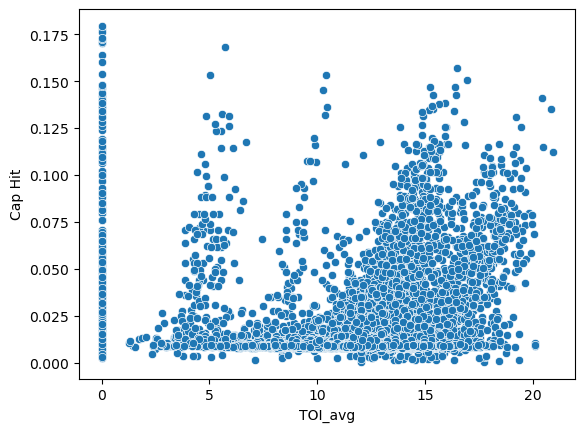

In [8]:
# look at salary cap vs TOI
sns.scatterplot(x=data['TOI_avg'],y=data['Cap Hit']);

From this chart, we get an interesting finding - that there is a substantial number of observations where average time-on-ice is zero. Before proceeding, we should look at the distribution of this variable, and possibly look to exclude those observations, even if they are technically not missing.

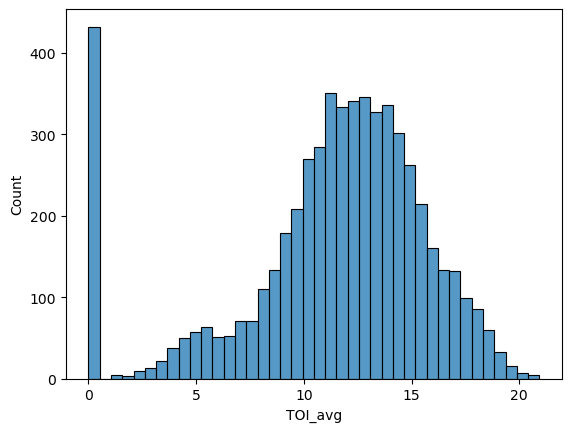

In [9]:
# histogram of average TOI
sns.histplot(data['TOI_avg']);

Here we see that while the TOI is a somewhat normally distributed variable, there are a substantial number of observations where the associated average TOI is zero - given the construction of the features, that means the TOI for the three years proceeding the contract must also be zero. The next step is to conclude whether or not these observations can be trusted.

In [10]:
# find observations where TOI is zero and games played is zero
data[(data['TOI_avg'] == 0) & (data['GAMES_PLAYED_avg'] == 0)]

Length  Contract Age   Cap Hit Position Nationality  Height  \
2477     2.0          30.0  0.008896        D         USA    75.0   
3246     1.0          29.0  0.008589        R         CAN    72.0   
4487     2.0          25.0  0.008896        C         USA    73.0   
5068     1.0          23.0  0.012326        C         CAN    70.0   

      Overall Pick  GAMES_PLAYED_t  G_t  A_t  ...  ixG_PLAYOFF_avg  \
2477          35.0             0.0  0.0  0.0  ...             0.00   
3246         121.0             0.0  0.0  0.0  ...             0.26   
4487         174.0             0.0  0.0  0.0  ...             0.00   
5068          17.0             0.0  0.0  0.0  ...             0.03   

      xG±/60_PLAYOFF_avg  RelxG±/60_PLAYOFF_avg  C±/60_PLAYOFF_avg  \
2477                0.55                   0.79             -34.79   
3246               -0.09                   0.09              22.32   
4487               -0.56                   0.04              -4.94   
5068                0.14                   0.80              20.23   

      RelC±/60_PLAYOFF_avg  G_PG_avg  P_PG_avg  PIM_PG_avg  G_PG_PLAYOFF_avg  \
2477                -33.58       0.0       0.0         0.0               0.0   
3246                 16.94       0.0       0.0         0.0               0.0   
4487                 -3.33       0.0       0.0         0.0               0.0   
5068                 41.08       0.0       0.0         0.0               0.0   

      P_PG_PLAYOFF_avg  
2477          1.000000  
3246          0.166667  
4487          0.000000  
5068          0.333333  

[4 rows x 123 columns]

We find four observations where average TOI is zero and the number of games played is also zero - these are sensible observations because if a player is not playing in any games, then there TOI will as a result be equal to zero. We should keep these observations.

In [11]:
# find observations where TOI is zero and games played is not zero
bad_rows = (list(data[(data['TOI_avg'] == 0) & (data['GAMES_PLAYED_avg'] != 0)].index) + 
            list(data[(data['TOI_PLAYOFF_avg'] == 0) & (data['GP_PLAYOFF_avg'] != 0)].index))

In [12]:
# get unique observations
bad_rows = list(set(bad_rows))

In [13]:
len(bad_rows)

483

Since it is pretty nonsensical that a player could play in a nonzero number of games over the course of three years and still be considered to have zero ice time, we need to treat these observations as effectively 'missing' and drop them from the dataset.

In [14]:
# drop effectively missing data from table
data = data.drop(bad_rows,axis=0)

In [15]:
data.shape

(5182, 123)

With those observations removed, we can re-confirm the distribution of the TOI variable, and also assess how it impacts cap hit.

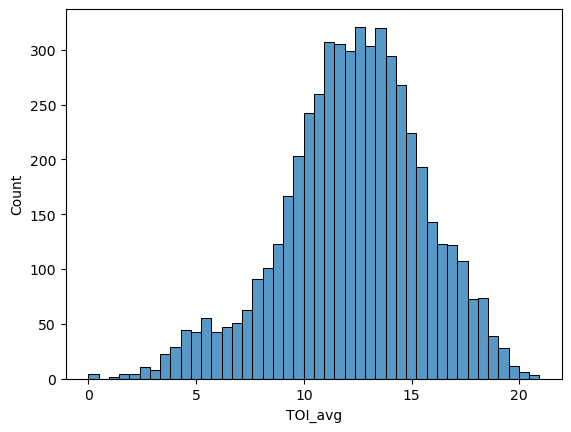

In [16]:
# histogram of average TOI
sns.histplot(data['TOI_avg']);

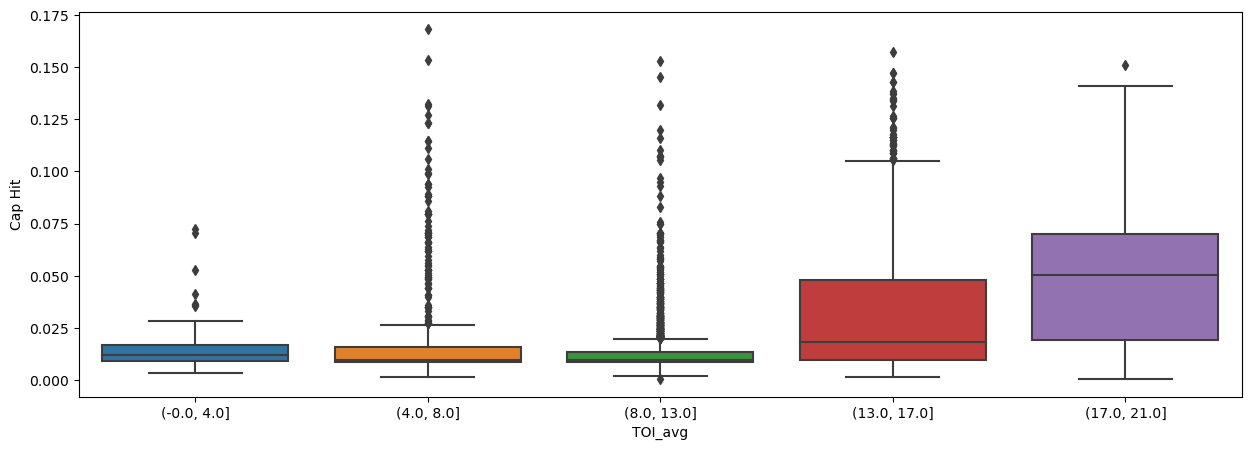

In [17]:
# plot TOI vs cap hit
fig,ax = plt.subplots(1,1,figsize=(15,5))
cut_toi = pd.cut(data['TOI_avg'],bins=5,precision=0)
sns.boxplot(x=cut_toi,y=data['Cap Hit']);

It is obvious here that more TOI on ice is associated with a higher cap hit, which might be more of an effect than a cause; it is probable that teams will want more highly-paid players to have more time on ice, presumably on account of skill but also perhaps because of some bias that the higher cap-hit players have more resources invested in them, and as a result should have to play more.

Before turning to the rest of the numeric data, we should look at the only two categorical variables: player position and nationality. In the positions we are examining in this project, players fall into two broad categories, defense ('D') and forwards ('F'). Forwards can further be broken down into centers ('C') and right ('R') and left ('L') wings.

In [18]:
# look at all forwards vs defense
data['Position_sub'] = data['Position'].apply(lambda x: 'D' if x == 'D' else 'F')

In [19]:
# calculate position breakdown by percentage
data['Position'].value_counts(normalize=True)

D    0.353146
C    0.286955
L    0.191818
R    0.168082
Name: Position, dtype: float64

In [20]:
data['Position_sub'].value_counts(normalize=True)

F    0.646854
D    0.353146
Name: Position_sub, dtype: float64

From the breakdowns of contracts by position, we see that the split is about 65% forwards and 35% defensemen. This is consistent with the typically roster breakdown per game, which tends to have 12 forwards and 6 defensemen per 18 non-goalie skaters.

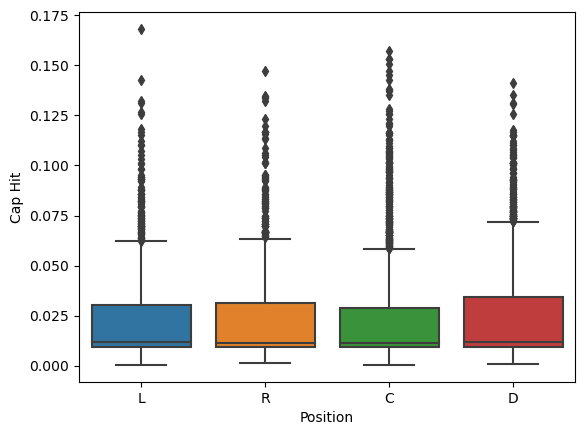

In [21]:
# boxplot of cap hit vs position
sns.boxplot(data=data,x='Position',y='Cap Hit');

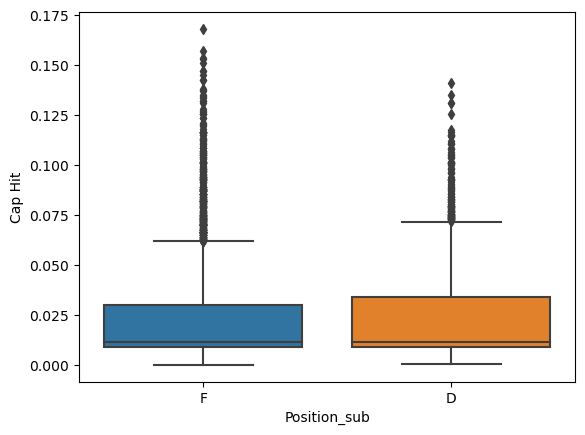

In [22]:
# boxplot of cap hit vs position category
sns.boxplot(data=data,x='Position_sub',y='Cap Hit');

From the boxplots above, we can see that there is a slight distinction, though small, between forwards and defensemen, where it appears that the average cap hit of defense contracts are slightly higher than those of forwards.

In [23]:
# look at number of players of each nationality
data['Nationality'].value_counts(normalize=True)

CAN    0.517561
USA    0.276148
SWE    0.064840
CZE    0.035122
FIN    0.029332
RUS    0.025859
SVK    0.011000
CHE    0.009842
DEU    0.006561
DNK    0.005789
LVA    0.003474
FRA    0.002702
AUT    0.002316
BLR    0.002316
NOR    0.001930
UKR    0.001544
LTU    0.000772
AUS    0.000579
POL    0.000579
NLD    0.000579
GBR    0.000386
SVN    0.000386
NGA    0.000193
HRV    0.000193
Name: Nationality, dtype: float64

From the breakdown of contracts by nationality, we can see that most (nearly 78%) are attributed to Canadian and American players.

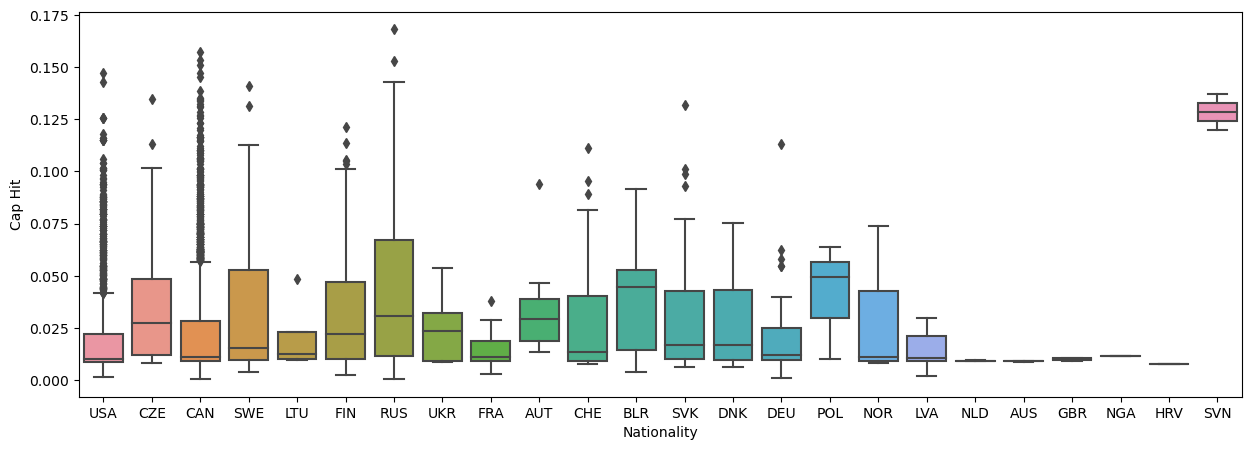

In [24]:
# boxplot of cap hit vs player nationality
fig,ax = plt.subplots(1,1,figsize=(15,5))
sns.boxplot(data=data,x='Nationality',y='Cap Hit',ax=ax);

Now looking at salary cap hit by player nationality, there is a lot more divergence, though we can draw a couple of interesting conclusions:
1. The USA and Canada, while have among the lowest median cap hits, also have by far the most outliers - this is likely a consequence of having the most players from these countries, and thus encompassing the largest range of salaries
2. Slovenia offered the highest median cap hit of all the countries included, though a very small number of contracts attributed, suggesting the limited number of contracts there were higher

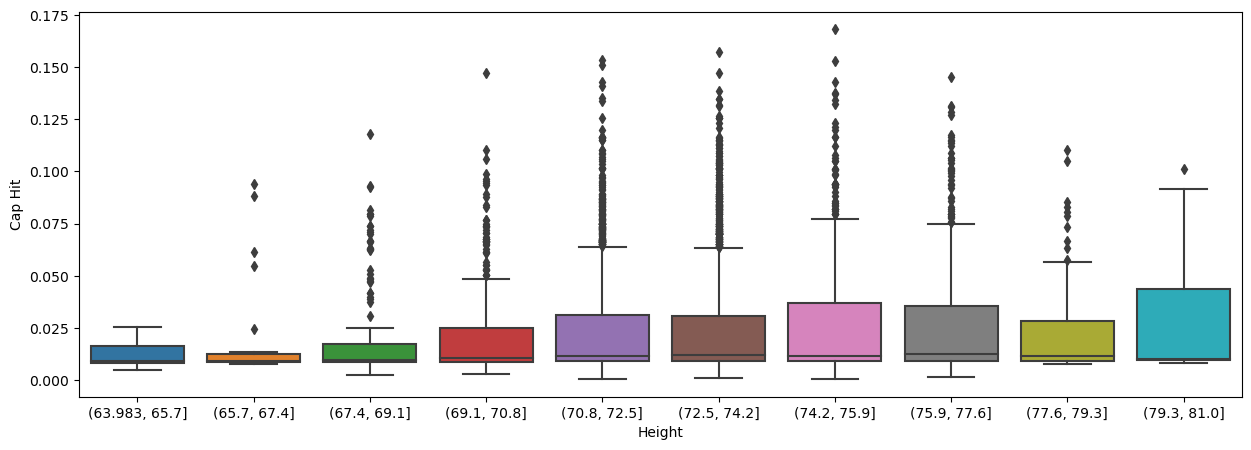

In [25]:
# look at salary cap vs height
fig,ax = plt.subplots(1,1,figsize=(15,5))
cut_height = pd.cut(data['Height'],bins=10)
sns.boxplot(x=cut_height,y=data['Cap Hit']);

While there is not an obvious relationship between salary cap hit and height, it does appear that shorter players tended to have lower cap hits, whereas taller players, who still had a range of cap hits, had more potential for higher salaries than their shorter counterparts. Overall, however, height does not appear to be a strong driver of salary.

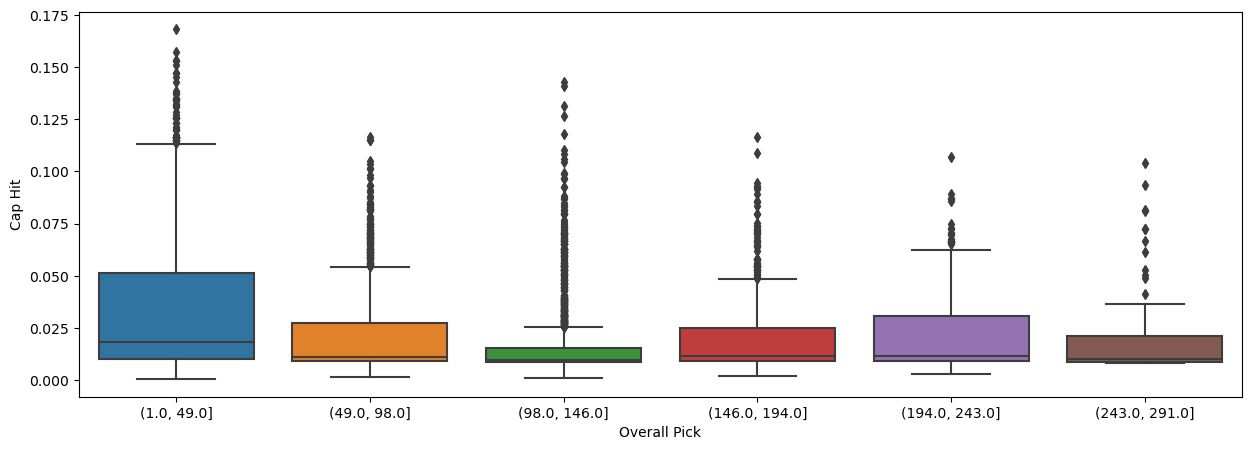

In [26]:
# look at salary cap vs draft pick
fig,ax = plt.subplots(1,1,figsize=(15,5))
cut_draftPick = pd.cut(data['Overall Pick'],bins=6,precision=0)
sns.boxplot(x=cut_draftPick,y=data['Cap Hit']);

Overall pick in the NHL draft is considered historically to be a strong indicator because the success of early draft picks tends to draw much publicity. While the above splot shows that the median contract is indeed higher for the first 49 picks in the draft, the median cap hits for players taken outside that appear to be similar.

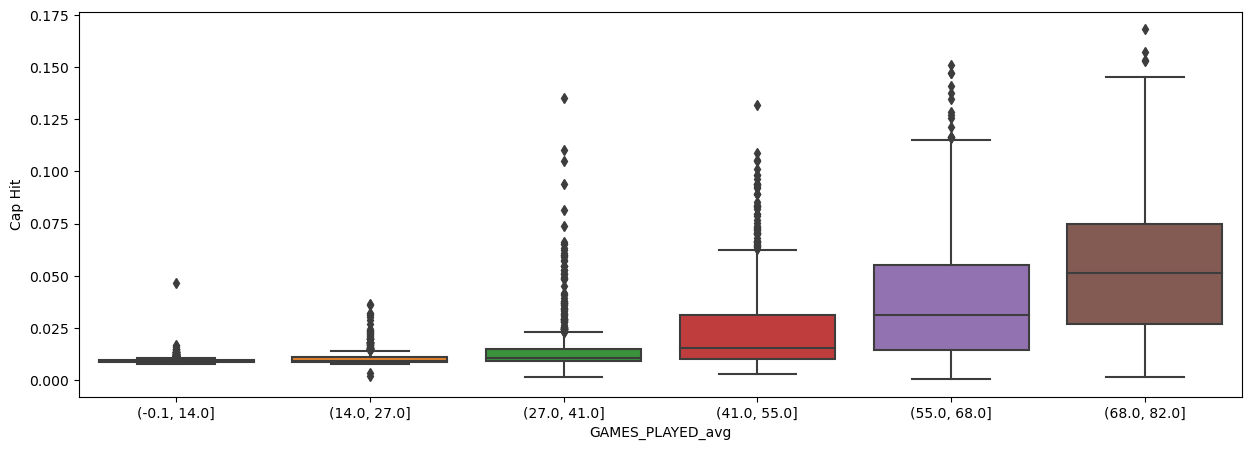

In [27]:
# look at salary cap vs draft pick
fig,ax = plt.subplots(1,1,figsize=(15,5))
cut_gamesPlayed = pd.cut(data['GAMES_PLAYED_avg'],bins=6,precision=0)
sns.boxplot(x=cut_gamesPlayed,y=data['Cap Hit']);

Unsurprisingly, salary cap hit does increase quite a lot with games played; strong players are likely to be played in as many games as possible, rather than be healthy scratches, for example, and moreover, number of games played is a typical indicator of health (i.e. no injuries), which is also a positive signal in contract negotiations, because injured players present a risk to the value of a future contract.

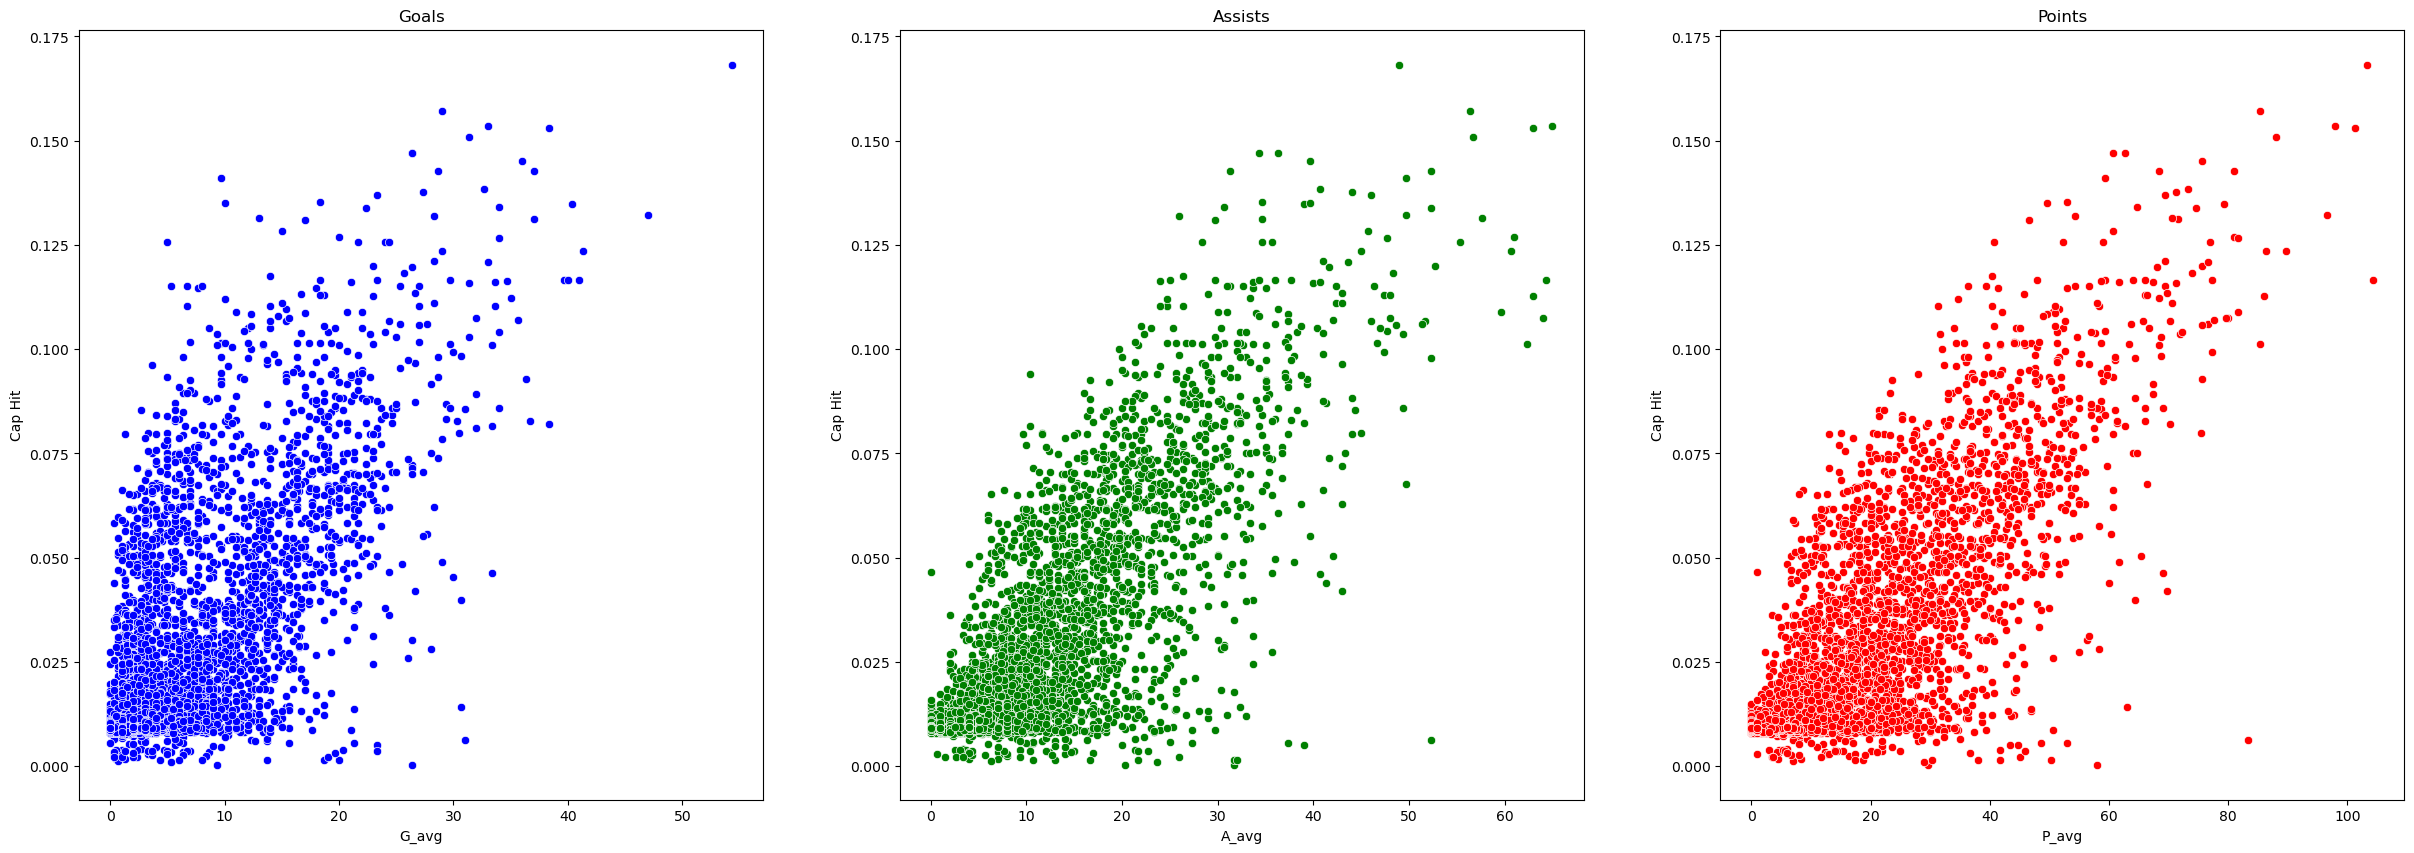

In [28]:
# look at salary cap vs draft pick
fig,ax = plt.subplots(1,3,figsize=(30,10))
sns.scatterplot(x=data['G_avg'],y=data['Cap Hit'],ax=ax[0],c='b')
ax[0].set_title('Goals')
sns.scatterplot(x=data['A_avg'],y=data['Cap Hit'],ax=ax[1],c='g')
ax[1].set_title('Assists')
sns.scatterplot(x=data['P_avg'],y=data['Cap Hit'],ax=ax[2],c='r')
ax[2].set_title('Points');

In one of the cleanest visuals yet, we can see that salary cap increases with goals, assists, and points (the sum of goals and assists). The relationship is slightly stronger in assists and points, most likely because assists typically make up a larger portion of a players point total, as multiple players can have an assist on a goal. 

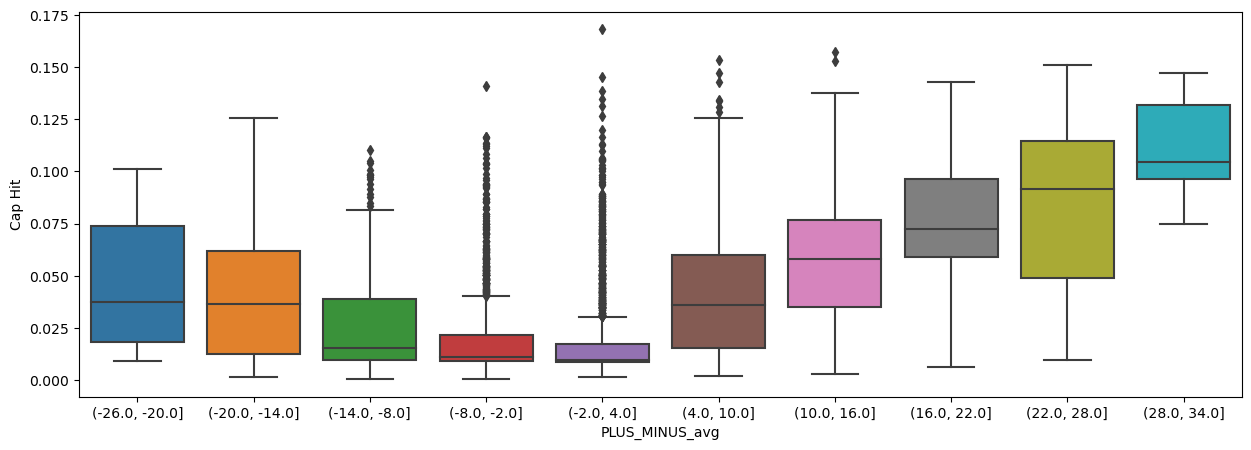

In [29]:
# look at salary cap vs draft pick
fig,ax = plt.subplots(1,1,figsize=(15,5))
cut_plusMinus = pd.cut(data['PLUS_MINUS_avg'],bins=10,precision=0)
sns.boxplot(x=cut_plusMinus,y=data['Cap Hit']);

Interestingly, there appears to be an unusually-shaped relationship between plus-minus and salary cap hit. Though cap hit increases with plus-minus score from zero, it appears that it increases with worse scores as well. The best explanation for this is that highly paid players on poorly performing teams will have poor plus-minus scores on account of his team being ultimately outscored, so plus-minus score, as a drawback to the metric, does encapsulate some of the team performance that might obscure the reality of a player's value to the team.

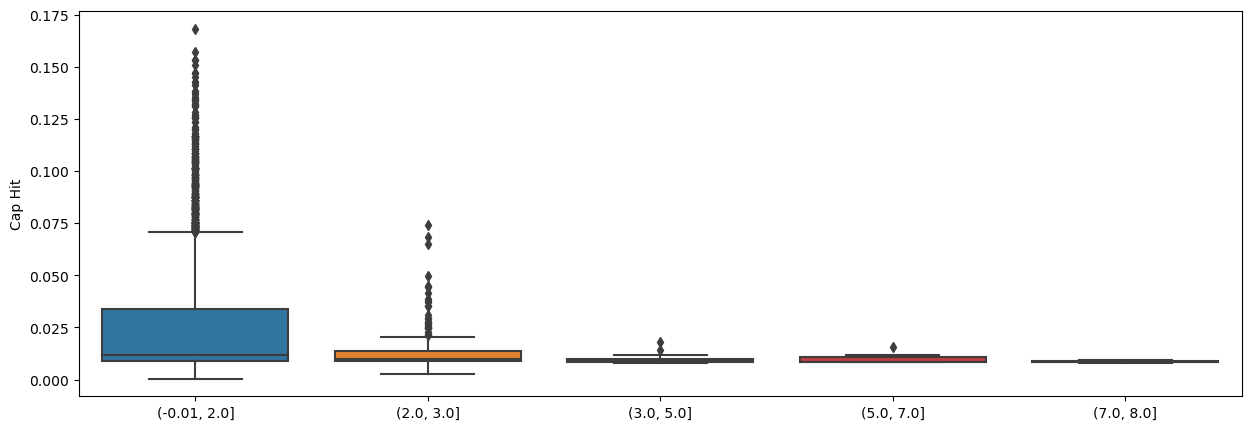

In [30]:
# plot PIM vs cap hit
fig,ax = plt.subplots(1,1,figsize=(15,5))
cut_pim = pd.cut(data['PIM_avg']/data['GAMES_PLAYED_avg'],bins=5,precision=0)
sns.boxplot(x=cut_pim,y=data['Cap Hit']);

In what is also an unsurprising finding, players with less penalty minutes per game tend to be more highly compensated, though it does not appear to have too strong an effect on the median cap hit, more so being the case that the most highly compensated players appear to have low penalty minute counts. This makes sense because, despite spending more time on ice, better players are likely to avoid taking penalities via skilled play, and more so will have less desire to expose their teams to man disadvantages that occur with penalty minutes. 

As a summary, from simpla EDA, we can make the following observations about the data that should color our expectations of what will be important features in the model. Among these are the following:

* points, goals, and assists seems to be the most positively related with contract annual value
* time on ice and games played are also positively associated with contract annual value, although this may be a consequence of contract value to some extent
* there does not appear to be a strong relationship between country of origin and contract values
* it appears that defensemen may have a slight edge over forwards in terms of contract value
* there is some association between draft pick and contract value, but it is not clear to what extent

# Modeling

The modeling process for this project is twofold; because we are trying to predict the value of a player's contract, we need to separately model the annual cap hit of the contract, as well as the length of the contract. The annual dollar value (AAV) of the contract multiplied by the length of the contract gives the total contract value. 

First, the data needs to be further prepared for modeling. This involves splitting the data into training and test sets, encoding the categorical variables, and scaling the numeric variables. 

Second, for the model approaches used, cross-validation will be performed on the training set. We will use grid search with cross-validation to obtain the best parameters for each model tested.

Finally, a final model with the selected parameterization will be fitted on the full training set, and then run on the test set. The final model with the lowest mean average error on the test set will be selected as the final model and used for prediction on the new data. 

The choice of scoring metric is an important one in model selection, because choosing a model based on one metric or another might ultimately lead to a different set of predictions with new data. For regression-based error metrics, two typical choices are mean average error and root mean squared error. I have chosen mean average error as the preferred metric for two reasons:

1. the error term becomes directly interpretable; we are able to say that any predicted contract is on average off by some amount of yearly value and length, which gives the stakeholders a direct intuition for the usefulness of the model.
2. without a bias towards a certain kind of error distribution - for example, we cannot say with certainty that being off by a lot on a single contract is worse than being off by a lesser amount on multiple - the mean average error becomes the more conservative choice of metric.

### Data Preparation

First, we need to split the data into dependent and independent variables. In this case, the independent variables are the same for both models, and there are two different vectors for the dependent variables.

In [31]:
# create a copy of data
data = data.drop(columns=['Position_sub'],axis=1)

In [32]:
# split data for cap hit model
y = data['Cap Hit']
y_l = data['Length']
X = data.drop(columns=['Cap Hit','Length'],axis=1)

Now that the data is split into independent and dependent variables for each model, we can split them into training and test sets.

In [33]:
# split data into train-test sets
X_train,X_test,y_train,y_test,y_l_train,y_l_test = train_test_split(X,y,y_l,test_size=0.25,random_state=100)

Finally, we can encode the categorical features, and scale the numeric features.

In [34]:
# split data into categorical variables
categorical_variables = ['Position','Nationality']
X_train_categorical = X_train[categorical_variables]
X_train_numeric = X_train.drop(columns=categorical_variables,axis=1)

# encode categorical variables
ohe_X_train = OneHotEncoder(sparse=False)
x_train_categorical = ohe_X_train.fit_transform(X_train_categorical)
X_train_categorical = pd.DataFrame(x_train_categorical,columns=ohe_X_train.get_feature_names_out())

# save encoder categories for future use - makes the encoding consistent between models
encoder_categories = ohe_X_train.categories_

# scale numeric variables
scaler_X_train = StandardScaler()
x_train_numeric = scaler_X_train.fit_transform(X_train_numeric)
X_train_numeric = pd.DataFrame(x_train_numeric,columns=X_train_numeric.columns)

# re-combine categorical and numeric features
X_train = pd.concat([X_train_categorical,X_train_numeric],axis=1)

In [35]:
X_train.head()

Position_C  Position_D  Position_L  Position_R  Nationality_AUS  \
0         0.0         1.0         0.0         0.0              0.0   
1         1.0         0.0         0.0         0.0              0.0   
2         0.0         1.0         0.0         0.0              0.0   
3         1.0         0.0         0.0         0.0              0.0   
4         0.0         0.0         1.0         0.0              0.0   

   Nationality_AUT  Nationality_BLR  Nationality_CAN  Nationality_CHE  \
0              0.0              0.0              0.0              0.0   
1              0.0              0.0              1.0              0.0   
2              0.0              0.0              1.0              0.0   
3              0.0              0.0              0.0              0.0   
4              0.0              0.0              1.0              0.0   

   Nationality_CZE  ...  ixG_PLAYOFF_avg  xG±/60_PLAYOFF_avg  \
0              0.0  ...        -0.504947           -2.801333   
1              0.0  ...        -0.525779            0.114564   
2              0.0  ...        -0.525779            0.114564   
3              0.0  ...        -0.484115           -0.635238   
4              0.0  ...        -0.525779            0.114564   

   RelxG±/60_PLAYOFF_avg  C±/60_PLAYOFF_avg  RelC±/60_PLAYOFF_avg  G_PG_avg  \
0              -2.048214          -0.386665              0.524633 -0.743235   
1               0.047985           0.119172              0.052501  0.483383   
2               0.047985           0.119172              0.052501 -0.516492   
3              -0.990319          -0.286341             -0.938261 -0.205874   
4               0.047985           0.119172              0.052501 -0.682904   

   P_PG_avg  PIM_PG_avg  G_PG_PLAYOFF_avg  P_PG_PLAYOFF_avg  
0 -0.577571   -0.687148         -0.481417         -0.575371  
1  0.205262   -0.631239         -0.481417         -0.575371  
2 -0.543402    0.226297         -0.481417         -0.575371  
3 -0.452762    0.385703         -0.481417         -0.575371  
4 -0.843339    3.212922         -0.481417         -0.575371  

[5 rows x 146 columns]

In [36]:
X_train.shape

(3886, 146)

In [37]:
# apply same transformations to test set
X_test_categorical = X_test[categorical_variables]
X_test_numeric = X_test.drop(columns=categorical_variables,axis=1)

# make new OHE with same categories as in training set
ohe_X_test = OneHotEncoder(sparse=False,handle_unknown='ignore',categories=encoder_categories)
X_test_categorical = ohe_X_test.fit_transform(X_test_categorical)
X_test_categorical = pd.DataFrame(X_test_categorical,columns=ohe_X_test.get_feature_names_out())

x_test_numeric = scaler_X_train.transform(X_test_numeric)
X_test_numeric = pd.DataFrame(x_test_numeric,columns=X_test_numeric.columns)

X_test = pd.concat([X_test_categorical,X_test_numeric],axis=1)

In [38]:
X_test.head()

Position_C  Position_D  Position_L  Position_R  Nationality_AUS  \
0         0.0         1.0         0.0         0.0              0.0   
1         0.0         1.0         0.0         0.0              0.0   
2         0.0         0.0         0.0         1.0              0.0   
3         0.0         0.0         1.0         0.0              0.0   
4         0.0         1.0         0.0         0.0              0.0   

   Nationality_AUT  Nationality_BLR  Nationality_CAN  Nationality_CHE  \
0              0.0              0.0              0.0              0.0   
1              0.0              0.0              1.0              0.0   
2              0.0              0.0              0.0              0.0   
3              0.0              0.0              1.0              0.0   
4              0.0              0.0              1.0              0.0   

   Nationality_CZE  ...  ixG_PLAYOFF_avg  xG±/60_PLAYOFF_avg  \
0              0.0  ...        -0.525779            0.114564   
1              0.0  ...        -0.525779            0.114564   
2              0.0  ...         1.793495           -0.202019   
3              0.0  ...        -0.136918           -0.210350   
4              0.0  ...        -0.525779            0.114564   

   RelxG±/60_PLAYOFF_avg  C±/60_PLAYOFF_avg  RelC±/60_PLAYOFF_avg  G_PG_avg  \
0               0.047985           0.119172              0.052501 -0.970801   
1               0.047985           0.119172              0.052501 -0.970801   
2              -1.509471           0.829876             -0.934684  0.857756   
3              -0.529939           0.157145             -0.389229  0.117828   
4               0.047985           0.119172              0.052501 -0.556188   

   P_PG_avg  PIM_PG_avg  G_PG_PLAYOFF_avg  P_PG_PLAYOFF_avg  
0 -1.050867    1.808367         -0.481417         -0.575371  
1 -1.276644    0.278390         -0.481417         -0.575371  
2  1.191161   -0.546244          0.268367          2.066767  
3  0.236675   -0.245256         -0.481417         -0.575371  
4 -0.463078   -0.549736         -0.481417         -0.575371  

[5 rows x 146 columns]

In [39]:
X_test.shape

(1296, 146)

### Cap Hit Modelling

Now that the data is prepared, we will start by iteratively building models. For each model, we will use GridSearchCV on the training data. Then, we will build a final model using the parameters for the performing model, and train that model on the training data. This same model can be run on the test data to get an out-of-sample score that can help us determine the final model to use for prediction.

In [40]:
# initialize dataframe to store model errors
cap_hit_error = pd.DataFrame()

#### Ridge Regression

In [41]:
# initialize ridge regression and parameters
ridge = linear_model.Ridge(random_state=100)
ridge_parameters = {'alpha': np.concatenate((np.arange(0.1,2,0.1),np.arange(2, 5, 0.5),np.arange(5, 25, 1))),
                    'positive': [True,False],
                    'fit_intercept': [True,False],
                    'random_state': [100]}

In [42]:
# perform grid search
gs_ridge = GridSearchCV(ridge,ridge_parameters,scoring='neg_mean_absolute_error',cv=5,verbose=False)
gs_ridge.fit(X_train,y_train)

GridSearchCV(cv=5, estimator=Ridge(random_state=100),
             param_grid={'alpha': array([ 0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ,  1.1,
        1.2,  1.3,  1.4,  1.5,  1.6,  1.7,  1.8,  1.9,  2. ,  2.5,  3. ,
        3.5,  4. ,  4.5,  5. ,  6. ,  7. ,  8. ,  9. , 10. , 11. , 12. ,
       13. , 14. , 15. , 16. , 17. , 18. , 19. , 20. , 21. , 22. , 23. ,
       24. ]),
                         'fit_intercept': [True, False],
                         'positive': [True, False], 'random_state': [100]},
             scoring='neg_mean_absolute_error', verbose=False)

In [43]:
gs_ridge.best_params_

{'alpha': 24.0, 'fit_intercept': True, 'positive': False, 'random_state': 100}

In [44]:
gs_ridge.best_score_

-0.008498479974524102

In [45]:
# build final model using best params
ridge_final = linear_model.Ridge(alpha=24,fit_intercept=True,positive=False,random_state=100)
ridge_final.fit(X_train,y_train)

Ridge(alpha=24, random_state=100)

In [46]:
# get final model error
ridge_predict = pd.Series(ridge_final.predict(X_test))
ridge_predict.name = 'Predicted Cap Hit'
ridge_final_mae = mean_absolute_error(ridge_final.predict(X_test),y_test)
ridge_final_mae

0.008227167921330329

In [47]:
# add ridge mae to dataframe
cap_hit_error.loc['Ridge Regression','Contract Annual Value'] = ridge_final_mae
cap_hit_error

Contract Annual Value
Ridge Regression               0.008227

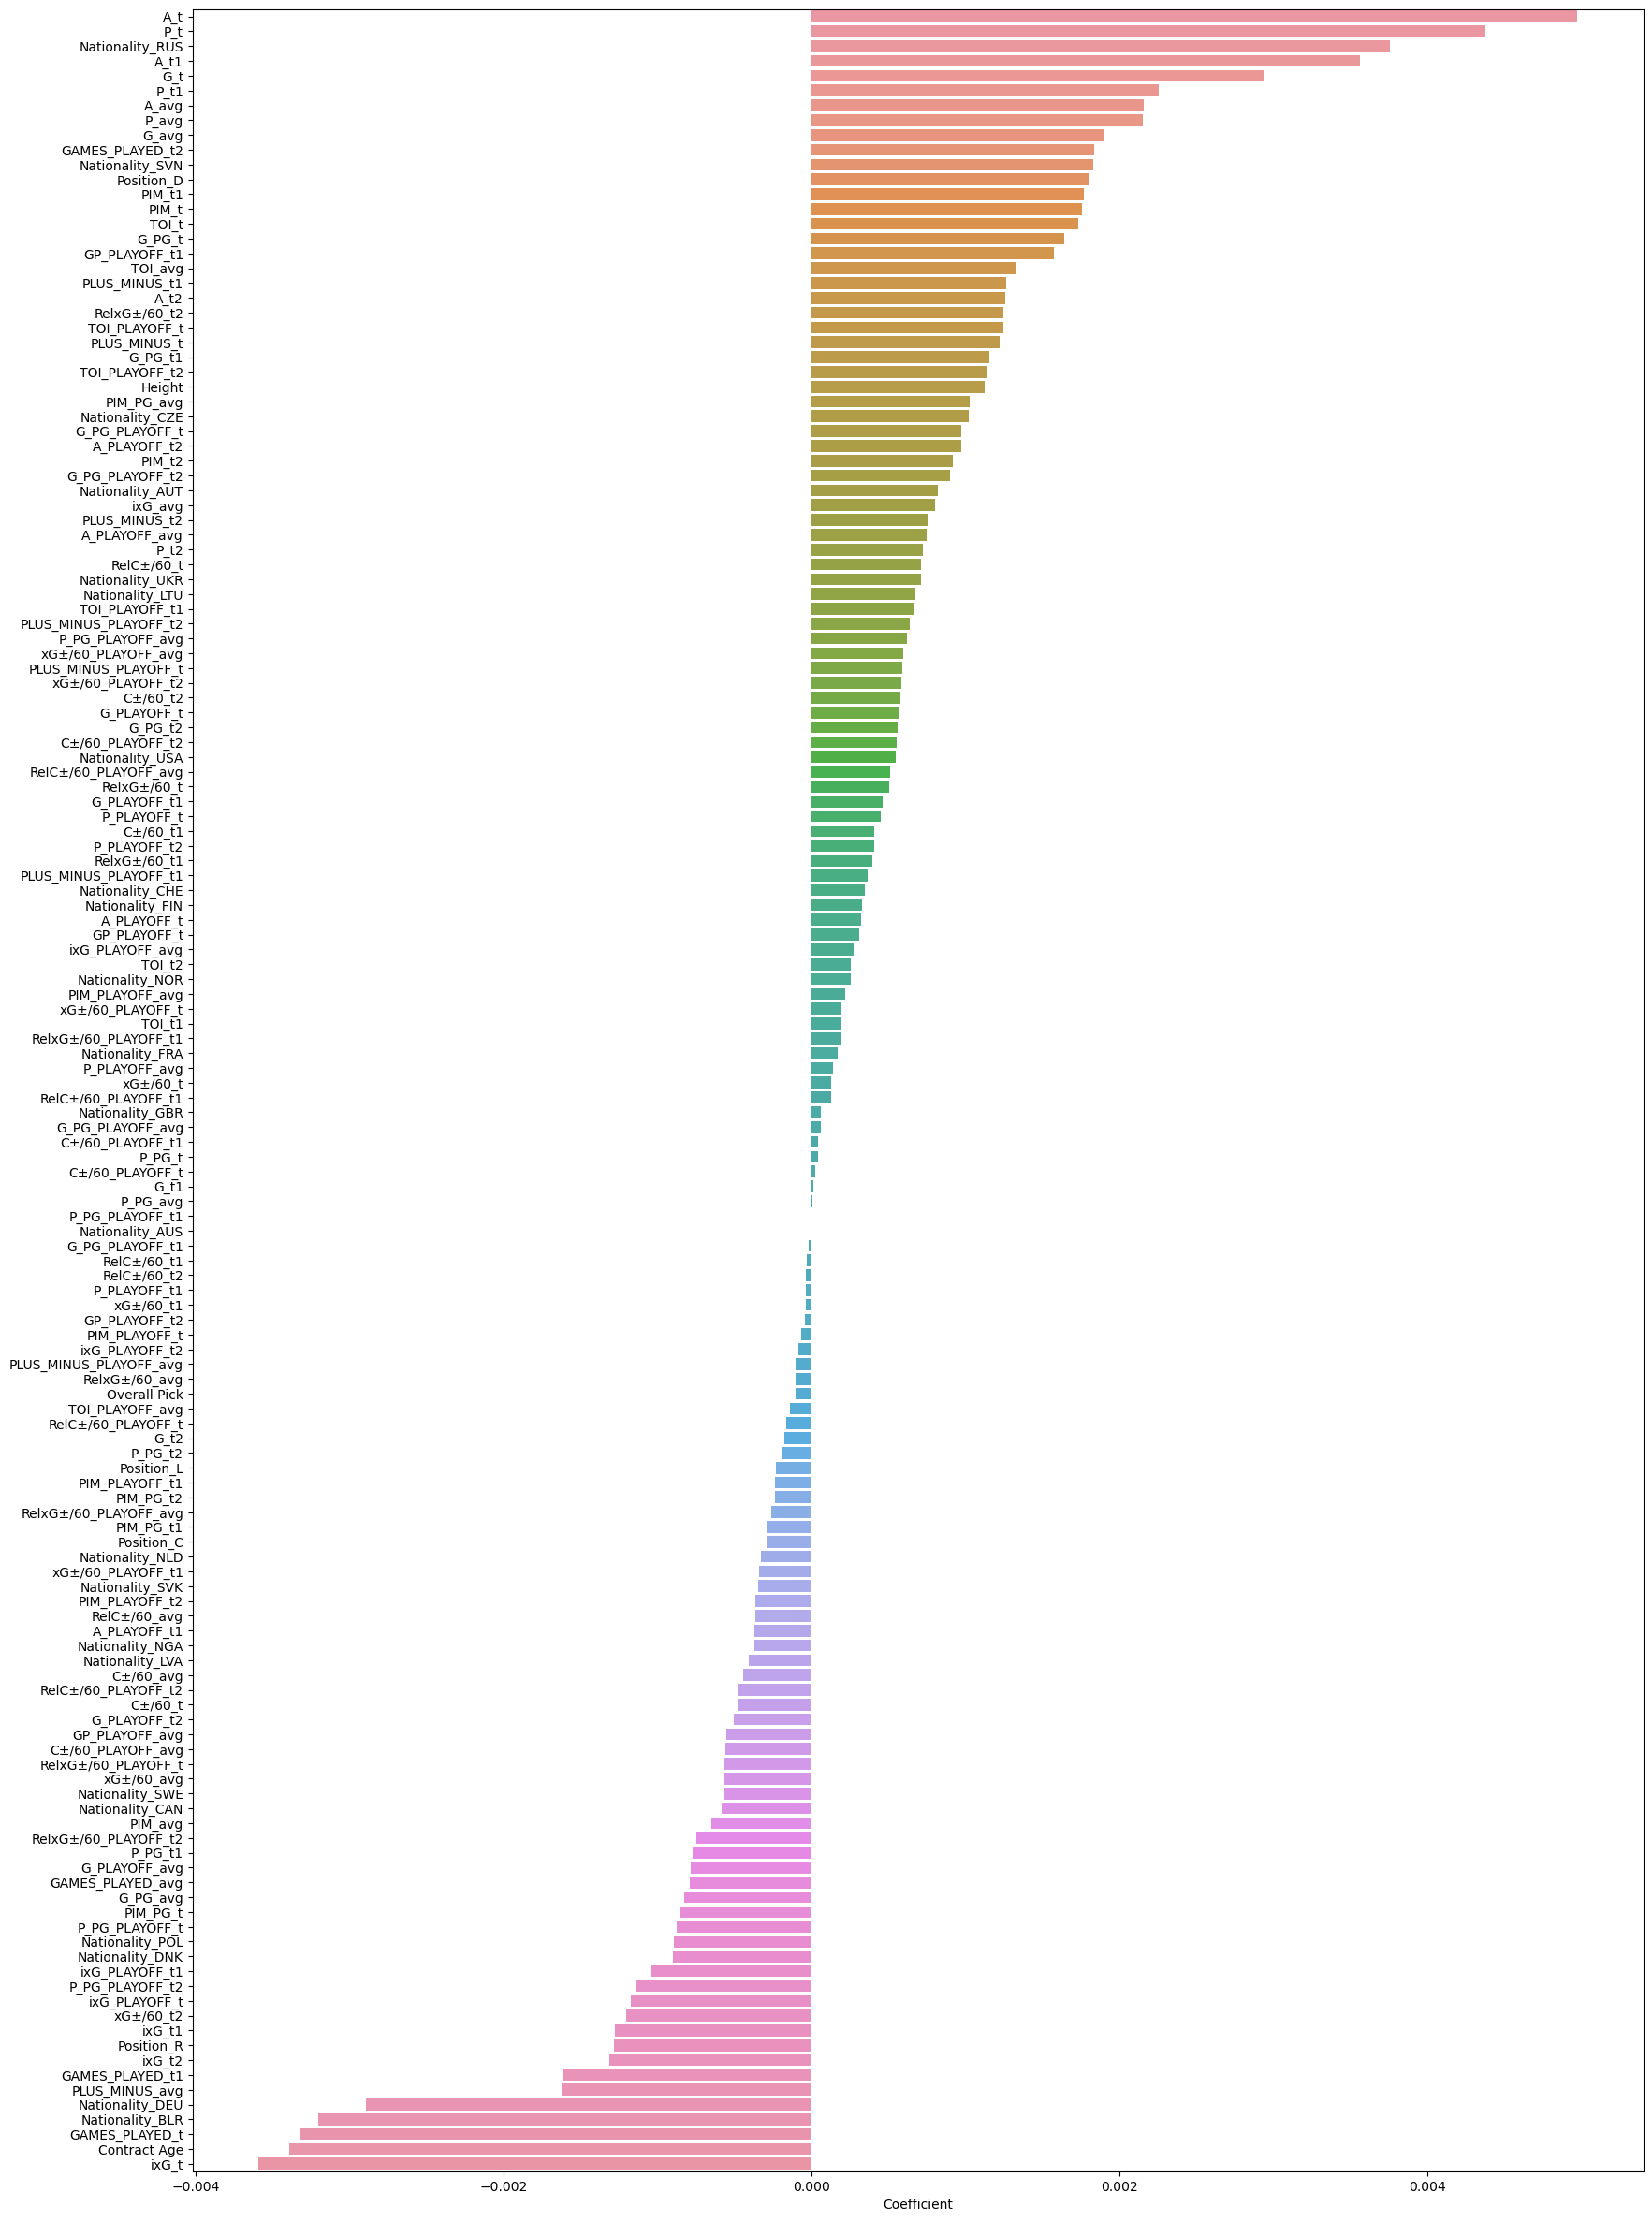

In [48]:
# get coefficients chart
ridge_coef = pd.DataFrame(pd.Series(ridge_final.coef_,index=ridge_final.feature_names_in_)).sort_values(by=0,ascending=False)
ridge_coef.columns = ['Coefficient']
fig,ax = plt.subplots(figsize=(20,30))
sns.barplot(y=ridge_coef.index,x=ridge_coef['Coefficient']);

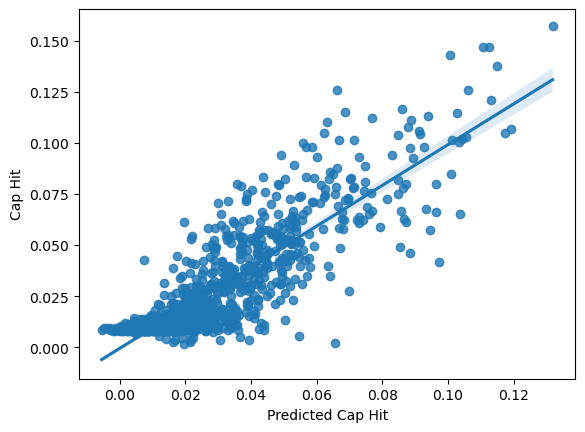

In [49]:
# plot true values vs residuals
sns.regplot(x=ridge_predict,y=y_test);

While ridge regression is typically poor for feature selection, among the largest coefficients are assists and points by a player in a contract year, which are features that we would expect to be significant in predicting cap hits. On the other hand, it associates games played with a negative coefficient, though we would have expected this to be positively related to the points feature. This may just be a function of the model dealing with multicollinearity by penalizing yet another features that is trying to explain the same data.

#### LASSO

In [50]:
# initialize LASSO
lasso = linear_model.Lasso(random_state=100)
lasso_parameters = {'alpha': np.concatenate((np.arange(0.005,2,0.005),np.arange(2,5,0.5),np.arange(5,25,1))),
                    'positive': [True,False],
                    'fit_intercept': [True,False],
                    'random_state': [100]}

In [51]:
# perform grid search
gs_lasso = GridSearchCV(lasso,lasso_parameters,scoring='neg_mean_absolute_error',cv=5,verbose=False)
gs_lasso.fit(X_train,y_train)

GridSearchCV(cv=5, estimator=Lasso(random_state=100),
             param_grid={'alpha': array([5.000e-03, 1.000e-02, 1.500e-02, 2.000e-02, 2.500e-02, 3.000e-02,
       3.500e-02, 4.000e-02, 4.500e-02, 5.000e-02, 5.500e-02, 6.000e-02,
       6.500e-02, 7.000e-02, 7.500e-02, 8.000e-02, 8.500e-02, 9.000e-02,
       9.500e-02, 1.000e-01, 1.050e-01, 1.100e-01, 1.150e-01, 1.200e-01,
       1.250e-01, 1.300e-01, 1.350e-01, 1...
       3.500e+00, 4.000e+00, 4.500e+00, 5.000e+00, 6.000e+00, 7.000e+00,
       8.000e+00, 9.000e+00, 1.000e+01, 1.100e+01, 1.200e+01, 1.300e+01,
       1.400e+01, 1.500e+01, 1.600e+01, 1.700e+01, 1.800e+01, 1.900e+01,
       2.000e+01, 2.100e+01, 2.200e+01, 2.300e+01, 2.400e+01]),
                         'fit_intercept': [True, False],
                         'positive': [True, False], 'random_state': [100]},
             scoring='neg_mean_absolute_error', verbose=False)

In [52]:
gs_lasso.best_params_

{'alpha': 0.005, 'fit_intercept': True, 'positive': False, 'random_state': 100}

In [53]:
gs_lasso.best_score_

-0.009891339789767828

In [54]:
# build final model using best params
lasso_final = linear_model.Lasso(alpha=0.005,fit_intercept=True,positive=False,random_state=100)
lasso_final.fit(X_train,y_train)

Lasso(alpha=0.005, random_state=100)

In [55]:
# get final model error
lasso_predict = pd.Series(lasso_final.predict(X_test))
lasso_predict.name = 'Predicted Cap Hit'
lasso_final_mae = mean_absolute_error(lasso_final.predict(X_test),y_test)
lasso_final_mae

0.009267707178031121

In [56]:
# add lasso mae to dataframe
cap_hit_error.loc['LASSO Regression','Contract Annual Value'] = lasso_final_mae
cap_hit_error

Contract Annual Value
Ridge Regression               0.008227
LASSO Regression               0.009268

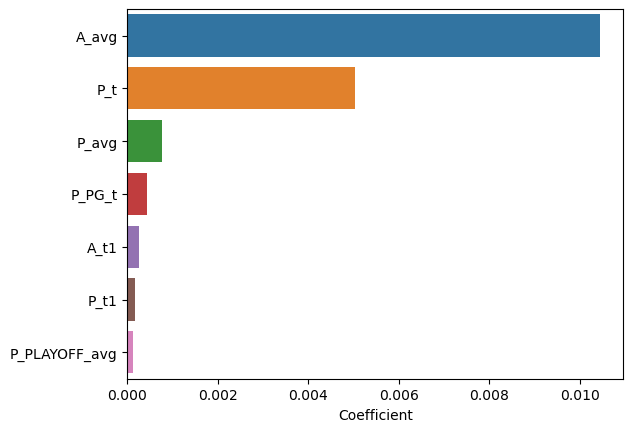

In [57]:
# get coefficients chart
lasso_coef = pd.DataFrame(pd.Series(lasso_final.coef_,index=lasso_final.feature_names_in_)).sort_values(by=0,ascending=False)
lasso_coef.columns = ['Coefficient']
lasso_coef = lasso_coef[lasso_coef['Coefficient'] != 0]
sns.barplot(y=lasso_coef.index,x=lasso_coef['Coefficient']);

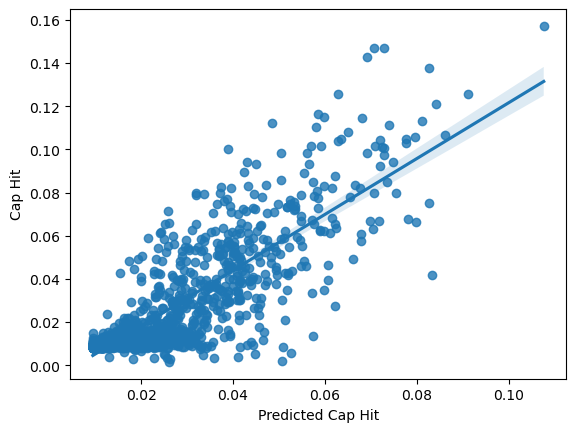

In [58]:
# plot true values vs residuals
sns.regplot(x=lasso_predict,y=y_test);

The LASSO model has a worse out-of-sample performance than the ridge regression model, however it is more helpful in determining feature importance given that is provides actual feature selection. The features that the LASSO model has selected are average points and assists, and points and assists in the contract year. This is expected on the basis of intution and the results of the ridge regression model, but it is notable that the LASSO model performs only slightly worse in absolute terms with just four features, signaling the importance of these featurse in predict salary cap hits.

#### Elastic Net

In [59]:
# initialize Elastic Net
eln = linear_model.ElasticNet(random_state=100)
eln_parameters = {'alpha': np.arange(0,1,0.005),
                  'fit_intercept': [True,False],
                  'random_state': [100]}

In [60]:
# perform grid search
gs_eln = GridSearchCV(eln,eln_parameters,scoring='neg_mean_absolute_error',cv=5,verbose=False)
gs_eln.fit(X_train,y_train)

GridSearchCV(cv=5, estimator=ElasticNet(random_state=100),
             param_grid={'alpha': array([0.   , 0.005, 0.01 , 0.015, 0.02 , 0.025, 0.03 , 0.035, 0.04 ,
       0.045, 0.05 , 0.055, 0.06 , 0.065, 0.07 , 0.075, 0.08 , 0.085,
       0.09 , 0.095, 0.1  , 0.105, 0.11 , 0.115, 0.12 , 0.125, 0.13 ,
       0.135, 0.14 , 0.145, 0.15 , 0.155, 0.16 , 0.165, 0.17 , 0.175,
       0.18 , 0.185, 0.19 , 0.195, 0.2  , 0.205, 0.21 , 0.215, 0.22 ,
       0.225, 0.23 , 0.235, 0.24 , 0...
       0.765, 0.77 , 0.775, 0.78 , 0.785, 0.79 , 0.795, 0.8  , 0.805,
       0.81 , 0.815, 0.82 , 0.825, 0.83 , 0.835, 0.84 , 0.845, 0.85 ,
       0.855, 0.86 , 0.865, 0.87 , 0.875, 0.88 , 0.885, 0.89 , 0.895,
       0.9  , 0.905, 0.91 , 0.915, 0.92 , 0.925, 0.93 , 0.935, 0.94 ,
       0.945, 0.95 , 0.955, 0.96 , 0.965, 0.97 , 0.975, 0.98 , 0.985,
       0.99 , 0.995]),
                         'fit_intercept': [True, False],
                         'random_state': [100]},
             scoring='neg_mean_absolute_error', verbose=False)

In [61]:
gs_eln.best_score_

-0.008526779441967686

In [62]:
gs_eln.best_params_

{'alpha': 0.0, 'fit_intercept': True, 'random_state': 100}

In [63]:
# build final model using best params
eln_final = linear_model.ElasticNet(alpha=0.0,fit_intercept=True,random_state=100)
eln_final.fit(X_train,y_train)

ElasticNet(alpha=0.0, random_state=100)

In [64]:
# get final model error
eln_predict = pd.Series(eln_final.predict(X_test))
eln_predict.name = 'Predicted Cap Hit'
eln_final_mae = mean_absolute_error(eln_final.predict(X_test),y_test)
eln_final_mae

0.008242906473758757

In [65]:
# add eln mae to dataframe
cap_hit_error.loc['Elastic Net Regression','Contract Annual Value'] = eln_final_mae
cap_hit_error

Contract Annual Value
Ridge Regression                     0.008227
LASSO Regression                     0.009268
Elastic Net Regression               0.008243

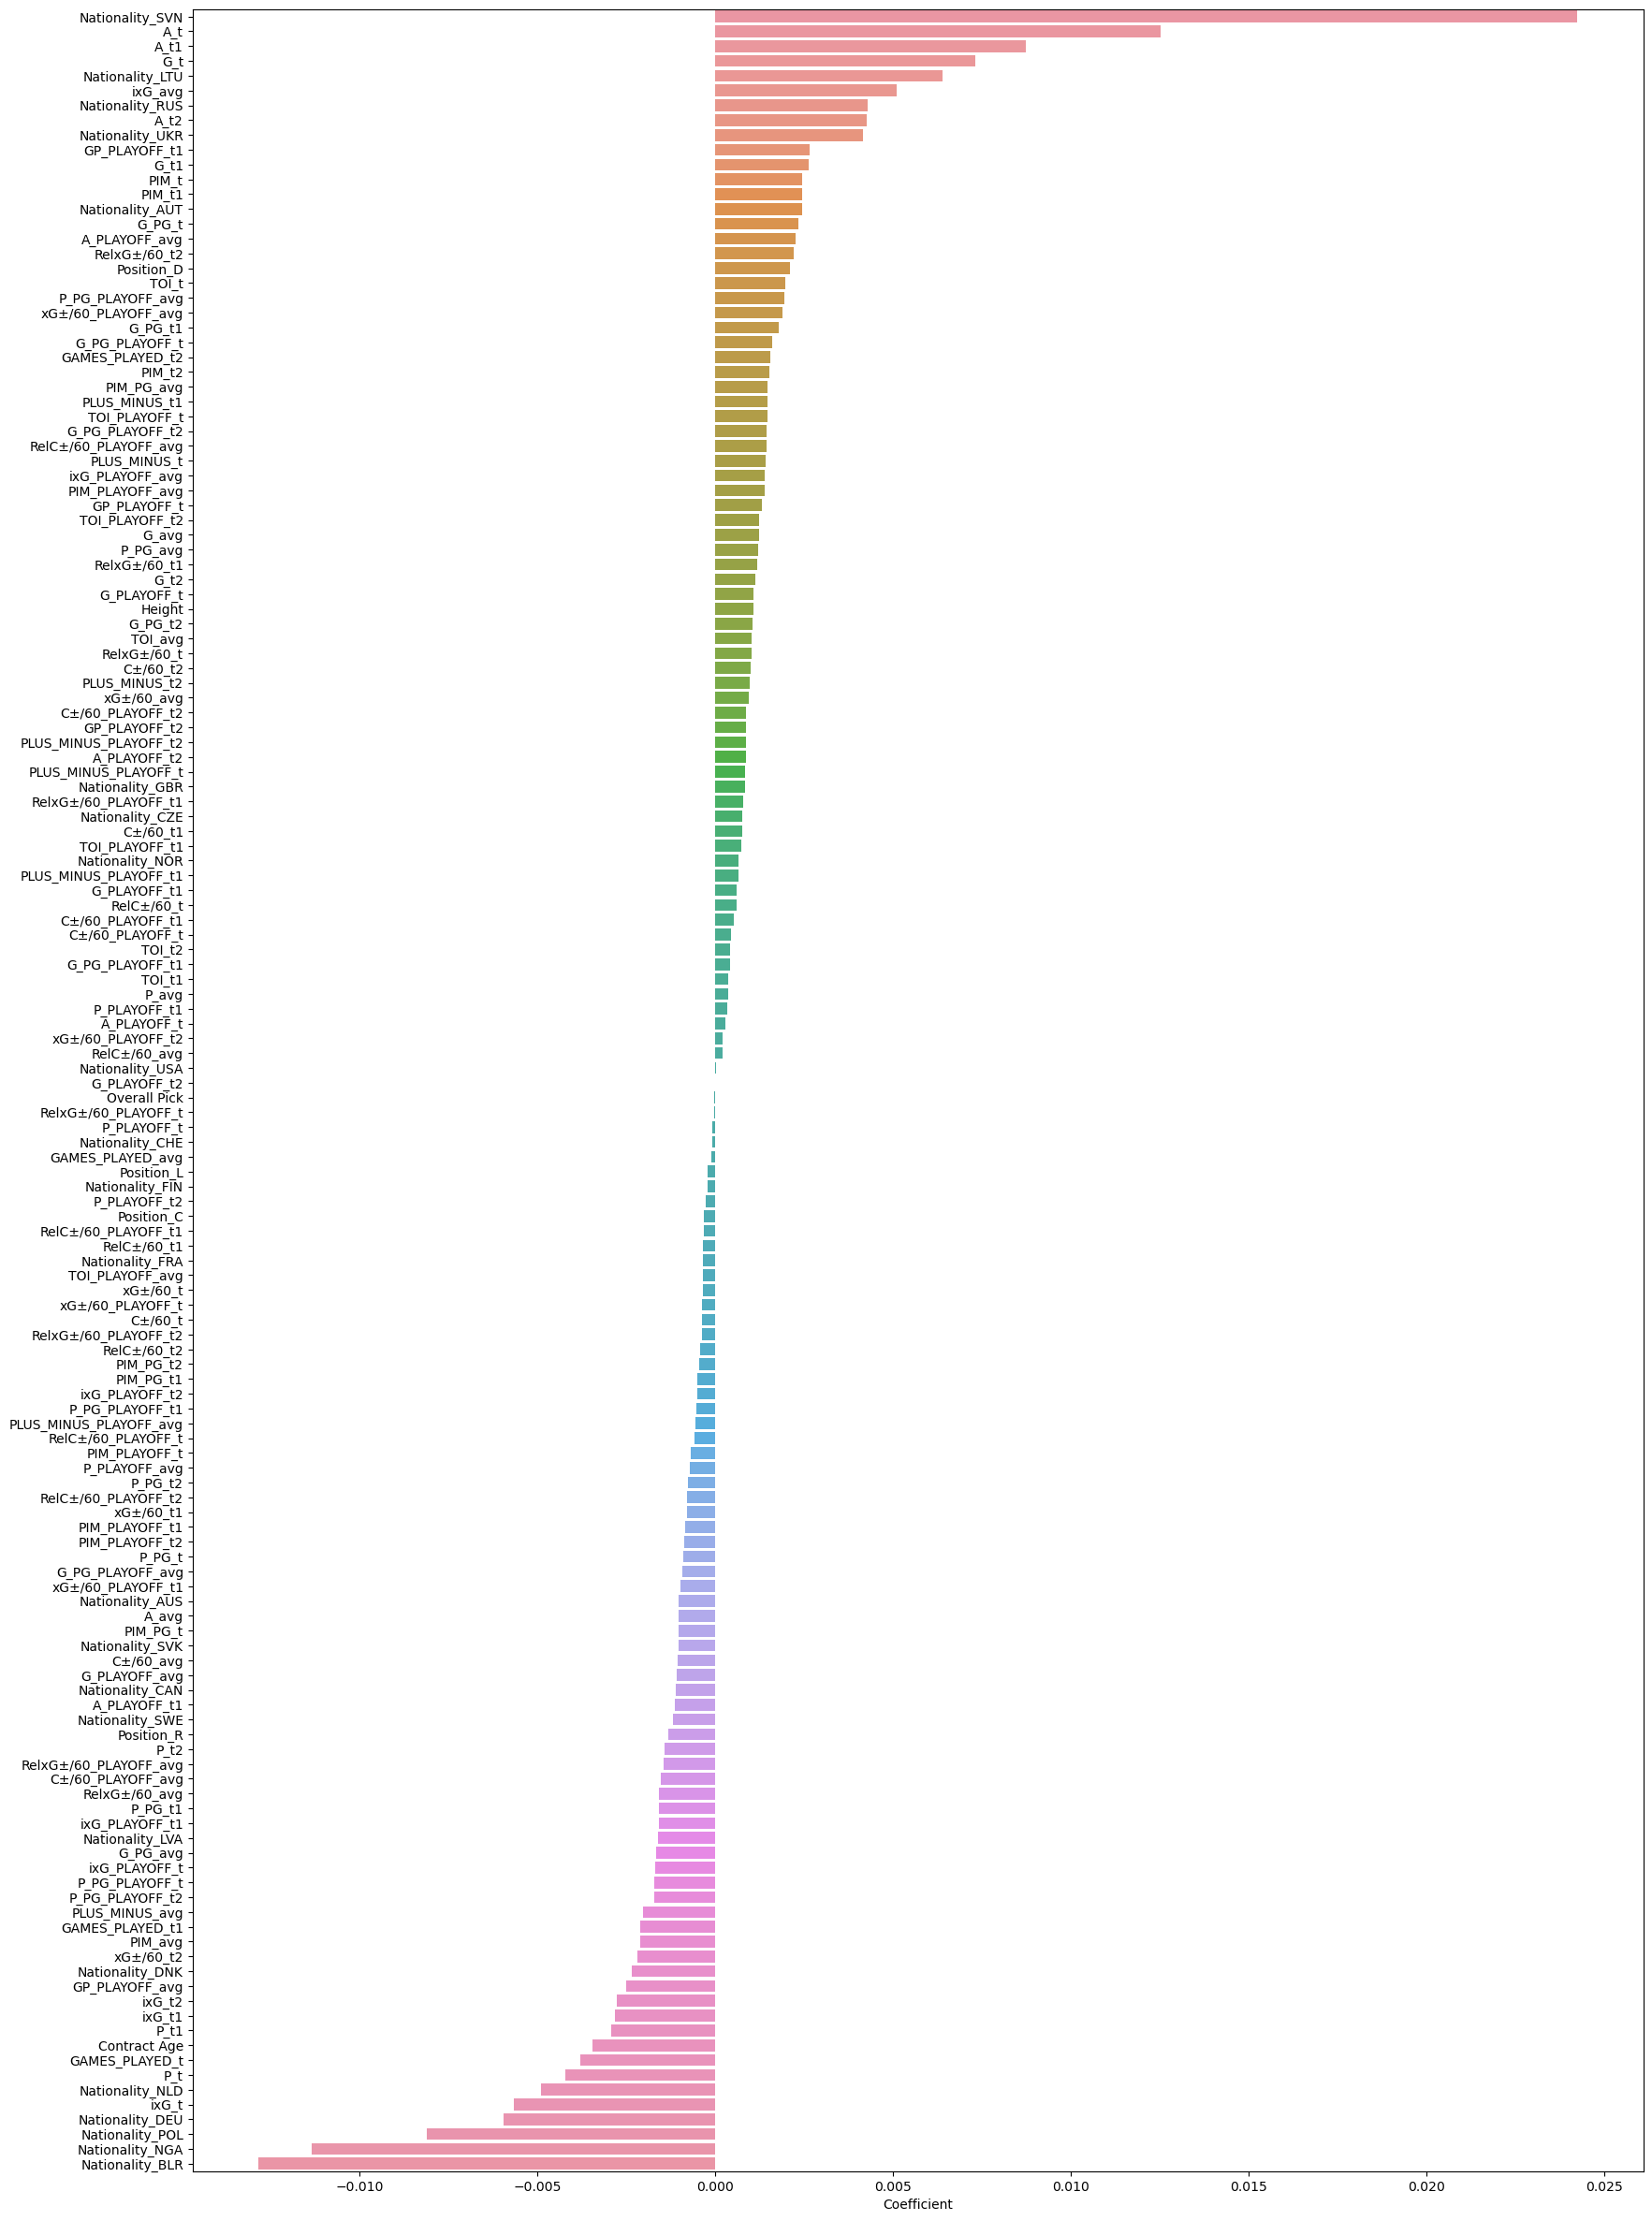

In [66]:
# get coefficients chart
eln_coef = pd.DataFrame(pd.Series(eln_final.coef_,index=eln_final.feature_names_in_)).sort_values(by=0,ascending=False)
eln_coef.columns = ['Coefficient']
fig,ax = plt.subplots(figsize=(20,30))
sns.barplot(y=eln_coef.index,x=eln_coef['Coefficient']);

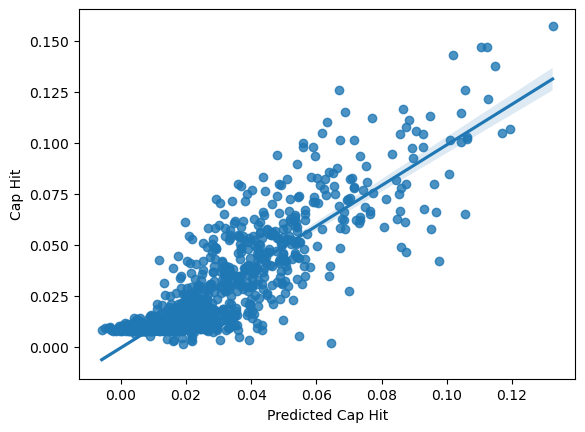

In [67]:
# plot true values vs residuals
sns.regplot(x=eln_predict,y=y_test);

Of interest regarding the elastic net model is that it performs basically as well as the ridge regression out-of-sample, suggesting that it is tilting the balance more towards a ridge regression model. Additionally, it brings more player nationality features into importance.

#### Decision Tree Regression

In [68]:
# initialize Decision Tree Regression
dtr = DecisionTreeRegressor(random_state=100)
dtr_parameters_1 = {'criterion':['squared_error','friedman_mse','absolute_error','poisson'],
                    'splitter': ['best'],
                    'max_depth':[1,5,10,20],
                    'min_samples_split':[1,3,5,7],
                    'max_features':['auto','sqrt','log2'],
                    'random_state': [100]}

In [69]:
# perform grid search
gs_dtr_1 = GridSearchCV(dtr,dtr_parameters_1,scoring='neg_mean_absolute_error',cv=5,verbose=False)
gs_dtr_1.fit(X_train,y_train)

GridSearchCV(cv=5, estimator=DecisionTreeRegressor(random_state=100),
             param_grid={'criterion': ['squared_error', 'friedman_mse',
                                       'absolute_error', 'poisson'],
                         'max_depth': [1, 5, 10, 20],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'min_samples_split': [1, 3, 5, 7],
                         'random_state': [100], 'splitter': ['best']},
             scoring='neg_mean_absolute_error', verbose=False)

In [70]:
gs_dtr_1.best_score_

-0.007624570904206586

In [71]:
gs_dtr_1.best_params_

{'criterion': 'squared_error',
 'max_depth': 5,
 'max_features': 'auto',
 'min_samples_split': 3,
 'random_state': 100,
 'splitter': 'best'}

In [72]:
# enhance grid search
dtr_parameters_2 = {'criterion':['squared_error','friedman_mse','absolute_error','poisson'],
                    'splitter': ['best','random'],
                    'max_depth':[2,5,8],
                    'min_samples_split':[1,3,5],
                    'max_features':['auto','sqrt','log2']}
gs_dtr_2 = GridSearchCV(dtr,dtr_parameters_2,scoring='neg_mean_absolute_error',cv=5,verbose=False)
gs_dtr_2.fit(X_train,y_train)

GridSearchCV(cv=5, estimator=DecisionTreeRegressor(random_state=100),
             param_grid={'criterion': ['squared_error', 'friedman_mse',
                                       'absolute_error', 'poisson'],
                         'max_depth': [2, 5, 8],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'min_samples_split': [1, 3, 5],
                         'splitter': ['best', 'random']},
             scoring='neg_mean_absolute_error', verbose=False)

In [73]:
gs_dtr_2.best_score_

-0.007624570904206586

In [74]:
gs_dtr_2.best_params_

{'criterion': 'squared_error',
 'max_depth': 5,
 'max_features': 'auto',
 'min_samples_split': 3,
 'splitter': 'best'}

In [75]:
# build final model using best params
dtr_final = DecisionTreeRegressor(criterion = 'squared_error',
                                  splitter = 'best',
                                  max_features = 'auto',
                                  max_depth = 5,
                                  min_samples_split = 3,
                                  random_state = 100)
dtr_final.fit(X_train,y_train)

DecisionTreeRegressor(max_depth=5, max_features='auto', min_samples_split=3,
                      random_state=100)

In [76]:
# get final model error
dtr_predict = pd.Series(dtr_final.predict(X_test))
dtr_predict.name = 'Predicted Cap Hit'
dtr_final_mae = mean_absolute_error(dtr_final.predict(X_test),y_test)
dtr_final_mae

0.00748234688382025

In [77]:
# add eln mae to dataframe
cap_hit_error.loc['Decision Tree Regression','Contract Annual Value'] = dtr_final_mae
cap_hit_error

Contract Annual Value
Ridge Regression                       0.008227
LASSO Regression                       0.009268
Elastic Net Regression                 0.008243
Decision Tree Regression               0.007482

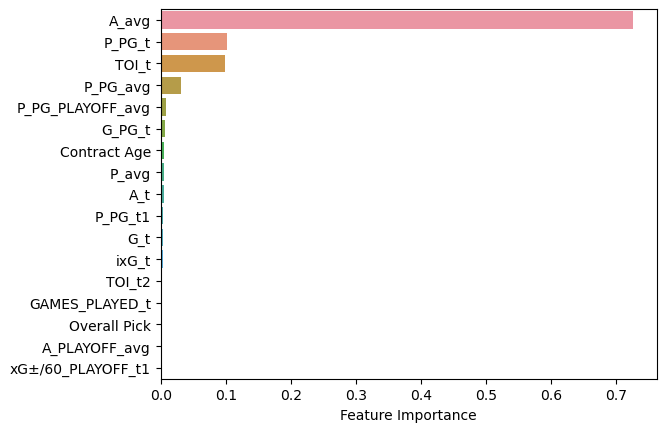

In [78]:
# get feature importance chart
dtr_featureImportance = pd.DataFrame(pd.Series(dtr_final.feature_importances_,
                                               index=dtr_final.feature_names_in_)).sort_values(by=0,ascending=False)
dtr_featureImportance.columns = ['Feature Importance']
dtr_featureImportance_sub = dtr_featureImportance[dtr_featureImportance['Feature Importance'] != 0]
sns.barplot(y=dtr_featureImportance_sub.index,x=dtr_featureImportance_sub['Feature Importance']);

The decision tree regression was the best performing model yet. Like the other models, it highlight assists over the reviewed period and in the contract year as important, but it also considers points per game and time on ice to be important predictors as well, as well as contract age.

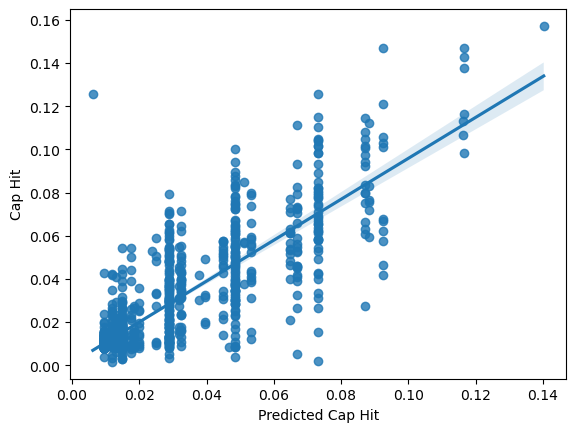

In [79]:
# plot true values vs residuals
sns.regplot(x=dtr_predict,y=y_test);

#### Random Forest Regression

In [80]:
# initialize Decision Tree Regression
rfr = RandomForestRegressor(random_state=100)
rfr_parameters_1 = {'n_estimators': [50,100,150],
                    'random_state': [100]}

In [81]:
# perform grid search
gs_rfr_1 = GridSearchCV(rfr,rfr_parameters_1,scoring='neg_mean_absolute_error',cv=5,verbose=False)
gs_rfr_1.fit(X_train,y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=100),
             param_grid={'n_estimators': [50, 100, 150], 'random_state': [100]},
             scoring='neg_mean_absolute_error', verbose=False)

In [82]:
gs_rfr_1.best_score_

-0.00621784391092376

In [83]:
gs_rfr_1.best_params_

{'n_estimators': 150, 'random_state': 100}

In [84]:
# enhance grid search
rfr_parameters_2 = {'n_estimators':[150,200,250]}
gs_rfr_2 = GridSearchCV(rfr,rfr_parameters_2,scoring='neg_mean_absolute_error',cv=5,verbose=False)
gs_rfr_2.fit(X_train,y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=100),
             param_grid={'n_estimators': [150, 200, 250]},
             scoring='neg_mean_absolute_error', verbose=False)

In [85]:
gs_rfr_2.best_score_

-0.006207779374606638

In [86]:
gs_rfr_2.best_params_

{'n_estimators': 250}

In [87]:
# build final model using best params
rfr_final = RandomForestRegressor(n_estimators=250,random_state=100)
rfr_final.fit(X_train,y_train)

RandomForestRegressor(n_estimators=250, random_state=100)

In [88]:
# get final model error
rfr_predict = pd.Series(rfr_final.predict(X_test))
rfr_predict.name = 'Predicted Cap Hit'
rfr_final_mae = mean_absolute_error(rfr_final.predict(X_test),y_test)
rfr_final_mae

0.005835608826601329

In [89]:
# add rfr mae to dataframe
cap_hit_error.loc['Random Forest Regression','Contract Annual Value'] = rfr_final_mae
cap_hit_error

Contract Annual Value
Ridge Regression                       0.008227
LASSO Regression                       0.009268
Elastic Net Regression                 0.008243
Decision Tree Regression               0.007482
Random Forest Regression               0.005836

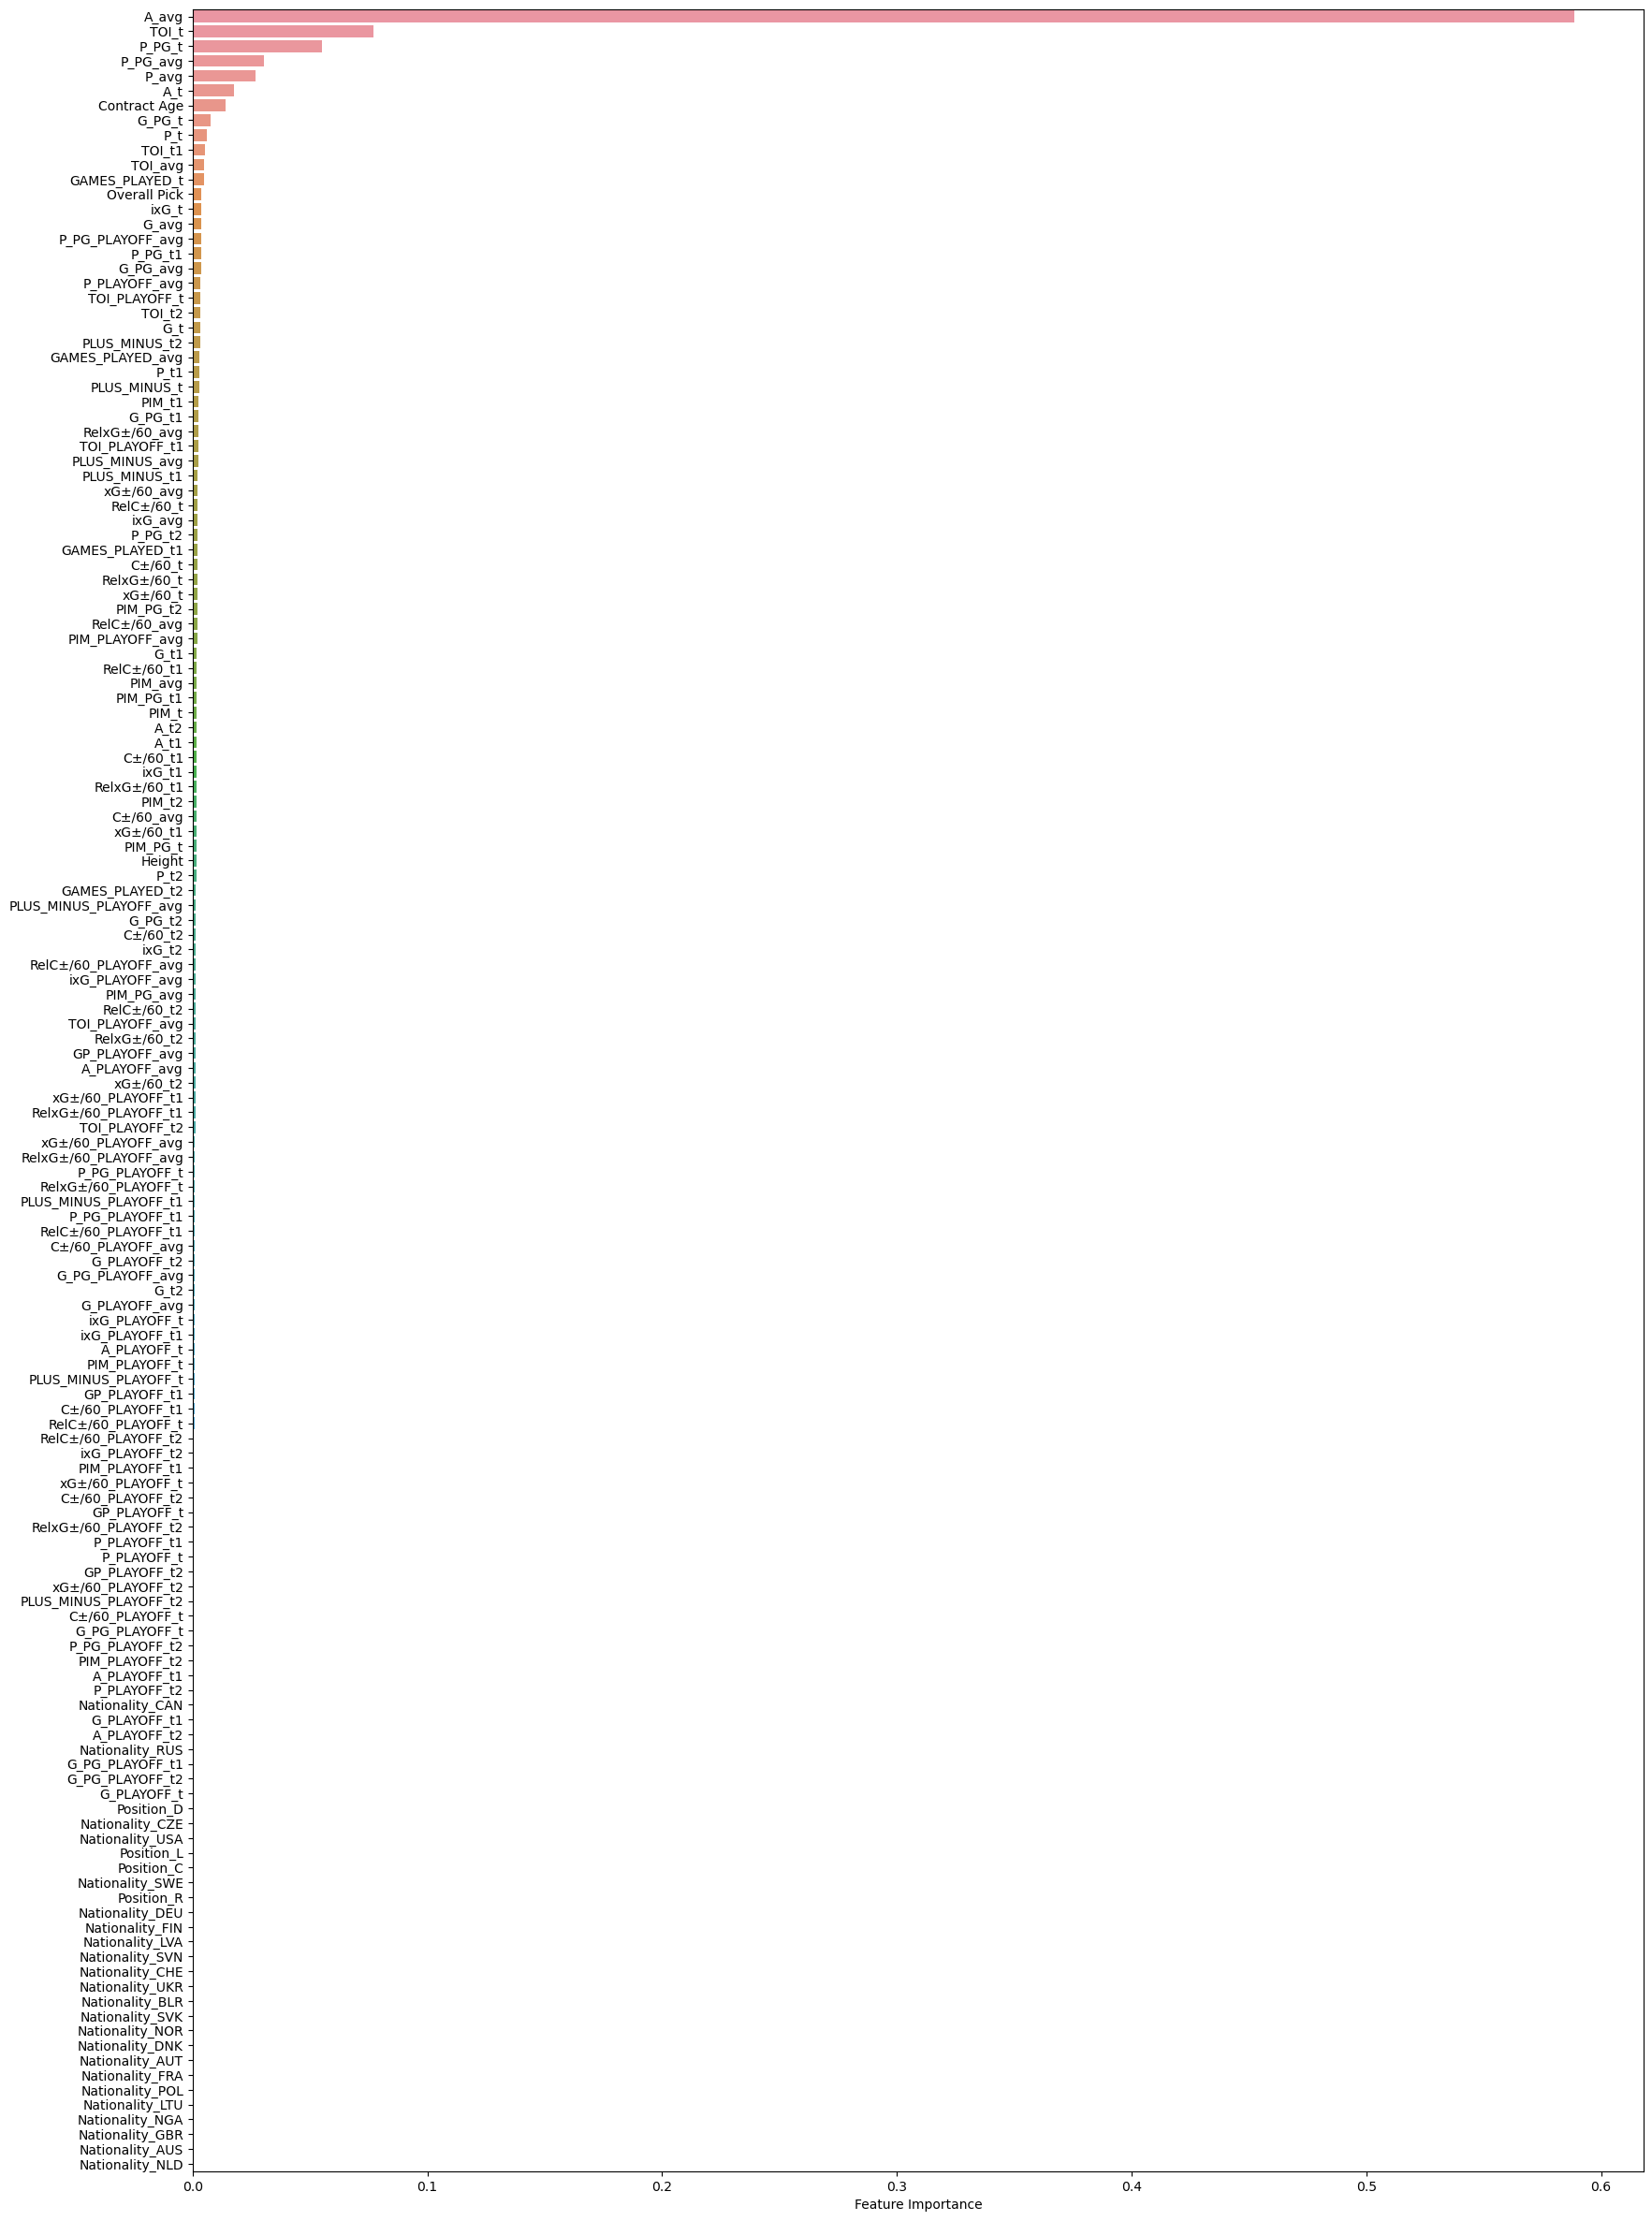

In [90]:
# get feature importance chart
rfr_featureImportance = pd.DataFrame(pd.Series(rfr_final.feature_importances_,
                                               index=rfr_final.feature_names_in_)).sort_values(by=0,ascending=False)
rfr_featureImportance.columns = ['Feature Importance']
rfr_featureImportance_sub = rfr_featureImportance[rfr_featureImportance['Feature Importance'] != 0]
fig,ax = plt.subplots(figsize=(20,30))
sns.barplot(y=rfr_featureImportance_sub.index,x=rfr_featureImportance_sub['Feature Importance']);

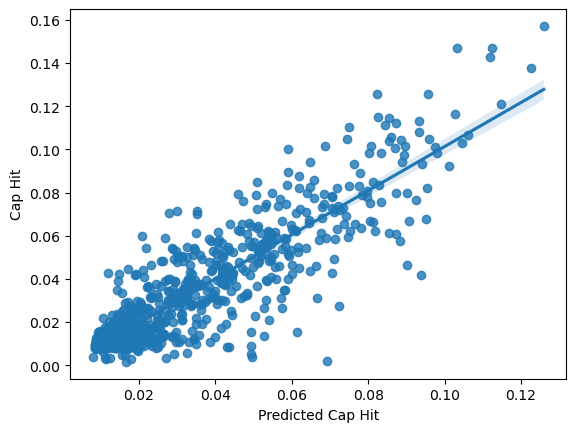

In [91]:
# plot true values vs residuals
sns.regplot(x=rfr_predict,y=y_test);

Looking at the feature importances in the random forest regression, we can see that the top ones are similar to those of decision tree regression, namely assists and points per game.

#### XGBoost Regression

In [92]:
# initialize XGBoost Regression
xgbr = XGBRegressor(random_state=100)
xgbr_parameters_1 = {'learning_rate': [0.05,0.10,0.15],
                     'max_depth': [2,5,10],
                     'min_child_weight': [1,3,5],
                     'n_estimators': [20,40,80],
                     'tree_method': ['exact','approx','hist'],
                     'random_state': [100]}

In [93]:
# perform grid search
gs_xgbr_1 = GridSearchCV(xgbr,xgbr_parameters_1,scoring='neg_mean_absolute_error',cv=5,verbose=False)
gs_xgbr_1.fit(X_train,y_train)

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None, gpu_id=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None, n_estimators=100,
                                    n_jobs=None, num_parallel_tree=None,
                                    predictor=None, random_state=100, ...),
             param_grid={'learning_rate': [0.05, 0.1, 0.15],
                         'max_depth': [2, 5, 10], 'min_child_weight': [1, 3, 5],
                         'n_estimators': [20, 40, 80], 'random_state': [100],
                         'tree_method': ['exact', 'approx', 'hist']},
             scoring='neg_mean_absolute_error', verbose=False)

In [94]:
gs_xgbr_1.best_score_

-0.006209183166042251

In [95]:
gs_xgbr_1.best_params_

{'learning_rate': 0.1,
 'max_depth': 10,
 'min_child_weight': 3,
 'n_estimators': 80,
 'random_state': 100,
 'tree_method': 'approx'}

In [96]:
# enhance grid search
xgbr_parameters_2 = {'learning_rate': [0.10],
                     'max_depth': [5,10,15],
                     'min_child_weight': [1,3,5],
                     'n_estimators': [50,80,100],
                     'tree_method': ['exact','approx'],
                     'random_state': [100]}
gs_xgbr_2 = GridSearchCV(xgbr,xgbr_parameters_2,scoring='neg_mean_absolute_error',cv=5,verbose=False)
gs_xgbr_2.fit(X_train,y_train)

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None, gpu_id=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None, n_estimators=100,
                                    n_jobs=None, num_parallel_tree=None,
                                    predictor=None, random_state=100, ...),
             param_grid={'learning_rate': [0.1], 'max_depth': [5, 10, 15],
                         'min_child_weight': [1, 3, 5],
                         'n_estimators': [50, 80, 100], 'random_state': [100],
                         'tree_method': ['exact', 'approx']},
             scoring='neg_mean_absolute_error', verbose=False)

In [97]:
gs_xgbr_2.best_score_

-0.006197092023278092

In [98]:
gs_xgbr_2.best_params_

{'learning_rate': 0.1,
 'max_depth': 10,
 'min_child_weight': 3,
 'n_estimators': 100,
 'random_state': 100,
 'tree_method': 'approx'}

In [99]:
# enhance grid search
xgbr_parameters_3 = {'learning_rate': [0.10],
                     'max_depth': [8,10,12],
                     'min_child_weight': [1,3,5],
                     'n_estimators': [85,100,115],
                     'tree_method': ['exact','approx'],
                     'random_state': [100]}
gs_xgbr_3 = GridSearchCV(xgbr,xgbr_parameters_3,scoring='neg_mean_absolute_error',cv=5,verbose=False)
gs_xgbr_3.fit(X_train,y_train)

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None, gpu_id=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None, n_estimators=100,
                                    n_jobs=None, num_parallel_tree=None,
                                    predictor=None, random_state=100, ...),
             param_grid={'learning_rate': [0.1], 'max_depth': [8, 10, 12],
                         'min_child_weight': [1, 3, 5],
                         'n_estimators': [85, 100, 115], 'random_state': [100],
                         'tree_method': ['exact', 'approx']},
             scoring='neg_mean_absolute_error', verbose=False)

In [100]:
gs_xgbr_3.best_score_

-0.006195890671718334

In [101]:
gs_xgbr_3.best_params_

{'learning_rate': 0.1,
 'max_depth': 8,
 'min_child_weight': 5,
 'n_estimators': 100,
 'random_state': 100,
 'tree_method': 'approx'}

In [102]:
# enhance grid search
xgbr_parameters_4 = {'learning_rate': [0.10],
                     'max_depth': [5,8,10],
                     'min_child_weight': [1,3,5,8],
                     'n_estimators': [85,100,115],
                     'tree_method': ['approx'],
                     'random_state': [100]}
gs_xgbr_4 = GridSearchCV(xgbr,xgbr_parameters_4,scoring='neg_mean_absolute_error',cv=5,verbose=False)
gs_xgbr_4.fit(X_train,y_train)

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None, gpu_id=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None, n_estimators=100,
                                    n_jobs=None, num_parallel_tree=None,
                                    predictor=None, random_state=100, ...),
             param_grid={'learning_rate': [0.1], 'max_depth': [5, 8, 10],
                         'min_child_weight': [1, 3, 5, 8],
                         'n_estimators': [85, 100, 115], 'random_state': [100],
                         'tree_method': ['approx']},
             scoring='neg_mean_absolute_error', verbose=False)

In [103]:
gs_xgbr_4.best_score_

-0.006195890671718334

In [104]:
gs_xgbr_4.best_params_

{'learning_rate': 0.1,
 'max_depth': 8,
 'min_child_weight': 5,
 'n_estimators': 100,
 'random_state': 100,
 'tree_method': 'approx'}

In [105]:
# build final model using best params
xgbr_final = XGBRegressor(learning_rate=0.1,
                          max_depth=8,
                          min_child_weight=5,
                          n_estimators=100,
                          tree_method='approx',
                          random_state=100)
xgbr_final.fit(X_train,y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=8, max_leaves=None,
             min_child_weight=5, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=100, ...)

In [106]:
# get final model error
xgbr_predict = pd.Series(xgbr_final.predict(X_test))
xgbr_predict.name = 'Predicted Cap Hit'
xgbr_final_mae = mean_absolute_error(xgbr_final.predict(X_test),y_test)
xgbr_final_mae

0.005942633175990111

In [107]:
# add xgbr mae to dataframe
cap_hit_error.loc['XGBoost Regression','Contract Annual Value'] = xgbr_final_mae
cap_hit_error

Contract Annual Value
Ridge Regression                       0.008227
LASSO Regression                       0.009268
Elastic Net Regression                 0.008243
Decision Tree Regression               0.007482
Random Forest Regression               0.005836
XGBoost Regression                     0.005943

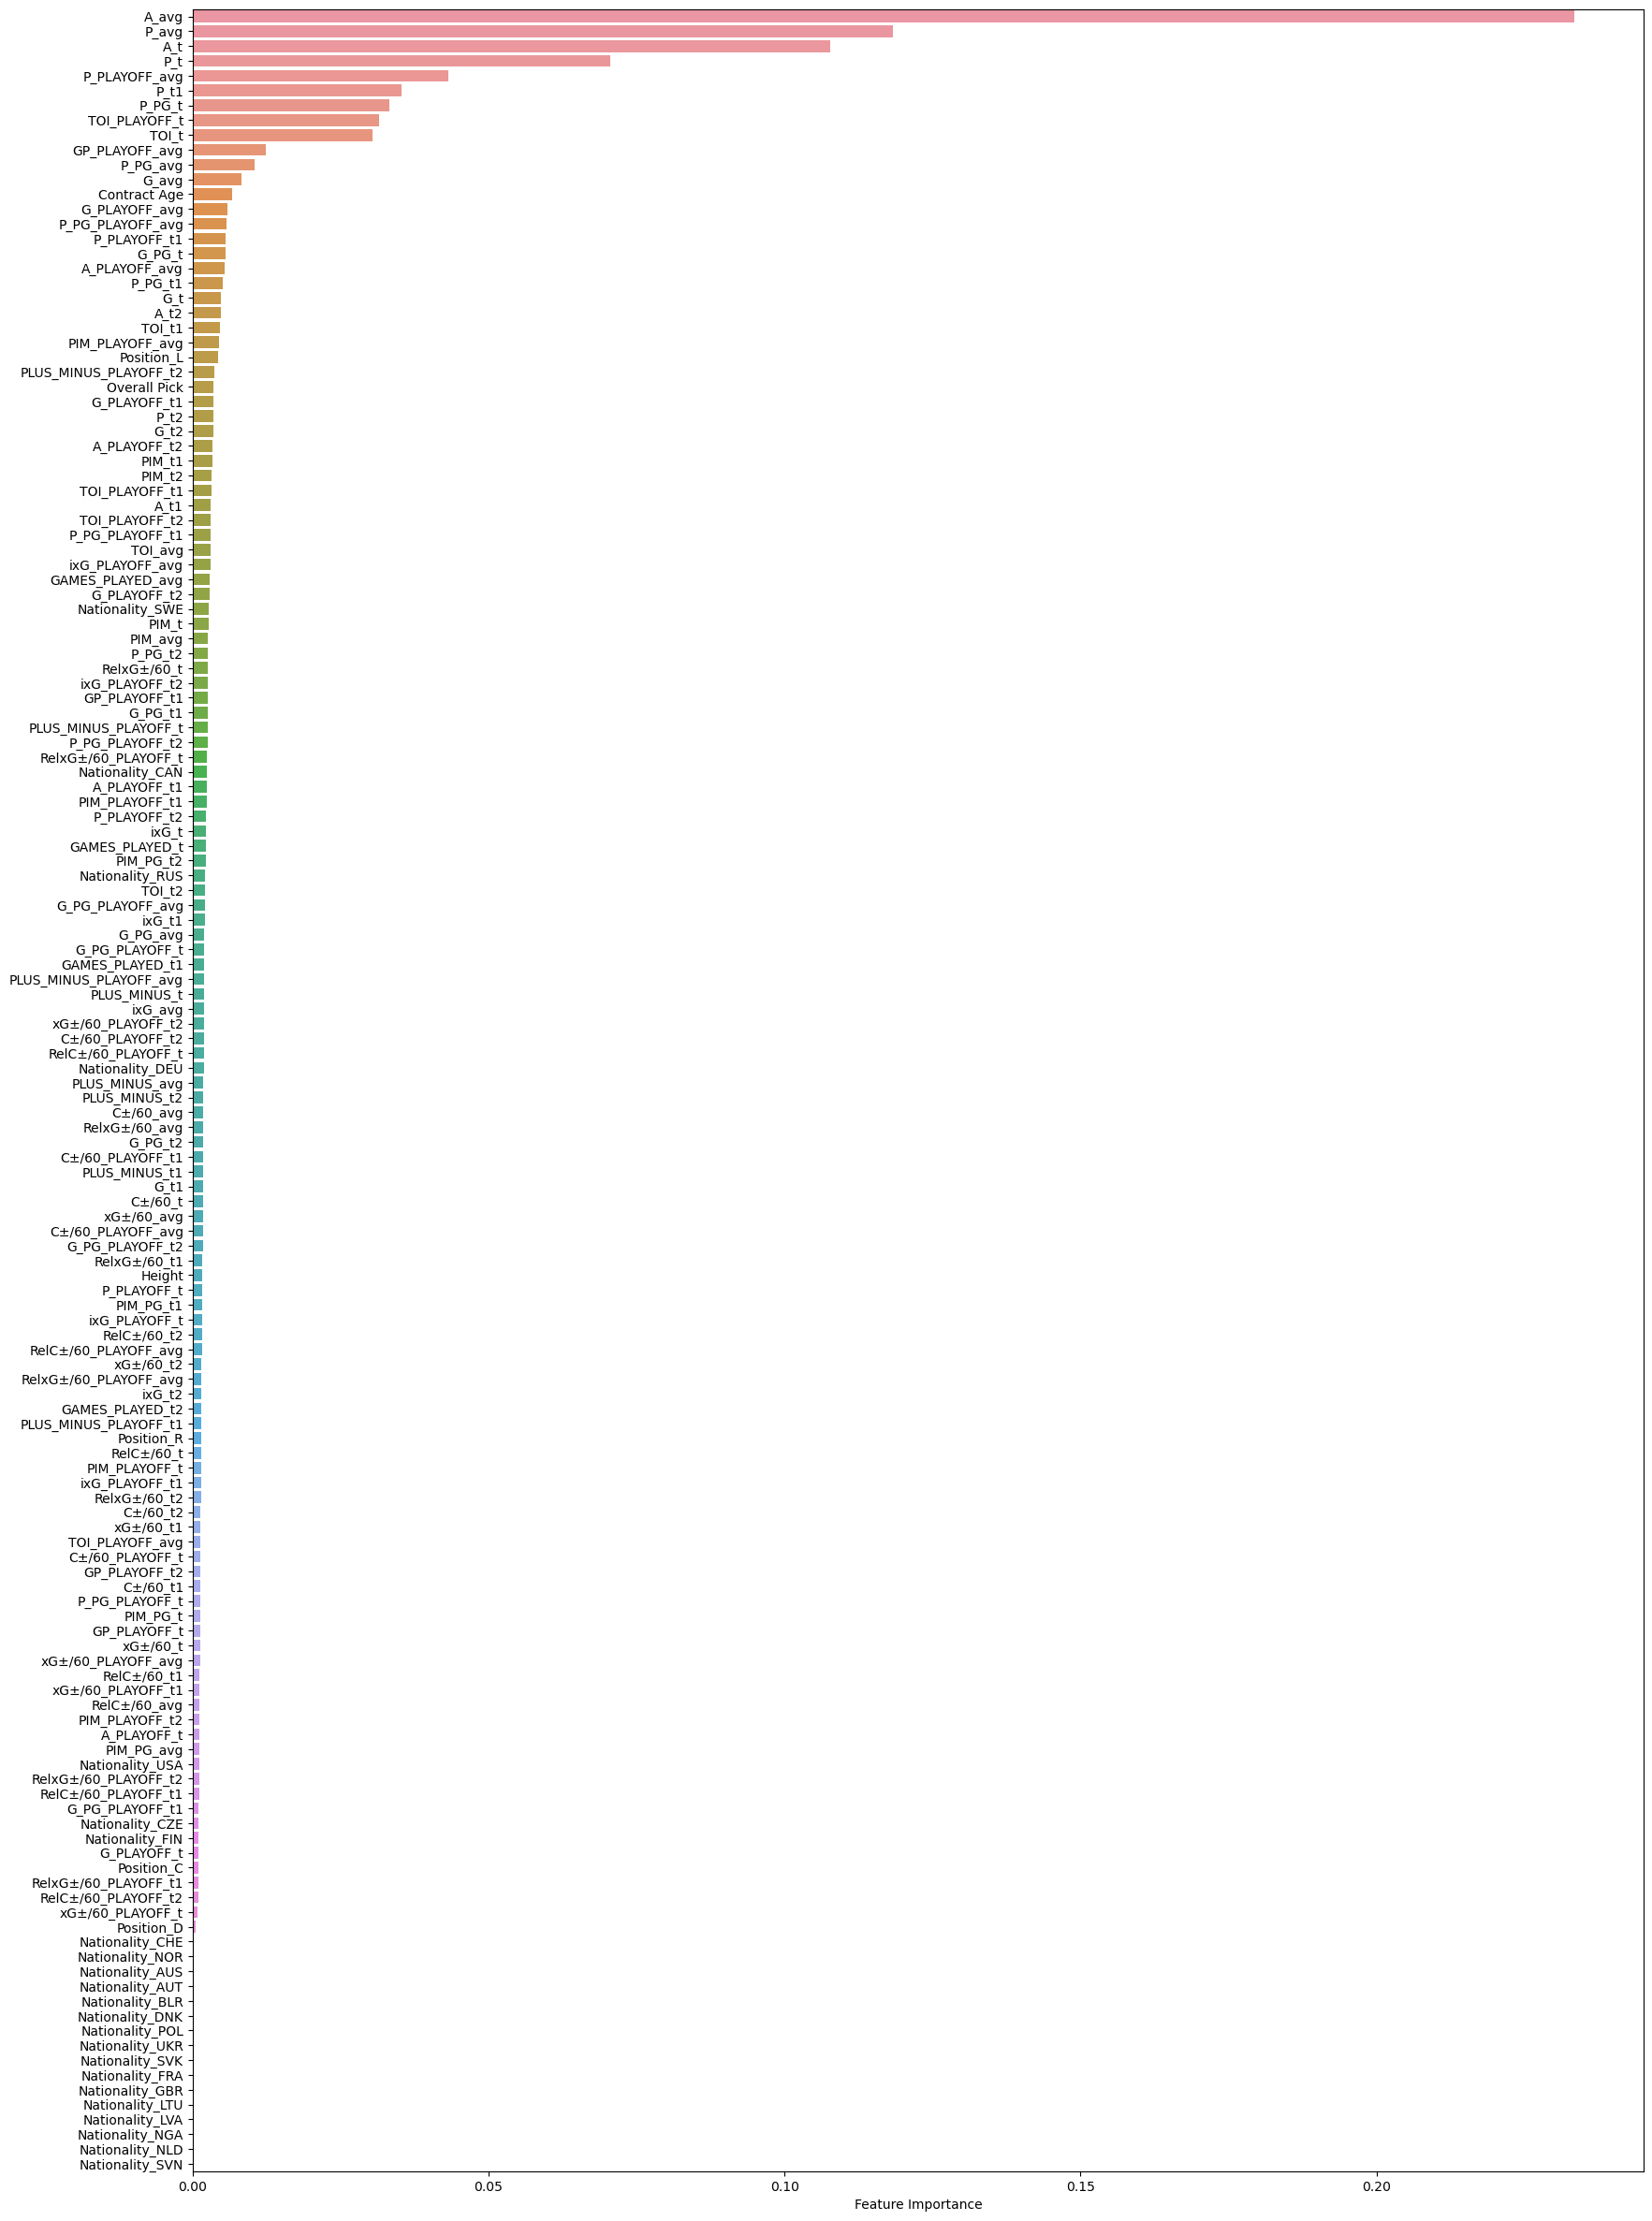

In [219]:
# get feature importance chart
xgbr_featureImportance = pd.DataFrame(pd.Series(xgbr_final.feature_importances_,
                                                index=xgbr_final.feature_names_in_)).sort_values(by=0,ascending=False)
xgbr_featureImportance.columns = ['Feature Importance']
fig,ax = plt.subplots(figsize=(20,30))
sns.barplot(y=xgbr_featureImportance.index,x=xgbr_featureImportance['Feature Importance']);

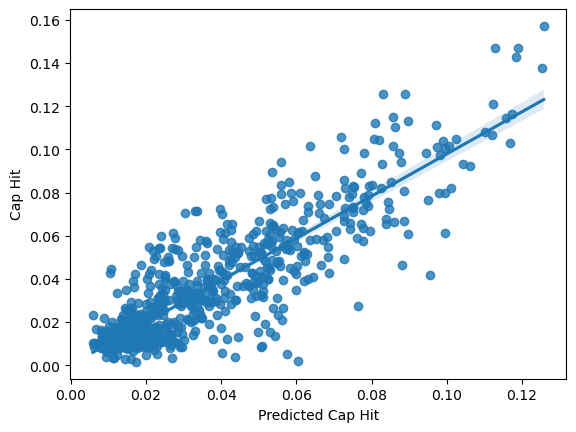

In [109]:
# plot true values vs residuals
sns.regplot(x=xgbr_predict,y=y_test);

Looking at feature importance for the XGBoost regression, we see that the most important features are in line with what the other models have suggested: points and assists, followed by points per game and time on ice. Additionally, it considers a couple more playoff-based features, which suggests that playoff experience pays off in obtaining higher annual payment.

### Contract Length Modelling

#### Ridge Regression

In [110]:
# initialize ridge regression and parameters
ridge_l = linear_model.Ridge(random_state=100)
ridge_l_parameters = {'alpha': np.concatenate((np.arange(0.005,2,0.005),np.arange(2,5,0.5),np.arange(5,25,1))),
                      'positive': [True,False],
                      'fit_intercept': [True,False],
                      'random_state' : [100]}

In [111]:
# perform grid search
gs_ridge_l = GridSearchCV(ridge_l,ridge_l_parameters,scoring='neg_mean_absolute_error',cv=5,verbose=False)
gs_ridge_l.fit(X_train,y_l_train)

GridSearchCV(cv=5, estimator=Ridge(random_state=100),
             param_grid={'alpha': array([5.000e-03, 1.000e-02, 1.500e-02, 2.000e-02, 2.500e-02, 3.000e-02,
       3.500e-02, 4.000e-02, 4.500e-02, 5.000e-02, 5.500e-02, 6.000e-02,
       6.500e-02, 7.000e-02, 7.500e-02, 8.000e-02, 8.500e-02, 9.000e-02,
       9.500e-02, 1.000e-01, 1.050e-01, 1.100e-01, 1.150e-01, 1.200e-01,
       1.250e-01, 1.300e-01, 1.350e-01, 1...
       3.500e+00, 4.000e+00, 4.500e+00, 5.000e+00, 6.000e+00, 7.000e+00,
       8.000e+00, 9.000e+00, 1.000e+01, 1.100e+01, 1.200e+01, 1.300e+01,
       1.400e+01, 1.500e+01, 1.600e+01, 1.700e+01, 1.800e+01, 1.900e+01,
       2.000e+01, 2.100e+01, 2.200e+01, 2.300e+01, 2.400e+01]),
                         'fit_intercept': [True, False],
                         'positive': [True, False], 'random_state': [100]},
             scoring='neg_mean_absolute_error', verbose=False)

In [112]:
gs_ridge_l.best_score_

-0.8870264424135736

In [113]:
gs_ridge_l.best_params_

{'alpha': 24.0, 'fit_intercept': False, 'positive': False, 'random_state': 100}

In [114]:
# build final model using best params
ridge_l_final = linear_model.Ridge(alpha=24,fit_intercept=True,positive=False,random_state=100)
ridge_l_final.fit(X_train,y_l_train)

Ridge(alpha=24, random_state=100)

In [115]:
# get final model error
ridge_l_predict = pd.Series(ridge_l_final.predict(X_test))
ridge_l_predict.name = 'Predicted Length'
ridge_l_final_mae = mean_absolute_error(ridge_l_final.predict(X_test),y_l_test)
ridge_l_final_mae

0.8685447552554005

In [116]:
# add ridge mae to dataframe
cap_hit_error.loc['Ridge Regression','Contract Length'] = ridge_l_final_mae
cap_hit_error

Contract Annual Value  Contract Length
Ridge Regression                       0.008227         0.868545
LASSO Regression                       0.009268              NaN
Elastic Net Regression                 0.008243              NaN
Decision Tree Regression               0.007482              NaN
Random Forest Regression               0.005836              NaN
XGBoost Regression                     0.005943              NaN

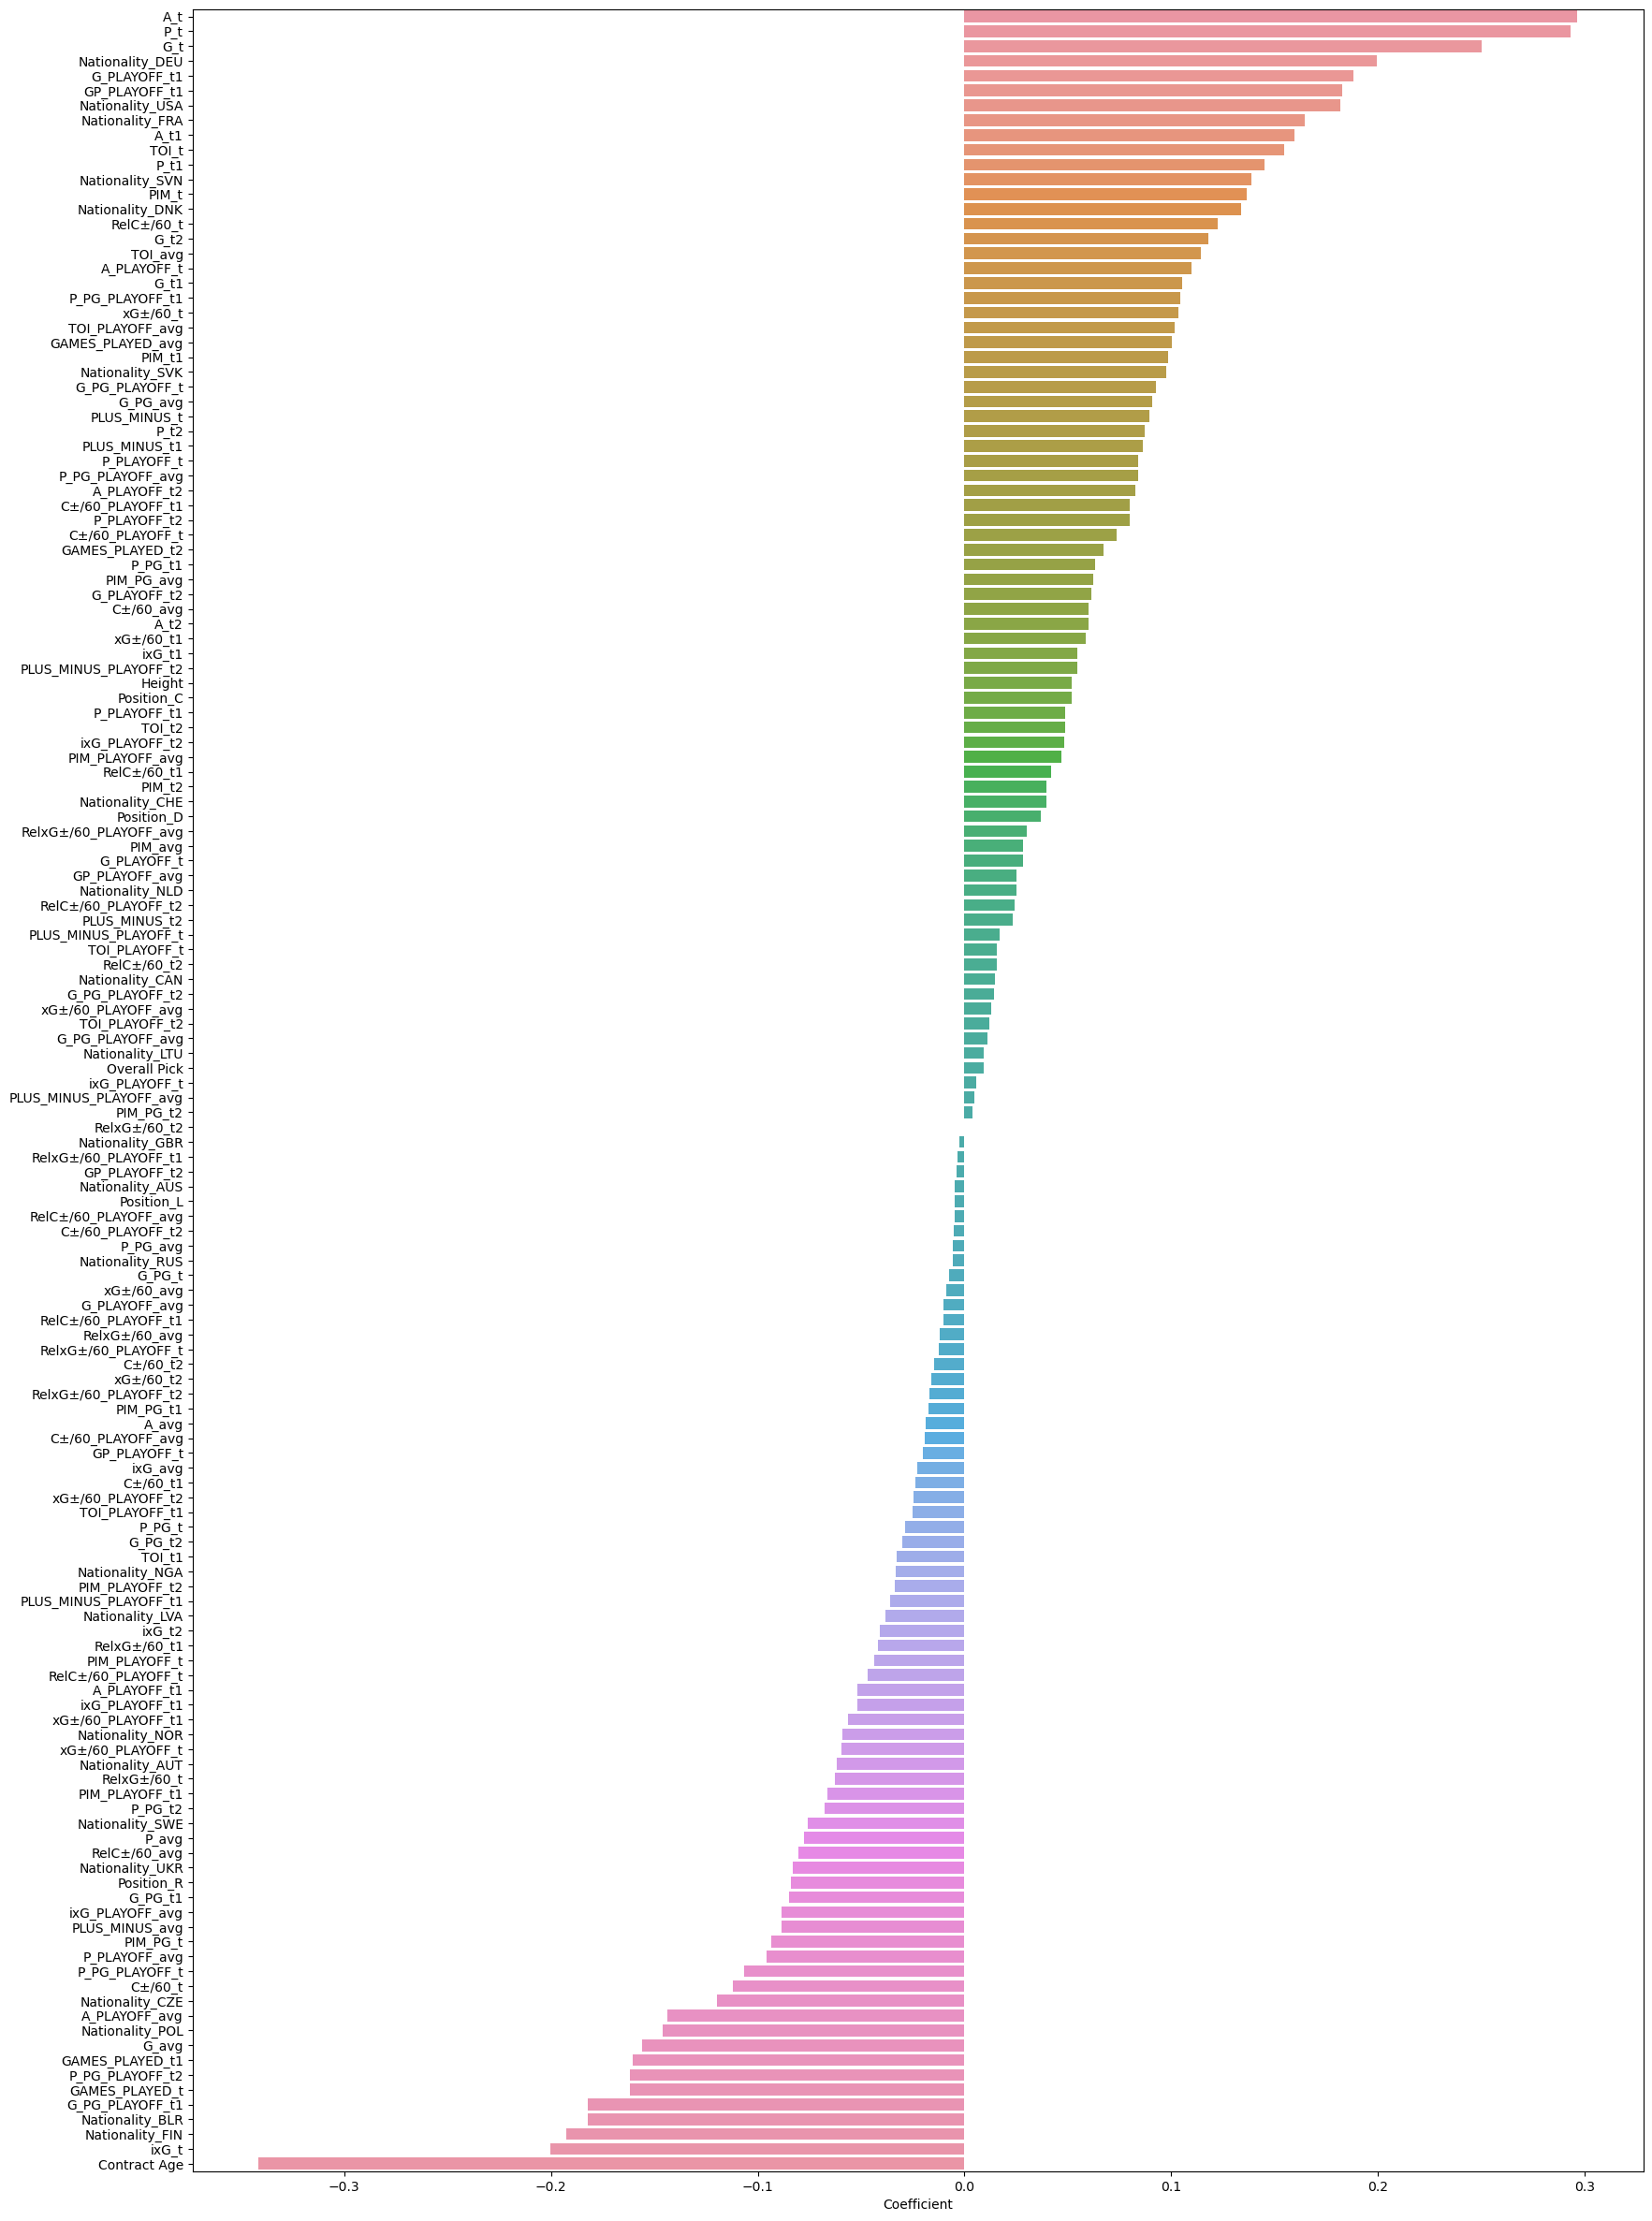

In [117]:
# get coefficients chart
ridge_l_coef = pd.DataFrame(pd.Series(ridge_l_final.coef_,
                                      index=ridge_l_final.feature_names_in_)).sort_values(by=0,ascending=False)
ridge_l_coef.columns = ['Coefficient']
fig,ax = plt.subplots(figsize=(20,30))
sns.barplot(y=ridge_l_coef.index,x=ridge_l_coef['Coefficient']);

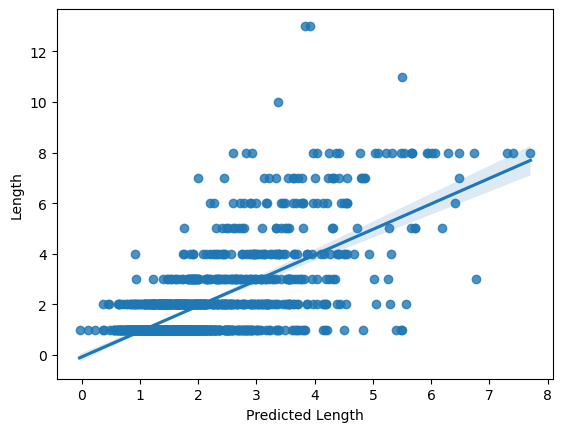

In [118]:
# plot true values vs residuals
sns.regplot(x=ridge_l_predict,y=y_l_test);

The ridge regression highlights similar features as it did when trying to predict contract annual value: assists, points, goals, and TOI. It also attributes a large negative coefficient to contract age, which is expected to some extent; we would think that as players get older, the likelihood that they will sign a longer contract decreases.

#### LASSO

In [119]:
# initialize LASSO
lasso_l = linear_model.Lasso(random_state=100)
lasso_l_parameters = {'alpha': np.concatenate((np.arange(0.005,2,0.005),np.arange(2,5,0.5),np.arange(5,25,1))),
                      'positive': [True,False],
                      'fit_intercept': [True,False],
                      'random_state': [100]}

In [120]:
# perform grid search
gs_l_lasso = GridSearchCV(lasso_l,lasso_l_parameters,scoring='neg_mean_absolute_error',cv=5,verbose=False)
gs_l_lasso.fit(X_train,y_l_train)

GridSearchCV(cv=5, estimator=Lasso(random_state=100),
             param_grid={'alpha': array([5.000e-03, 1.000e-02, 1.500e-02, 2.000e-02, 2.500e-02, 3.000e-02,
       3.500e-02, 4.000e-02, 4.500e-02, 5.000e-02, 5.500e-02, 6.000e-02,
       6.500e-02, 7.000e-02, 7.500e-02, 8.000e-02, 8.500e-02, 9.000e-02,
       9.500e-02, 1.000e-01, 1.050e-01, 1.100e-01, 1.150e-01, 1.200e-01,
       1.250e-01, 1.300e-01, 1.350e-01, 1...
       3.500e+00, 4.000e+00, 4.500e+00, 5.000e+00, 6.000e+00, 7.000e+00,
       8.000e+00, 9.000e+00, 1.000e+01, 1.100e+01, 1.200e+01, 1.300e+01,
       1.400e+01, 1.500e+01, 1.600e+01, 1.700e+01, 1.800e+01, 1.900e+01,
       2.000e+01, 2.100e+01, 2.200e+01, 2.300e+01, 2.400e+01]),
                         'fit_intercept': [True, False],
                         'positive': [True, False], 'random_state': [100]},
             scoring='neg_mean_absolute_error', verbose=False)

In [121]:
gs_l_lasso.best_score_

-0.8741612046397165

In [122]:
gs_l_lasso.best_params_

{'alpha': 0.015,
 'fit_intercept': False,
 'positive': False,
 'random_state': 100}

In [123]:
# build final model using best params
lasso_l_final = linear_model.Lasso(alpha=0.015,fit_intercept=False,positive=False,random_state=100)
lasso_l_final.fit(X_train,y_l_train)

Lasso(alpha=0.015, fit_intercept=False, random_state=100)

In [124]:
# get final model error
lasso_l_predict = pd.Series(lasso_l_final.predict(X_test))
lasso_l_predict.name = 'Predicted Length'
lasso_l_final_mae = mean_absolute_error(lasso_l_final.predict(X_test),y_l_test)
lasso_l_final_mae

0.8498360515779672

In [125]:
# add lasso mae to dataframe
cap_hit_error.loc['LASSO Regression','Contract Length'] = lasso_l_final_mae
cap_hit_error

Contract Annual Value  Contract Length
Ridge Regression                       0.008227         0.868545
LASSO Regression                       0.009268         0.849836
Elastic Net Regression                 0.008243              NaN
Decision Tree Regression               0.007482              NaN
Random Forest Regression               0.005836              NaN
XGBoost Regression                     0.005943              NaN

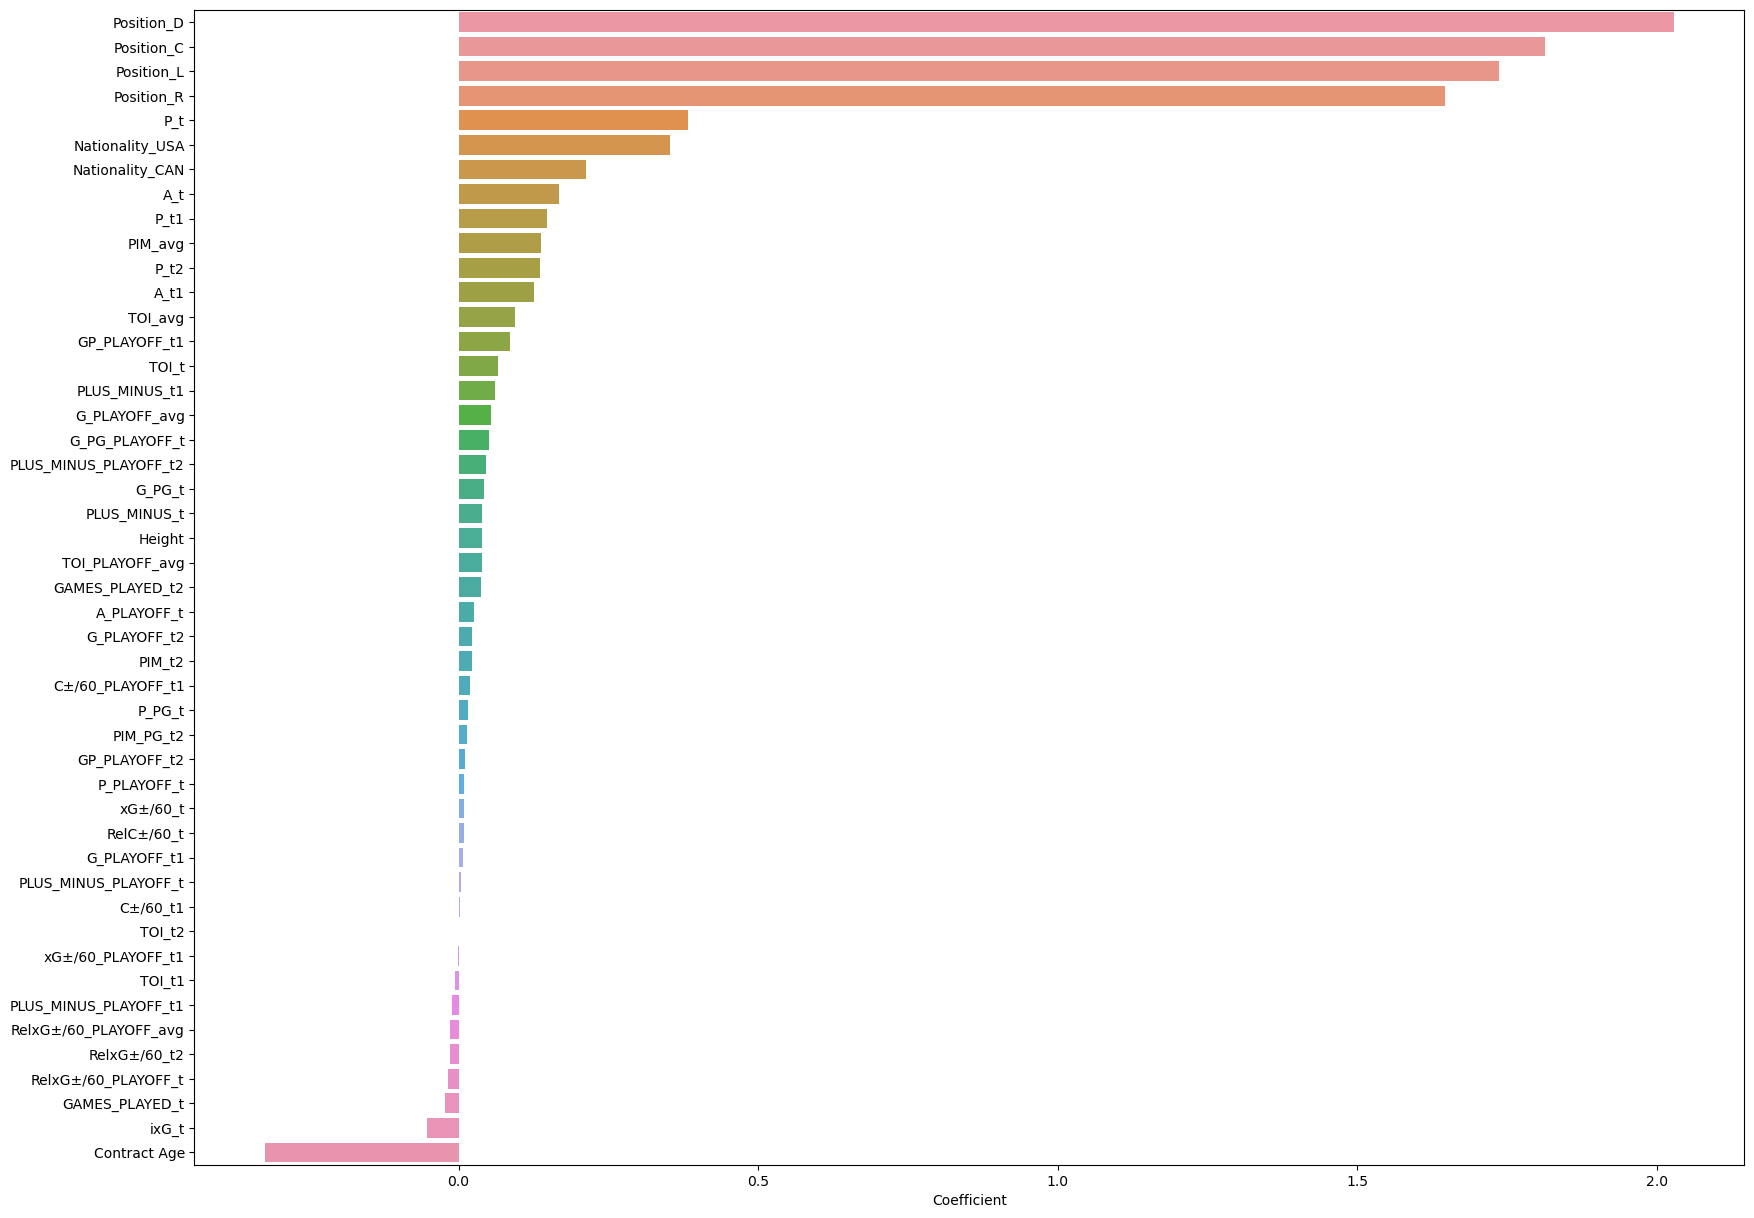

In [126]:
# get coefficients chart
lasso_l_coef = pd.DataFrame(pd.Series(lasso_l_final.coef_,
                                      index=lasso_l_final.feature_names_in_)).sort_values(by=0,ascending=False)
lasso_l_coef.columns = ['Coefficient']
lasso_l_coef_sub = lasso_l_coef[lasso_l_coef['Coefficient'] != 0]
fig,ax = plt.subplots(figsize=(20,15))
sns.barplot(y=lasso_l_coef_sub.index,x=lasso_l_coef_sub['Coefficient']);

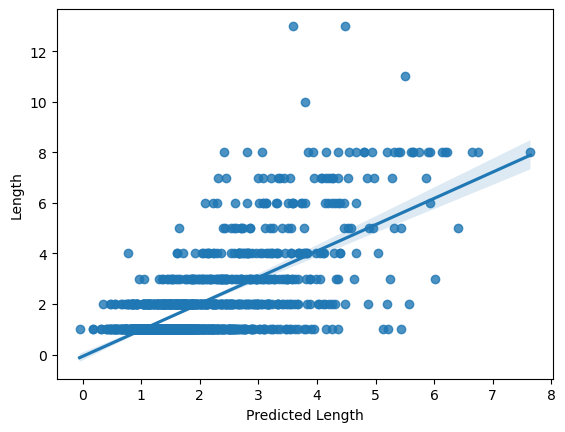

In [127]:
# plot true values vs residuals
sns.regplot(x=lasso_l_predict,y=y_l_test);

The LASSO regression takes a different direction than the ridge regression, with surprisingly close results; it assigns large positive coefficients to player positions, all of which fetched much smaller coefficients in the ridge regression. It does, however, also assign a negative coefficient to player age.

#### Elastic Net

In [128]:
# initialize Elastic Net
eln_l = linear_model.ElasticNet(random_state=100)
eln_l_parameters = {'alpha': np.arange(0,1,0.005),
                    'fit_intercept': [True,False],
                    'random_state': [100]}

In [129]:
# perform grid search
gs_eln_l = GridSearchCV(eln_l,eln_l_parameters,scoring='neg_mean_absolute_error',cv=5,verbose=False)
gs_eln_l.fit(X_train,y_l_train)

GridSearchCV(cv=5, estimator=ElasticNet(random_state=100),
             param_grid={'alpha': array([0.   , 0.005, 0.01 , 0.015, 0.02 , 0.025, 0.03 , 0.035, 0.04 ,
       0.045, 0.05 , 0.055, 0.06 , 0.065, 0.07 , 0.075, 0.08 , 0.085,
       0.09 , 0.095, 0.1  , 0.105, 0.11 , 0.115, 0.12 , 0.125, 0.13 ,
       0.135, 0.14 , 0.145, 0.15 , 0.155, 0.16 , 0.165, 0.17 , 0.175,
       0.18 , 0.185, 0.19 , 0.195, 0.2  , 0.205, 0.21 , 0.215, 0.22 ,
       0.225, 0.23 , 0.235, 0.24 , 0...
       0.765, 0.77 , 0.775, 0.78 , 0.785, 0.79 , 0.795, 0.8  , 0.805,
       0.81 , 0.815, 0.82 , 0.825, 0.83 , 0.835, 0.84 , 0.845, 0.85 ,
       0.855, 0.86 , 0.865, 0.87 , 0.875, 0.88 , 0.885, 0.89 , 0.895,
       0.9  , 0.905, 0.91 , 0.915, 0.92 , 0.925, 0.93 , 0.935, 0.94 ,
       0.945, 0.95 , 0.955, 0.96 , 0.965, 0.97 , 0.975, 0.98 , 0.985,
       0.99 , 0.995]),
                         'fit_intercept': [True, False],
                         'random_state': [100]},
             scoring='neg_mean_absolute_error', verbose=False)

In [130]:
gs_eln_l.best_score_

-0.8770102015380777

In [131]:
gs_eln_l.best_params_

{'alpha': 0.025, 'fit_intercept': True, 'random_state': 100}

In [132]:
# build final model using best params
eln_l_final = linear_model.ElasticNet(alpha=0.025,fit_intercept=True,random_state=100)
eln_l_final.fit(X_train,y_l_train)

ElasticNet(alpha=0.025, random_state=100)

In [133]:
# get final model error
eln_l_predict = pd.Series(eln_l_final.predict(X_test))
eln_l_predict.name = 'Predicted Length'
eln_l_final_mae = mean_absolute_error(eln_l_final.predict(X_test),y_l_test)
eln_l_final_mae

0.8581475515856736

In [134]:
# add eln mae to dataframe
cap_hit_error.loc['Elastic Net Regression','Contract Length'] = eln_l_final_mae
cap_hit_error

Contract Annual Value  Contract Length
Ridge Regression                       0.008227         0.868545
LASSO Regression                       0.009268         0.849836
Elastic Net Regression                 0.008243         0.858148
Decision Tree Regression               0.007482              NaN
Random Forest Regression               0.005836              NaN
XGBoost Regression                     0.005943              NaN

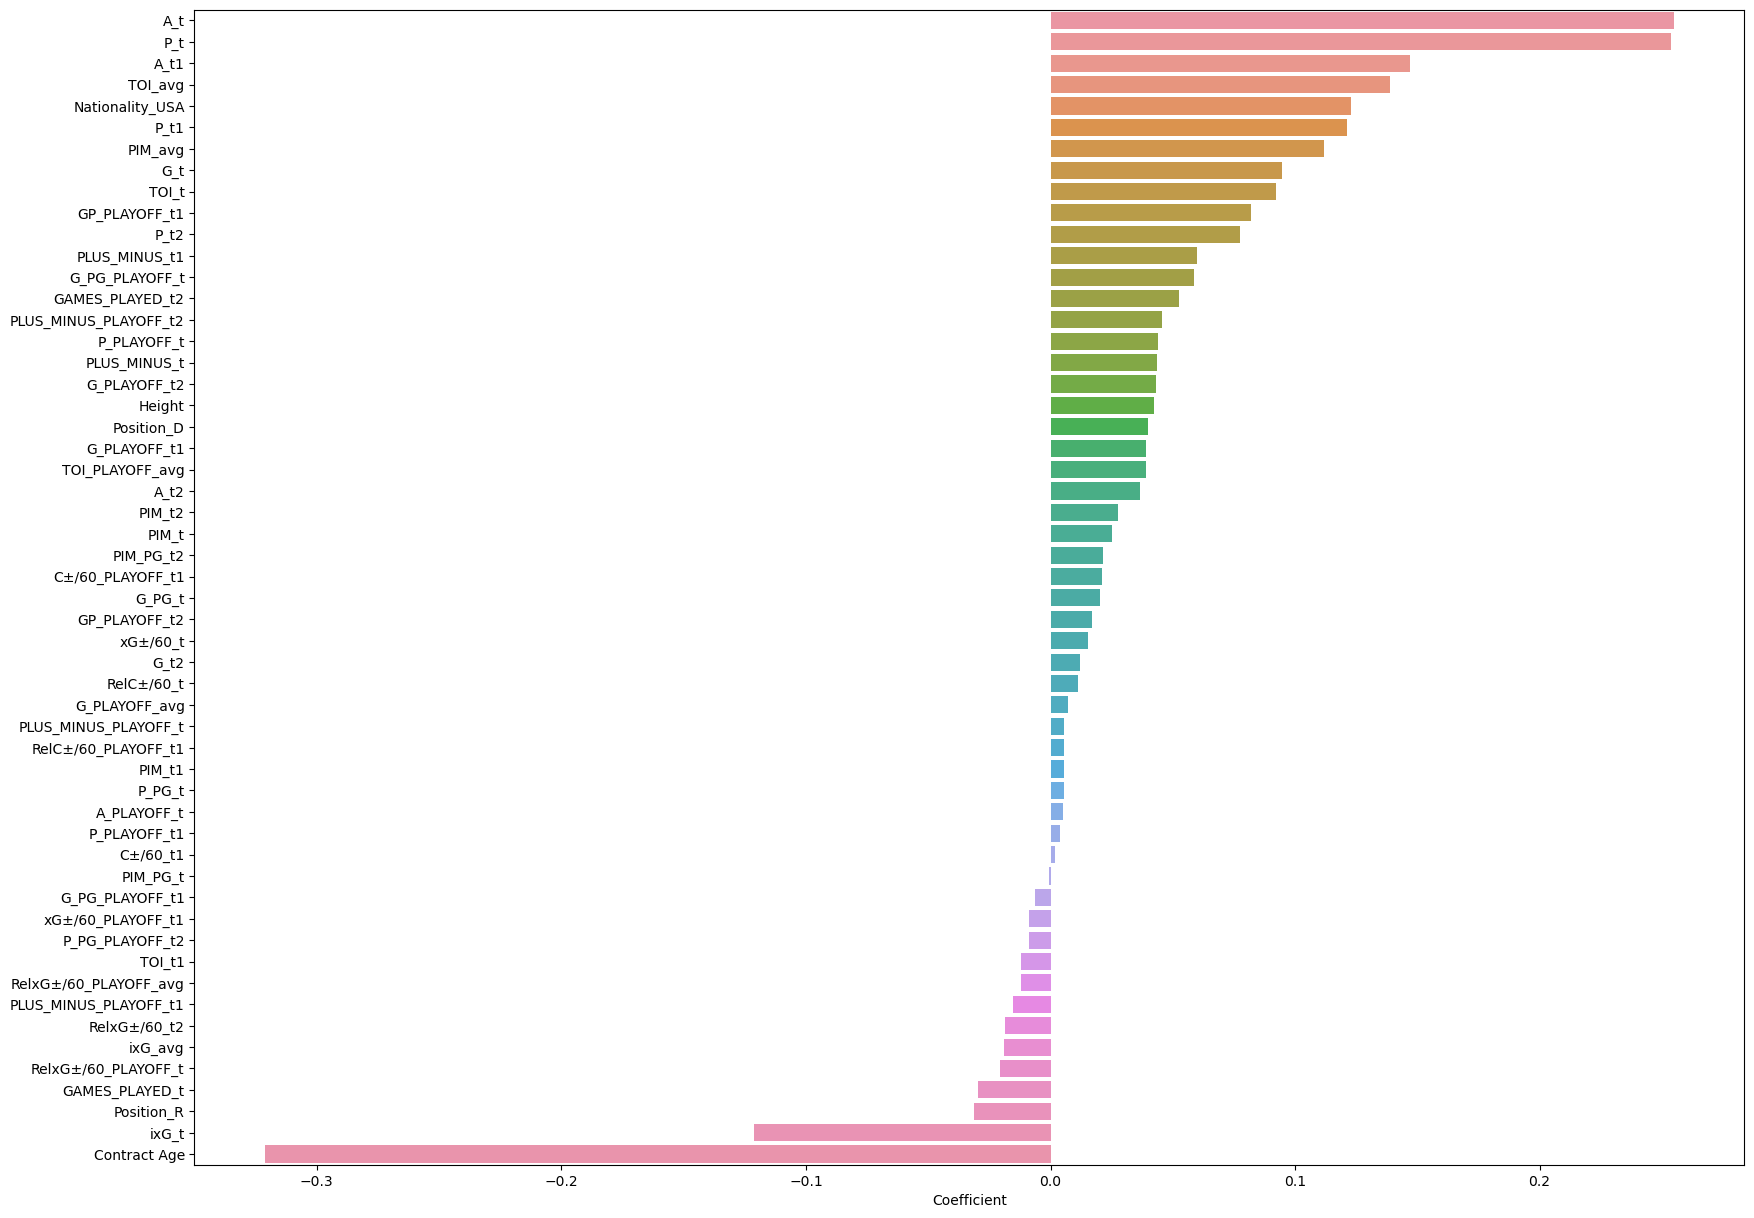

In [135]:
# get coefficients chart
eln_l_coef = pd.DataFrame(pd.Series(eln_l_final.coef_,
                                    index=eln_l_final.feature_names_in_)).sort_values(by=0,ascending=False)
eln_l_coef.columns = ['Coefficient']
eln_l_coef_sub = eln_l_coef[eln_l_coef['Coefficient'] != 0]
fig,ax = plt.subplots(figsize=(20,15))
sns.barplot(y=eln_l_coef_sub.index,x=eln_l_coef_sub['Coefficient']);

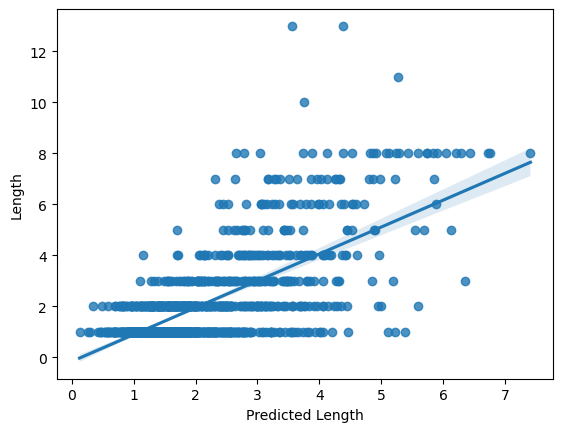

In [136]:
# plot true values vs residuals
sns.regplot(x=eln_l_predict,y=y_l_test);

Similar to with contract values, the elastic net model has similar coefficients to the ridge regression, emphasizing player statistics (points, assists, TOI) as well as contract age strongly.

#### Decision Tree Regression

In [137]:
# initialize Decision Tree Regression
dtr_l = DecisionTreeRegressor(random_state=100)
dtr_parameters_l_1 = {'criterion':['squared_error','friedman_mse','absolute_error','poisson'],
                      'splitter': ['best','random'],
                      'max_depth':[1,5,10,20],
                      'min_samples_split':[1,3,5,7],
                      'max_features':['auto','sqrt','log2'],
                      'random_state': [100]}

In [138]:
# perform grid search
gs_dtr_l_1 = GridSearchCV(dtr_l,dtr_parameters_l_1,scoring='neg_mean_absolute_error',cv=5,verbose=False)
gs_dtr_l_1.fit(X_train,y_l_train)

GridSearchCV(cv=5, estimator=DecisionTreeRegressor(random_state=100),
             param_grid={'criterion': ['squared_error', 'friedman_mse',
                                       'absolute_error', 'poisson'],
                         'max_depth': [1, 5, 10, 20],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'min_samples_split': [1, 3, 5, 7],
                         'random_state': [100],
                         'splitter': ['best', 'random']},
             scoring='neg_mean_absolute_error', verbose=False)

In [139]:
gs_dtr_l_1.best_score_

-0.7963160001720414

In [140]:
gs_dtr_l_1.best_params_

{'criterion': 'absolute_error',
 'max_depth': 5,
 'max_features': 'auto',
 'min_samples_split': 5,
 'random_state': 100,
 'splitter': 'best'}

In [141]:
# enhance grid search
dtr_parameters_l_2 = {'criterion':['absolute_error'],
                      'splitter': ['best'],
                      'max_depth':[2,5,8],
                      'min_samples_split':[3,5,7],
                      'max_features':['auto'],
                      'random_state': [100]}
gs_dtr_l_2 = GridSearchCV(dtr_l,dtr_parameters_l_2,scoring='neg_mean_absolute_error',cv=5,verbose=False)
gs_dtr_l_2.fit(X_train,y_l_train)

GridSearchCV(cv=5, estimator=DecisionTreeRegressor(random_state=100),
             param_grid={'criterion': ['absolute_error'],
                         'max_depth': [2, 5, 8], 'max_features': ['auto'],
                         'min_samples_split': [3, 5, 7], 'random_state': [100],
                         'splitter': ['best']},
             scoring='neg_mean_absolute_error', verbose=False)

In [142]:
gs_dtr_l_2.best_score_

-0.7963160001720414

In [143]:
gs_dtr_l_2.best_params_

{'criterion': 'absolute_error',
 'max_depth': 5,
 'max_features': 'auto',
 'min_samples_split': 5,
 'random_state': 100,
 'splitter': 'best'}

In [144]:
# build final model using best params
dtr_l_final = DecisionTreeRegressor(criterion = 'absolute_error',
                                    splitter = 'best',
                                    max_features = 'auto',
                                    max_depth = 5,
                                    min_samples_split = 5,
                                    random_state = 100)
dtr_l_final.fit(X_train,y_l_train)

DecisionTreeRegressor(criterion='absolute_error', max_depth=5,
                      max_features='auto', min_samples_split=5,
                      random_state=100)

In [145]:
# get final model error
dtr_l_predict = pd.Series(dtr_l_final.predict(X_test))
dtr_l_predict.name = 'Predicted Length'
dtr_l_final_mae = mean_absolute_error(dtr_l_final.predict(X_test),y_l_test)
dtr_l_final_mae

0.7503858024691358

In [146]:
# add eln mae to dataframe
cap_hit_error.loc['Decision Tree Regression','Contract Length'] = dtr_l_final_mae
cap_hit_error

Contract Annual Value  Contract Length
Ridge Regression                       0.008227         0.868545
LASSO Regression                       0.009268         0.849836
Elastic Net Regression                 0.008243         0.858148
Decision Tree Regression               0.007482         0.750386
Random Forest Regression               0.005836              NaN
XGBoost Regression                     0.005943              NaN

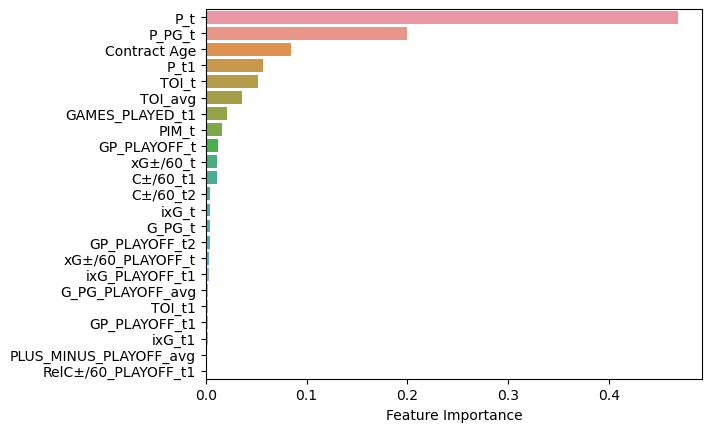

In [147]:
# get feature importance chart
dtr_l_featureImportance = pd.DataFrame(pd.Series(dtr_l_final.feature_importances_,
                                                 index=dtr_l_final.feature_names_in_)).sort_values(by=0,
                                                                                                   ascending=False)
dtr_l_featureImportance.columns = ['Feature Importance']
dtr_l_featureImportance_sub = dtr_l_featureImportance[dtr_l_featureImportance['Feature Importance'] != 0]
sns.barplot(y=dtr_l_featureImportance_sub.index,x=dtr_l_featureImportance_sub['Feature Importance']);

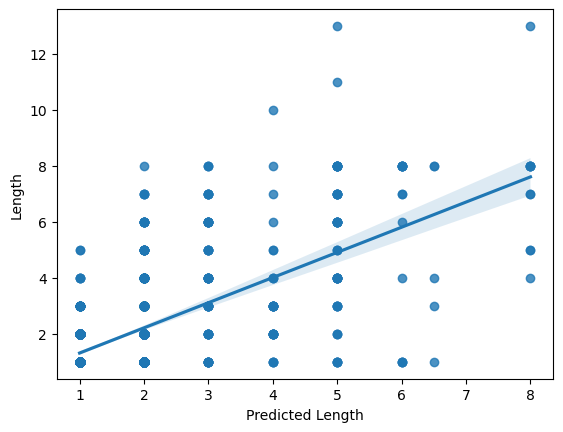

In [148]:
# plot true values vs residuals
sns.regplot(x=dtr_l_predict,y=y_l_test);

In what is the best performing model yet by some margin, the decision tree regression distills the important features of the first three attempts, placing importance on contract year points and TOI, followed by goals and assists.

#### Random Forest Regression

In [149]:
# initialize Decision Tree Regression
rfr_l = RandomForestRegressor(random_state=100)
rfr_l_parameters_1 = {'n_estimators':[50,100,150],
                      'random_state': [100]}

In [150]:
# perform grid search
gs_rfr_l_1 = GridSearchCV(rfr_l,rfr_l_parameters_1,scoring='neg_mean_absolute_error',cv=5,verbose=False)
gs_rfr_l_1.fit(X_train,y_l_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=100),
             param_grid={'n_estimators': [50, 100, 150], 'random_state': [100]},
             scoring='neg_mean_absolute_error', verbose=False)

In [151]:
gs_rfr_l_1.best_score_

-0.8112350481219377

In [152]:
gs_rfr_l_1.best_params_

{'n_estimators': 100, 'random_state': 100}

In [153]:
# enhance grid search
rfr_l_parameters_2 = {'n_estimators':[75,100,125]}
gs_rfr_l_2 = GridSearchCV(rfr_l,rfr_l_parameters_2,scoring='neg_mean_absolute_error',cv=5,verbose=False)
gs_rfr_l_2.fit(X_train,y_l_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=100),
             param_grid={'n_estimators': [75, 100, 125]},
             scoring='neg_mean_absolute_error', verbose=False)

In [154]:
gs_rfr_l_2.best_score_

-0.8103811072181253

In [155]:
gs_rfr_l_2.best_params_

{'n_estimators': 125}

In [156]:
# build final model using best params
rfr_l_final = RandomForestRegressor(n_estimators=125,random_state=100)
rfr_l_final.fit(X_train,y_l_train)

RandomForestRegressor(n_estimators=125, random_state=100)

In [157]:
# get final model error
rfr_l_predict = pd.Series(rfr_l_final.predict(X_test))
rfr_l_predict.name = 'Predicted Length'
rfr_l_final_mae = mean_absolute_error(rfr_l_final.predict(X_test),y_l_test)
rfr_l_final_mae

0.7714876543209878

In [158]:
# add rfr mae to dataframe
cap_hit_error.loc['Random Forest Regression','Contract Length'] = rfr_l_final_mae
cap_hit_error

Contract Annual Value  Contract Length
Ridge Regression                       0.008227         0.868545
LASSO Regression                       0.009268         0.849836
Elastic Net Regression                 0.008243         0.858148
Decision Tree Regression               0.007482         0.750386
Random Forest Regression               0.005836         0.771488
XGBoost Regression                     0.005943              NaN

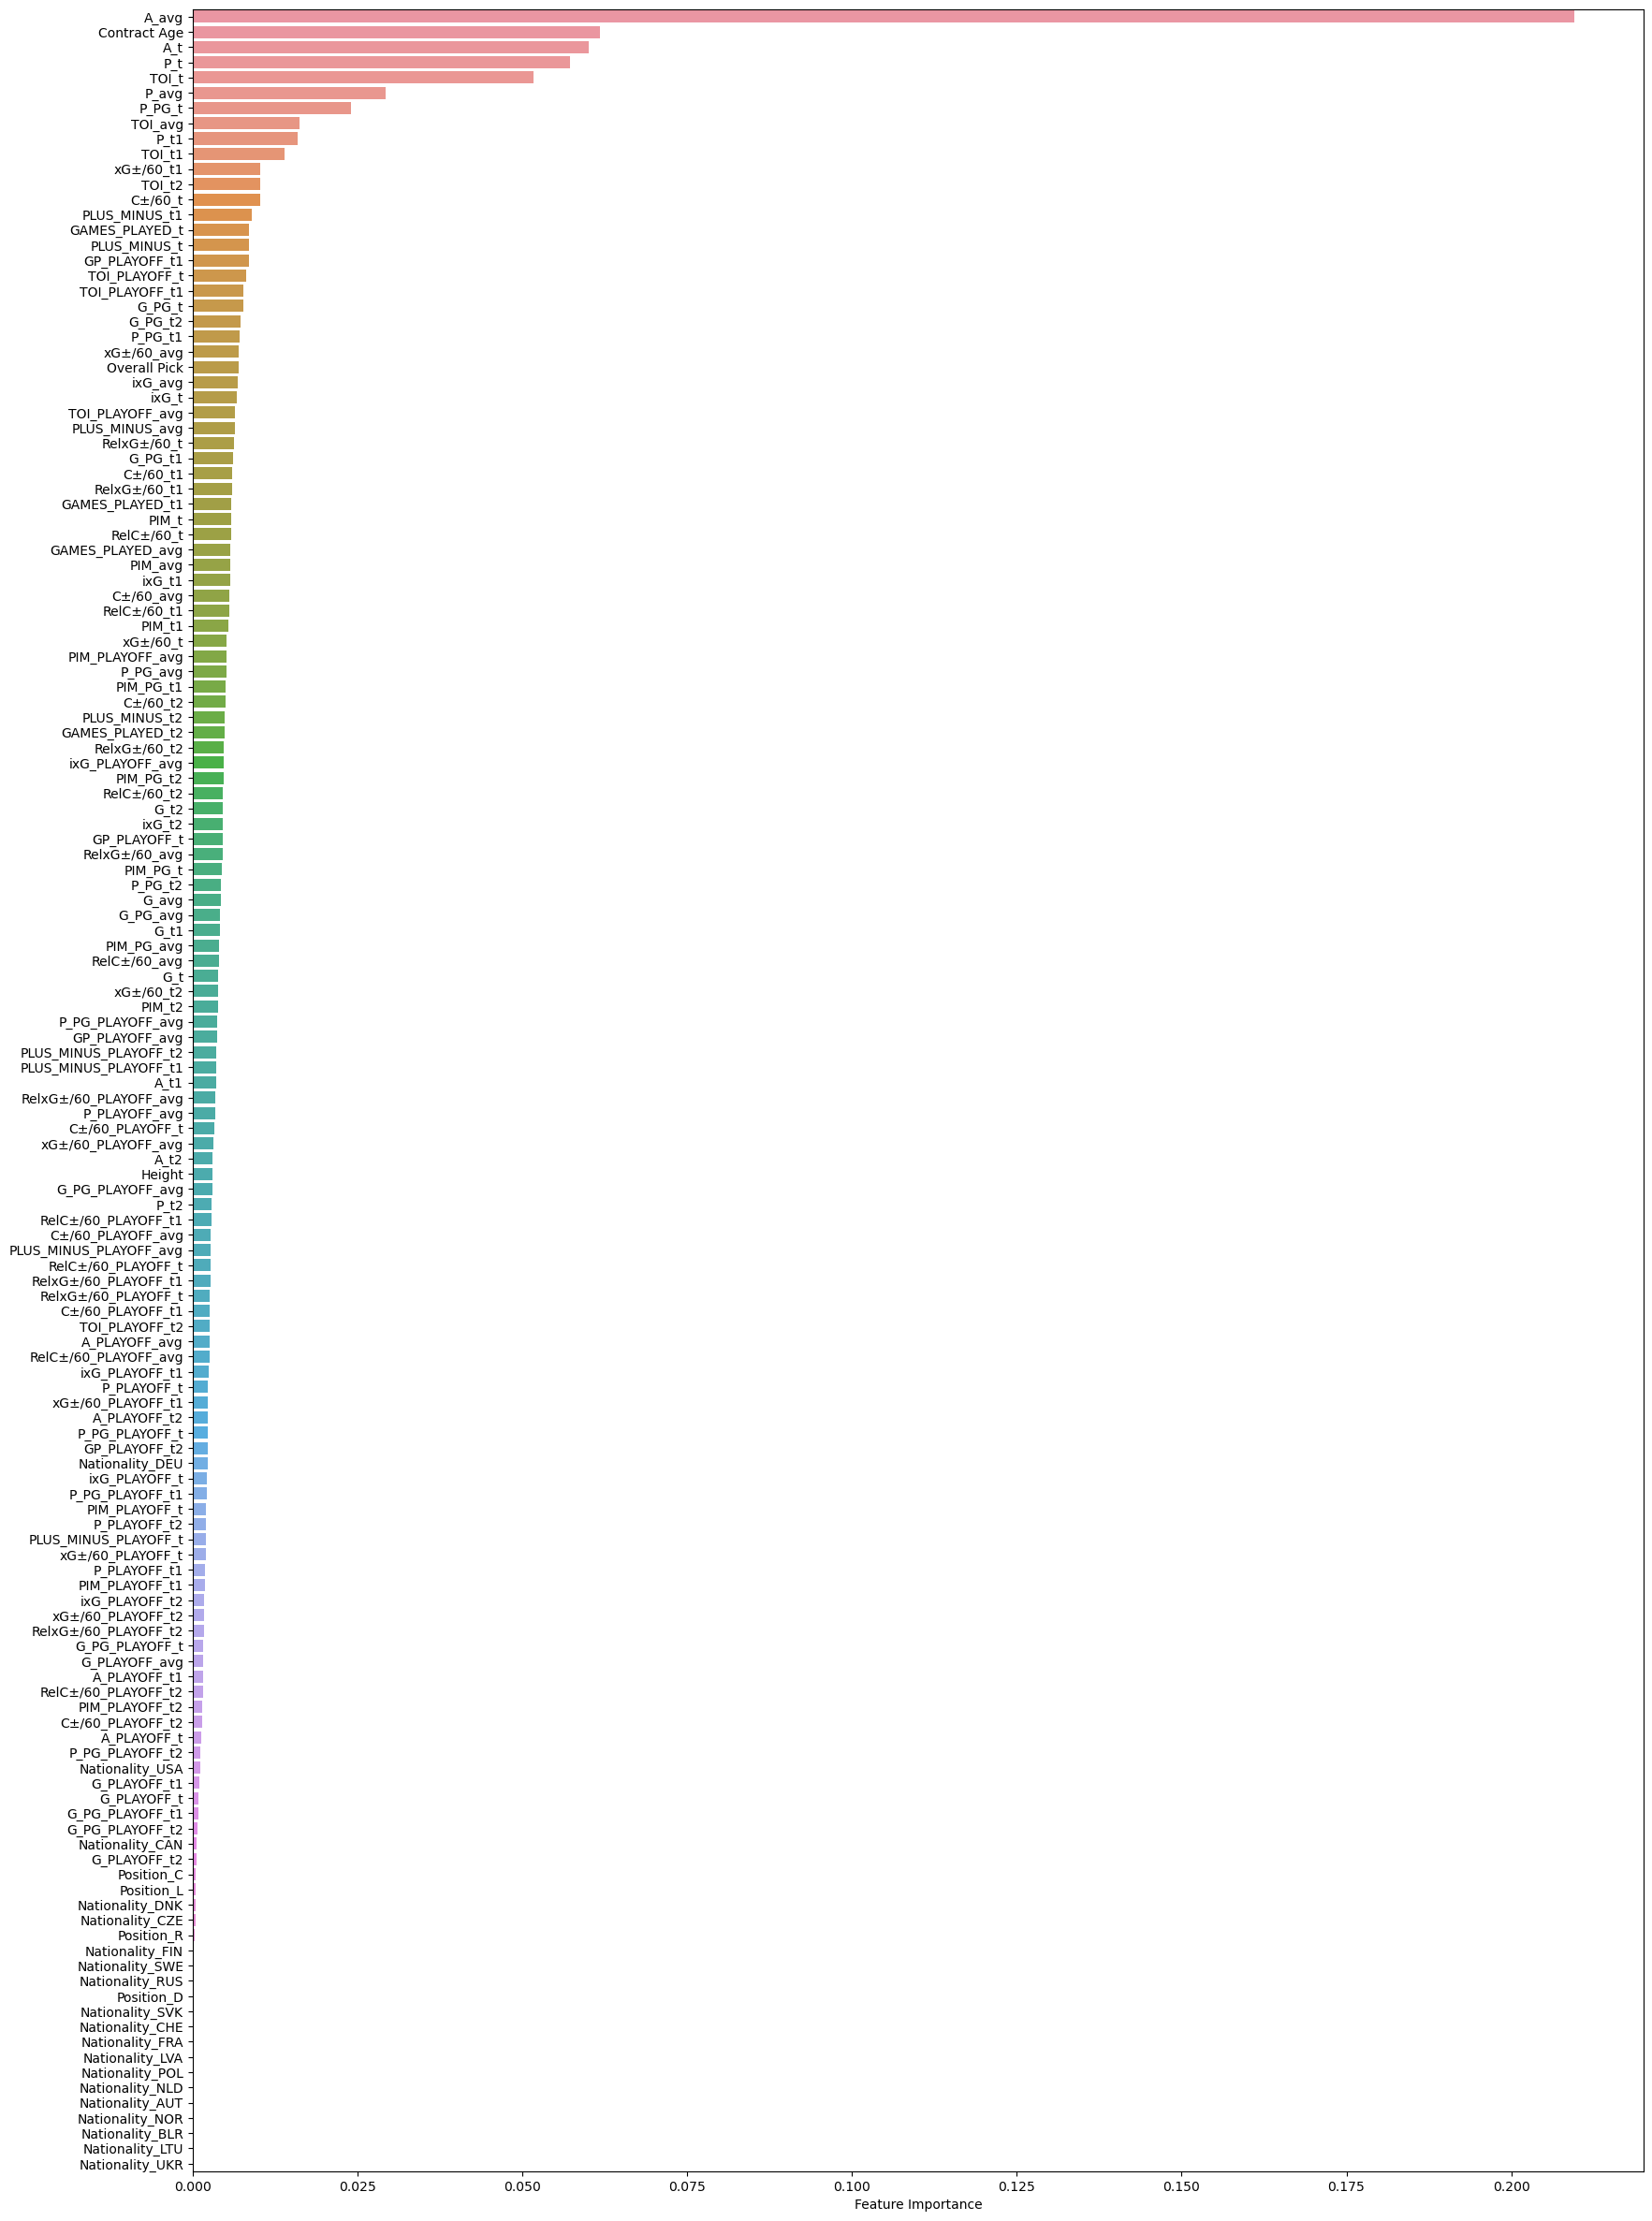

In [159]:
# get feature importance chart
rfr_l_featureImportance = pd.DataFrame(pd.Series(rfr_l_final.feature_importances_,
                                               index=rfr_l_final.feature_names_in_)).sort_values(by=0,ascending=False)
rfr_l_featureImportance.columns = ['Feature Importance']
rfr_l_featureImportance_sub = rfr_l_featureImportance[rfr_l_featureImportance['Feature Importance'] != 0]
fig,ax = plt.subplots(figsize=(20,30))
sns.barplot(y=rfr_l_featureImportance_sub.index,x=rfr_l_featureImportance_sub['Feature Importance']);

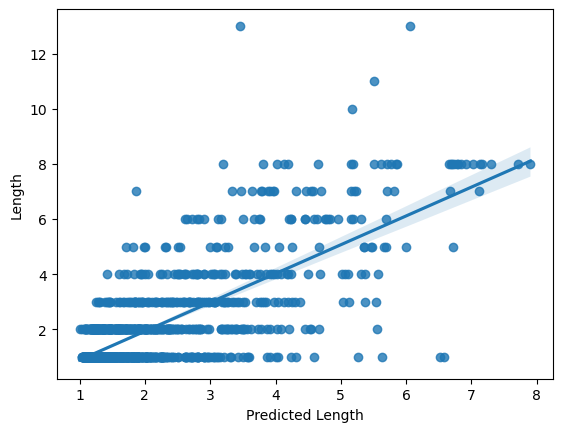

In [160]:
# plot true values vs residuals
sns.regplot(x=rfr_l_predict,y=y_l_test);

The random forest regression performs similarly, though slightly worse, than the decision tree regression. Rather than emphasizing points, it prioritizes assists, though it does still consider the oft-repeating features of contract age, points, and TOI.

#### XGBoost Regression

In [161]:
# initialize XGBoost Regression
xgbr_l = XGBRegressor(random_state=100)
xgbr_l_parameters_1 = {'learning_rate': [0.05,0.10,0.15],
                       'max_depth': [2,5,10],
                       'min_child_weight': [1,3,5],
                       'n_estimators': [20,40,80],
                       'tree_method': ['exact','approx','hist'],
                       'random_state': [100]}

In [162]:
# perform grid search
gs_xgbr_l_1 = GridSearchCV(xgbr_l,xgbr_l_parameters_1,scoring='neg_mean_absolute_error',cv=5,verbose=False)
gs_xgbr_l_1.fit(X_train,y_l_train)

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None, gpu_id=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None, n_estimators=100,
                                    n_jobs=None, num_parallel_tree=None,
                                    predictor=None, random_state=100, ...),
             param_grid={'learning_rate': [0.05, 0.1, 0.15],
                         'max_depth': [2, 5, 10], 'min_child_weight': [1, 3, 5],
                         'n_estimators': [20, 40, 80], 'random_state': [100],
                         'tree_method': ['exact', 'approx', 'hist']},
             scoring='neg_mean_absolute_error', verbose=False)

In [163]:
gs_xgbr_l_1.best_score_

-0.7933696781067393

In [164]:
gs_xgbr_l_1.best_params_

{'learning_rate': 0.1,
 'max_depth': 5,
 'min_child_weight': 3,
 'n_estimators': 80,
 'random_state': 100,
 'tree_method': 'exact'}

In [165]:
# enhance grid search
xgbr_l_parameters_2 = {'learning_rate': [0.05,0.10,0.15],
                     'max_depth': [2,5,10],
                     'min_child_weight': [1,3],
                     'n_estimators': [60,80,95],
                     'tree_method': ['exact','approx'],
                     'random_state': [100]}
gs_xgbr_l_2 = GridSearchCV(xgbr_l,xgbr_l_parameters_2,scoring='neg_mean_absolute_error',cv=5,verbose=False)
gs_xgbr_l_2.fit(X_train,y_l_train)

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None, gpu_id=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None, n_estimators=100,
                                    n_jobs=None, num_parallel_tree=None,
                                    predictor=None, random_state=100, ...),
             param_grid={'learning_rate': [0.05, 0.1, 0.15],
                         'max_depth': [2, 5, 10], 'min_child_weight': [1, 3],
                         'n_estimators': [60, 80, 95], 'random_state': [100],
                         'tree_method': ['exact', 'approx']},
             scoring='neg_mean_absolute_error', verbose=False)

In [166]:
gs_xgbr_l_2.best_score_

-0.7933696781067393

In [167]:
gs_xgbr_l_2.best_params_

{'learning_rate': 0.1,
 'max_depth': 5,
 'min_child_weight': 3,
 'n_estimators': 80,
 'random_state': 100,
 'tree_method': 'exact'}

In [168]:
# build final model using best params
xgbr_l_final = XGBRegressor(learning_rate=0.1,
                            max_depth=5,
                            min_child_weight=3,
                            n_estimators=80,
                            tree_method='exact',
                            random_state=100)
xgbr_l_final.fit(X_train,y_l_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=3, missing=nan, monotone_constraints=None,
             n_estimators=80, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=100, ...)

In [169]:
# get final model error
xgbr_l_predict = pd.Series(xgbr_l_final.predict(X_test))
xgbr_l_predict.name = 'Predicted Length'
xgbr_l_final_mae = mean_absolute_error(xgbr_l_final.predict(X_test),y_l_test)
xgbr_l_final_mae

0.7425286059302313

In [170]:
# add xgbr mae to dataframe
cap_hit_error.loc['XGBoost Regression','Contract Length'] = xgbr_l_final_mae
cap_hit_error

Contract Annual Value  Contract Length
Ridge Regression                       0.008227         0.868545
LASSO Regression                       0.009268         0.849836
Elastic Net Regression                 0.008243         0.858148
Decision Tree Regression               0.007482         0.750386
Random Forest Regression               0.005836         0.771488
XGBoost Regression                     0.005943         0.742529

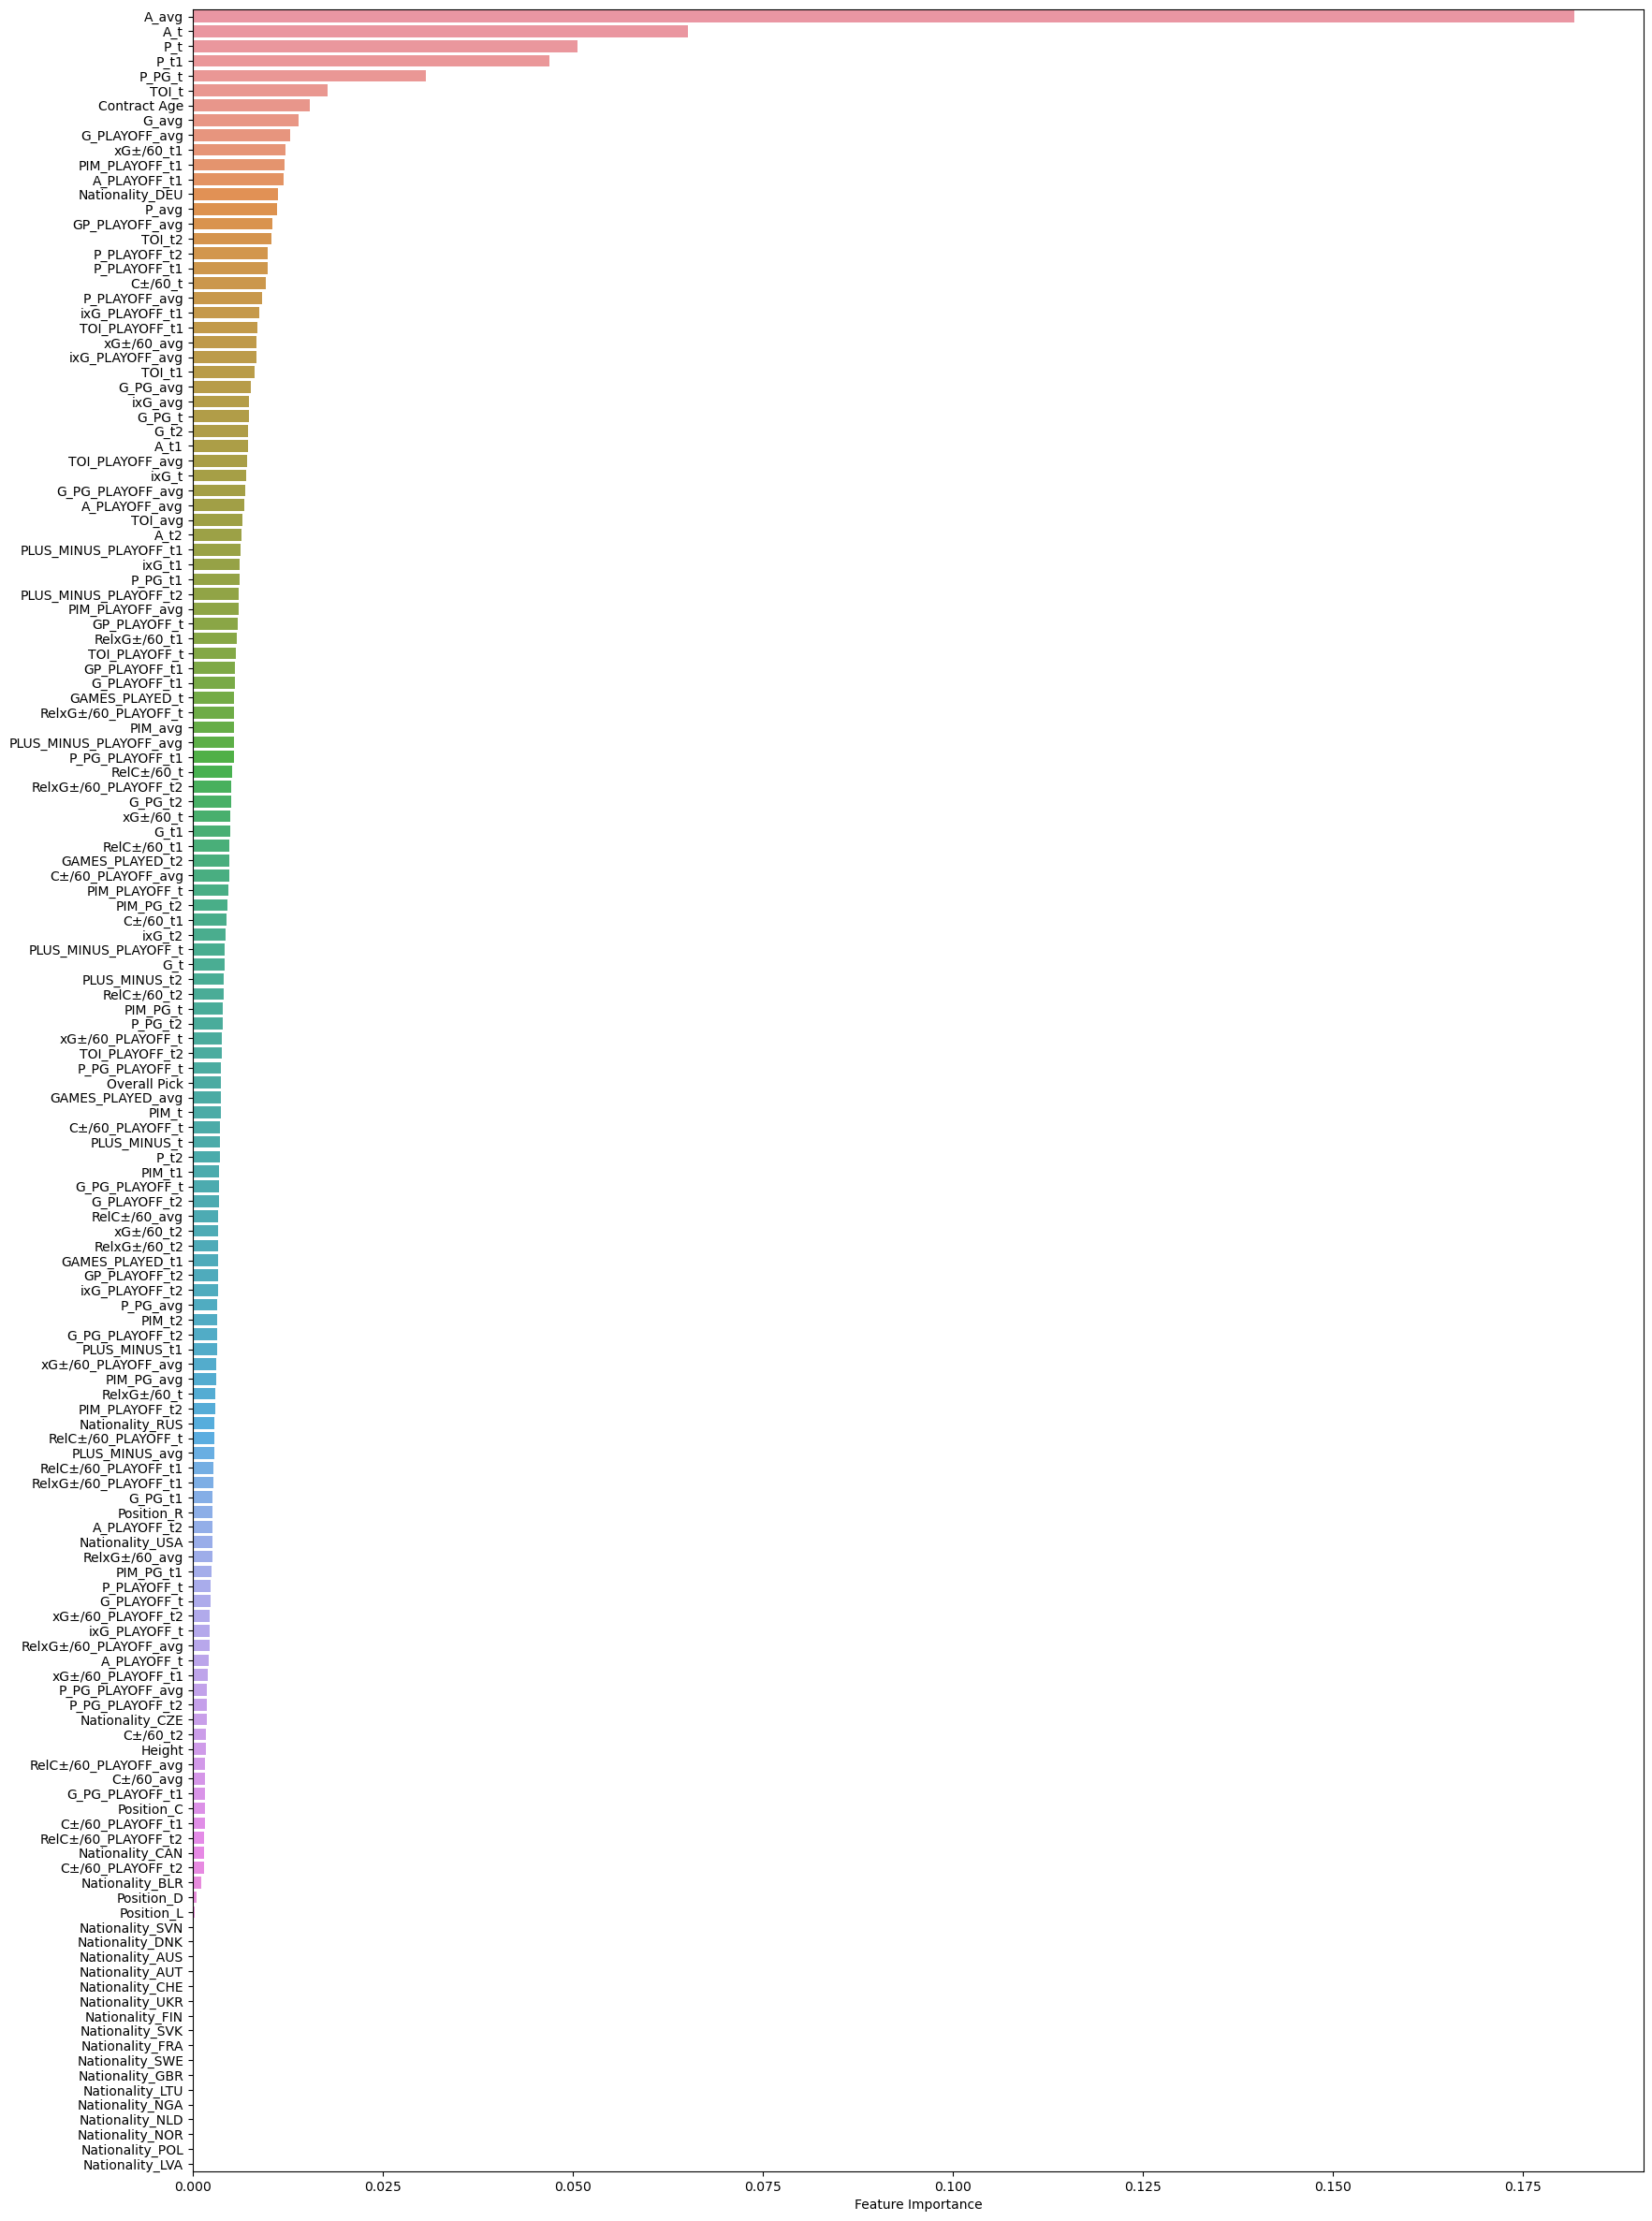

In [171]:
# get feature importance chart
xgbr_l_featureImportance = pd.DataFrame(pd.Series(xgbr_l_final.feature_importances_,
                                                  index=xgbr_l_final.feature_names_in_)).sort_values(by=0,
                                                                                                     ascending=False)
xgbr_l_featureImportance.columns = ['Feature Importance']
fig,ax = plt.subplots(figsize=(20,30))
sns.barplot(y=xgbr_l_featureImportance.index,x=xgbr_l_featureImportance['Feature Importance']);

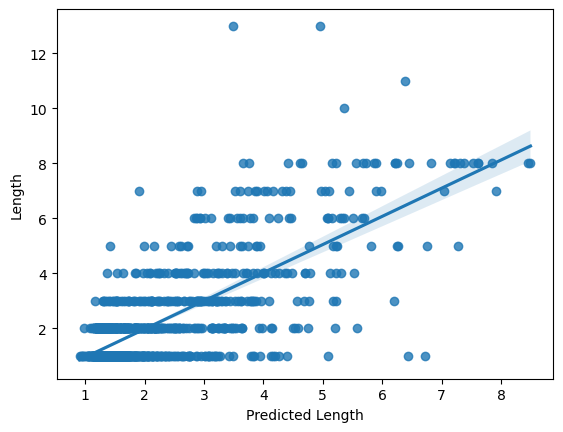

In [172]:
# plot true values vs residuals
sns.regplot(x=xgbr_l_predict,y=y_l_test);

## Evaluation

Now that we have run all of the models, we can select the ones that we should use to project the different components of the model. We start by reviewing the table of all the model outputs.

In [173]:
cap_hit_error

Contract Annual Value  Contract Length
Ridge Regression                       0.008227         0.868545
LASSO Regression                       0.009268         0.849836
Elastic Net Regression                 0.008243         0.858148
Decision Tree Regression               0.007482         0.750386
Random Forest Regression               0.005836         0.771488
XGBoost Regression                     0.005943         0.742529

The table, which shows the output of all the models, suggests that based on MAE, the chosen error metric, the models used should be random forest regression for predicting annual contract value, and XGBoost regression for predicting contract length. It is worth noting that with even a small change in data, or perhaps even further optimization, the model selection could end up being different; however, for the sake of ease, we will select the final model solely on the basis of MAE.

## Deployment

To actually make use of the model, we must first load in the test data and apply the same pre-processing as we did to the original data.

In [191]:
# load in new data
data_new = pd.read_csv('data/new_contract_players.csv')

In [192]:
data_new.head()

index  ContractAge Position Nationality  Height  Overall Pick  \
0     Zach Parise         39.0        L         USA    71.0          17.0   
1      John Moore         33.0        D         USA    75.0          21.0   
2      Miles Wood         28.0        L         USA    74.0         100.0   
3  Steven Santini         28.0        D         USA    74.0          42.0   
4    Will Butcher         28.0        D         USA    70.0         123.0   

   GAMES_PLAYED_t   G_t   A_t   P_t  ...  xG±/60_PLAYOFF_avg  \
0            82.0  21.0  13.0  34.0  ...           -0.200000   
1             0.0   0.0   0.0   0.0  ...            0.000000   
2            76.0  13.0  14.0  27.0  ...           -0.043333   
3             4.0   0.0   1.0   1.0  ...            0.630000   
4             0.0   0.0   0.0   0.0  ...            0.000000   

   RelxG±/60_PLAYOFF_avg  C±/60_PLAYOFF_avg  RelC±/60_PLAYOFF_avg  G_PG_avg  \
0               0.073333         -14.293333             -6.610000  0.198193   
1               0.000000           0.000000              0.000000  0.000000   
2              -0.086667          -6.646667             -5.193333  0.160048   
3               1.353333          29.753333             37.203333  0.000000   
4               0.000000           0.000000              0.000000  0.048766   

   P_PG_avg  PIM_PG_avg  G_PG_PLAYOFF_avg  P_PG_PLAYOFF_avg  Current Salary  
0  0.413821    0.255827          0.166667          0.250000      $6,371,794  
1  0.271429    0.485714          0.000000          0.000000      $2,750,000  
2  0.269936    0.953535          0.083333          0.083333      $3,200,000  
3  0.194444    0.166667          0.000000          0.000000        $750,000  
4  0.347239    0.043478          0.000000          0.000000        $750,000  

[5 rows x 123 columns]

In [193]:
# save salary cap column for later
salaries = data_new['Current Salary']
names = data_new['index']

In [194]:
data_new.shape

(178, 123)

In [195]:
# drop unnecessary columns
data_new = data_new.drop(columns=['Current Salary','index'])

Since we are going to train the models on the full training data set, we can re-apply the preprocessing steps to the training data, and then repeat for the test data. This ensures that there is no additional randomness being introduced into the model.

In [196]:
# re-check original data
X.head()

Contract Age Position Nationality  Height  Overall Pick  GAMES_PLAYED_t  \
0          34.0        L         USA    73.0          32.0            54.0   
1          37.0        L         USA    73.0          32.0             0.0   
2          38.0        L         USA    73.0          32.0            62.0   
3          36.0        L         USA    73.0          32.0            52.0   
6          36.0        R         USA    73.0          35.0            31.0   

    G_t   A_t   P_t  PLUS_MINUS_t  ...  ixG_PLAYOFF_avg  xG±/60_PLAYOFF_avg  \
0  12.0  12.0  24.0          10.0  ...         0.203333           -0.143333   
1   0.0   0.0   0.0           0.0  ...         0.310000           -0.080000   
2   1.0   2.0   3.0         -14.0  ...         0.000000            0.000000   
3   4.0   5.0   9.0         -10.0  ...         0.410000           -0.196667   
6   4.0  10.0  14.0         -15.0  ...         0.470000            0.063333   

   RelxG±/60_PLAYOFF_avg  C±/60_PLAYOFF_avg  RelC±/60_PLAYOFF_avg  G_PG_avg  \
0              -0.093333          -3.380000             -1.830000  0.167570   
1              -0.055000          -3.365000              0.485000  0.079445   
2               0.000000           0.000000              0.000000  0.046526   
3              -0.130000          -5.623333             -1.506667  0.127038   
6               0.100000           9.790000              6.630000  0.240542   

   P_PG_avg  PIM_PG_avg  G_PG_PLAYOFF_avg  P_PG_PLAYOFF_avg  
0  0.339205    0.233363          0.067340          0.215488  
1  0.168506    0.139660          0.071429          0.071429  
2  0.110732    0.122208          0.000000          0.000000  
3  0.260485    0.228909          0.047619          0.047619  
6  0.685517    0.583566          0.166667          0.316667  

[5 rows x 121 columns]

In [197]:
X.shape

(5182, 121)

In [198]:
data_new.shape

(178, 121)

In [199]:
# split data into categorical variables
categorical_variables = ['Position','Nationality']
data_categorical = X[categorical_variables]
data_numeric = X.drop(columns=categorical_variables,axis=1)

# encode categorical variables
ohe_data = OneHotEncoder(sparse=False)
data_categorical = ohe_data.fit_transform(data_categorical)
data_categorical = pd.DataFrame(data_categorical,columns=ohe_data.get_feature_names_out())
encoder_categories = ohe_data.categories_

# scale numeric variables
scaler_data = StandardScaler()
data_numeric = scaler_data.fit_transform(data_numeric)
data_numeric = pd.DataFrame(data_numeric,columns=scaler_data.get_feature_names_out())

# re-combine categorical and numeric features
data_train = pd.concat([data_categorical,data_numeric],axis=1)

In [200]:
data_train.shape

(5182, 147)

Now that we have scaled the training data to fit the model in entirety, we can apply the same scaling and processing to the full new data.

In [201]:
# check new data
data_new = data_new.rename(columns = {'ContractAge':'Contract Age'})

In [202]:
data_new.head()

Contract Age Position Nationality  Height  Overall Pick  GAMES_PLAYED_t  \
0          39.0        L         USA    71.0          17.0            82.0   
1          33.0        D         USA    75.0          21.0             0.0   
2          28.0        L         USA    74.0         100.0            76.0   
3          28.0        D         USA    74.0          42.0             4.0   
4          28.0        D         USA    70.0         123.0             0.0   

    G_t   A_t   P_t  PLUS_MINUS_t  ...  ixG_PLAYOFF_avg  xG±/60_PLAYOFF_avg  \
0  21.0  13.0  34.0           7.0  ...         0.563333           -0.200000   
1   0.0   0.0   0.0           0.0  ...         0.000000            0.000000   
2  13.0  14.0  27.0           1.0  ...         0.310000           -0.043333   
3   0.0   1.0   1.0           0.0  ...         0.050000            0.630000   
4   0.0   0.0   0.0           0.0  ...         0.000000            0.000000   

   RelxG±/60_PLAYOFF_avg  C±/60_PLAYOFF_avg  RelC±/60_PLAYOFF_avg  G_PG_avg  \
0               0.073333         -14.293333             -6.610000  0.198193   
1               0.000000           0.000000              0.000000  0.000000   
2              -0.086667          -6.646667             -5.193333  0.160048   
3               1.353333          29.753333             37.203333  0.000000   
4               0.000000           0.000000              0.000000  0.048766   

   P_PG_avg  PIM_PG_avg  G_PG_PLAYOFF_avg  P_PG_PLAYOFF_avg  
0  0.413821    0.255827          0.166667          0.250000  
1  0.271429    0.485714          0.000000          0.000000  
2  0.269936    0.953535          0.083333          0.083333  
3  0.194444    0.166667          0.000000          0.000000  
4  0.347239    0.043478          0.000000          0.000000  

[5 rows x 121 columns]

In [203]:
# split data
data_new_categorical = data_new[categorical_variables]
data_new_numeric = data_new.drop(columns=categorical_variables,axis=1)

# encode categorical variables
ohe_new = OneHotEncoder(sparse=False,handle_unknown='ignore',categories=encoder_categories)
data_new_categorical = ohe_new.fit_transform(data_new_categorical)
data_new_categorical = pd.DataFrame(data_new_categorical,columns=ohe_new.get_feature_names_out())

# scale numeric variables
data_new_numeric = scaler_data.transform(data_new_numeric)
data_new_numeric = pd.DataFrame(data_new_numeric,columns=scaler_data.get_feature_names_out())

# re-combine categorical and numeric features
data_new = pd.concat([data_new_categorical,data_new_numeric],axis=1)

In [204]:
data_new.shape

(178, 147)

Now that the new data is processed and able to be inputted into the model, we can train the final models that we have chosen and obtain the output.

In [205]:
# train random forest regression model for predicting contract value
rfr_final = RandomForestRegressor(n_estimators=250,random_state=100)
rfr_final.fit(data_train,y)

RandomForestRegressor(n_estimators=250, random_state=100)

In [206]:
# get predicted values
contract_values = rfr_final.predict(data_new)

In [207]:
# train XGBoost regression model for predicting contract length
xgbr_l_final = XGBRegressor(learning_rate=0.1,
                            max_depth=5,
                            min_child_weight=3,
                            n_estimators=80,
                            tree_method='exact',
                            random_state=100)
xgbr_l_final.fit(data_train,y_l)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=3, missing=nan, monotone_constraints=None,
             n_estimators=80, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=100, ...)

In [208]:
contract_lengths = xgbr_l_final.predict(data_new)

In [209]:
# create new dataframe with results
results = pd.DataFrame({'Name': names,
                        'Current Salary': salaries,
                        'Contract Annual Value': contract_values,
                        'Contract Length': contract_lengths})

In [210]:
results.head()

Name Current Salary  Contract Annual Value  Contract Length
0     Zach Parise     $6,371,794               0.036286         1.761720
1      John Moore     $2,750,000               0.009155         1.149446
2      Miles Wood     $3,200,000               0.019915         2.063231
3  Steven Santini       $750,000               0.010008         1.288769
4    Will Butcher       $750,000               0.010110         1.197933

Since we know that the total salary cap for the upcoming season is 83.5 million, we can apply that to the results to get the annual contract value in millions, as well as the predicted total contract value.

In [211]:
results['Contract Annual Value (mio)'] = results['Contract Annual Value']*83.5
results['Total Contract Value'] = results['Contract Annual Value (mio)']*results['Contract Length']
results = results.set_index('Name')

In [212]:
pd.set_option('display.max_rows', None)

In [213]:
results

Current Salary  Contract Annual Value  \
Name                                                             
Zach Parise                  $6,371,794               0.036286   
John Moore                   $2,750,000               0.009155   
Miles Wood                   $3,200,000               0.019915   
Steven Santini                 $750,000               0.010008   
Will Butcher                   $750,000               0.010110   
Connor Carrick                 $750,000               0.009088   
Wayne Simmonds                 $900,000               0.011890   
John Hayden                    $750,000               0.009287   
Dakota Mermis                  $750,000               0.008700   
Dmitry Kulikov               $2,250,000               0.031511   
Ryan Murray                    $750,000               0.011462   
Andreas Johnsson             $3,400,000               0.011593   
Tomas Tatar                  $4,500,000               0.047308   
Mason Geertsen                 $750,000               0.009117   
Ryan Graves                  $3,166,666               0.062532   
Travis Hamonic               $3,000,000               0.021512   
Scott Mayfield               $1,450,000               0.059330   
Chris Wagner                 $1,350,000               0.009726   
Derick Brassard                $750,000               0.014706   
Cole Bardreau                  $750,000               0.008856   
Richard Panik                $2,750,000               0.008949   
Marc Staal                     $750,000               0.025453   
Derek Stepan                   $750,000               0.015452   
Anton Stralman               $1,000,000               0.014938   
Carl Hagelin                 $2,750,000               0.010852   
Dylan McIlrath                 $750,000               0.009673   
Jesper Fast                  $2,000,000               0.045475   
Eric Staal                     $750,000               0.024380   
Jayson Megna                   $750,000               0.008828   
Nick Holden                  $1,300,000               0.020305   
Kevin Shattenkirk            $3,900,000               0.031604   
Vladislav Namestnikov        $2,500,000               0.015184   
Vinni Lettieri                 $750,000               0.009014   
Brendan Lemieux              $1,350,000               0.015132   
Jack Johnson                 $1,916,667               0.025550   
Anthony Bitetto                $750,000               0.008981   
Ryan Reaves                  $1,750,000               0.011439   
Patrik Nemeth                $2,500,000               0.015469   
Tyler Motte                  $1,350,000               0.010391   
Dryden Hunt                    $762,500               0.010541   
Luke Schenn                    $850,000               0.029418   
Shayne Gostisbehere          $4,500,000               0.073526   
Pierre-Edouard Bellemare     $1,000,000               0.016442   
Sam Gagner                     $750,000               0.013440   
Radko Gudas                  $2,500,000               0.035545   
Robert Hagg                    $800,000               0.011745   
Justin Bailey                  $750,000               0.008856   
Derek Grant                  $1,500,000               0.014458   
Tyler Pitlick                  $750,000               0.010836   
Patrick Brown                  $750,000               0.010152   
Max Willman                    $750,000               0.008850   
Jordan Staal                 $6,000,000               0.047462   
Brian Dumoulin               $4,100,000               0.054352   
Patric Hornqvist             $5,300,000               0.016086   
Ian Cole                     $3,000,000               0.037670   
Scott Harrington               $750,000               0.009681   
Nick Bonino                  $2,050,000               0.024297   
Josh Archibald                 $900,000               0.012783   
Oskar Sundqvist              $2,750,000               0.013266   

## Conclusions and Future Improvements

On an absolute basis, we can conclude that the model predicts contract values pretty well, while it struggles more with contract length. This is not altogether unexpected, because contract length may ultimately be a better function of different features, which gives room to improve the project. In particular, player health metrics, injury history, and reputation / franchise value might be useful to incorporate in future versions of the model, and those features might be better predictors of the length of a contract a player ultimately signs.

In terms of contract value, out-of-sample MAE of xxx is a strong result in terms of what it actually represents - to think that the model is off by less than 1% of the salary cap suggests that the contract market can indeed be very efficient, and suggests two further findings that can be tested:

* that the occurrence of so-called 'bad contracts' come down to contract length rather than contract value
* there is further room for teams to improve their analysis on the contracts they issue and further optimize

As for the project on the whole, there are a few more improvements to be had, in addition to improving the features used. Those would be:

* increasing the number of player statistics tested, as well as the granularity of those statistics (looking at the game level rather than the season level, for example)
* testing more unsupervised learning models, particularly neural networks
* expanding the analysis to goalies, which were not used in this project because they require a different set of statistics